## CNN Classifier Testscript - Vacation Images
This version has already resized images in the datafolders to avoid a bottleneck while training the network.


### Imports

In [1]:
#general
import numpy as np
import splitfolders
import time
from datetime import datetime 
from time import gmtime, strftime
from tqdm import tqdm
import os

#pytorch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

#visualization
import matplotlib.pyplot as plt

### Some parameters to be set

In [2]:
#==============#
pixel = 128    # --> 128,64,32 are valid
#==============#
version = f'{pixel}x{pixel}'
#==============#
batch_size = 64
#==============#
epochs = 3000
#==============#
lr = 0.0001
#==============#
momentum = 0.9
#==============#
num_workers = 2
#==============#

### Script Runtime Start

In [3]:
def start_time_():    
    start_time = time.time()
    return(start_time)

def end_time_():
    end_time = time.time()
    return(end_time)

def Execution_time(start_time_,end_time_):
    return(strftime("%H:%M:%S",gmtime(int('{:.0f}'.format(float(str((end_time_-start_time_))))))))

In [4]:
script_start = start_time_()

### Create Directory for saving files

In [5]:
dirName_1 = f'graphs/{version}'
dirName_2 = f'models/{version}'
dirName_3 = f'output_txt/{version}'

directories = [dirName_1, dirName_2, dirName_3]

# Create target Directory if don't exist

for path in directories:
    if not os.path.exists(path):
        os.mkdir(path)
        print("Directory " , path ,  " Created ")
    else:    
        print("Directory " , path ,  " already exists")  

Directory  graphs/128x128  already exists
Directory  models/128x128  already exists
Directory  output_txt/128x128  already exists


### Initialize textfile for prints

In [6]:
f = open(f'output_txt/{version}/cnn_net_b{batch_size}_e{epochs}.txt', 'a')

print(f'The parameters for this network are: \n\
        - input image size: \t {version}\n\
        - batch_size dataloader: {batch_size}\n\
        - number of epcohs: \t {epochs}\n\
        - learning rate: \t\t {lr}\n\
        - momentum: \t\t\t {momentum}\n\
        - number of workers: \t {num_workers}','\n', file=f)


### Initialize GPU

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Creating Folder Structure

The original folder containing the 2 subclass folder has to be split into subfolders for train, validation and test.

`Original:`  
* Data
    * Person
    * Scene
---
`New:`
* Data
    * train (70% of total)
        * Person
        * Scene
    * val (10% of total)
        * Person
        * Scene
    * test (20% of total)
        * Person
        * Scene

In [8]:
## Following Code does the described above

# input_folder = 'Data/'
# output_folder = 'img_data/'

# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.7, 0.1, 0.2))

In [9]:
#paths to be used for dataloaders later on
path_to_train = './img_data_2/train/'
path_to_val = './img_data_2/val/'
path_to_test = './img_data_2/test/'

### Define data tranformations

In [10]:
mean = [0.4939, 0.5189, 0.5326] #calculated in seperate notebook file
std = [0.2264, 0.2398, 0.2707] #calculated in seperate notebook file


#for training a litte augmentation (random flip, grayscale and rotation) will be performed
train_transforms = T.Compose([
    T.Resize([pixel,]),
    T.CenterCrop([pixel,]),
    T.RandomHorizontalFlip(0.3), 
    T.RandomGrayscale(0.1),
    T.RandomRotation(30),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
val_transforms = T.Compose([
    T.Resize([pixel,]),
    T.CenterCrop([pixel,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
test_transforms = T.Compose([
    T.Resize([pixel,]),
    T.CenterCrop([pixel,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

### Initialize Datasets (Train, Validation, Test)

In [ ]:
#Create datasets, labling is done with "ImageFolder"-Method
train_dataset = torchvision.datasets.ImageFolder(root=path_to_train, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=path_to_val, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=path_to_test, transform=test_transforms)

In [11]:
classes = ('person', 'scene')

### Initialize DataLoaders for the Datasets

In [12]:
#Define Loaders
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=True, 
                                         num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=num_workers)

### Unnormalize pictures for visualization later

In [13]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

### Define Image viewer

In [14]:
def imshow(img):
    de_norm = UnNormalize(mean=(0.4939, 0.5189, 0.5326), std=(0.2264, 0.2398, 0.2707))
    img = de_norm(img)      # unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Define CNN 

In [15]:
class CNN(nn.Module):
    
    def __init__(self, pixel):
        
        super(CNN, self).__init__()
        self.pixel = pixel
        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2,2)
        
        #_________128x128__________________________
        if self.pixel == 128:
            self.conv1 = nn.Conv2d(3, 6, 5) 
            self.conv2 = nn.Conv2d(6, 16, 5, padding = 1) 
            self.conv3 = nn.Conv2d(16, 16, 5)
            
            self.fc1 = nn.Linear(16 * 13 * 13, 120) #(16 channel * 13 * 13 (image size))
            
        #_________64x64____________________________
        elif self.pixel == 64:
            self.conv1 = nn.Conv2d(3, 6, 3, padding = 1) 
            self.conv2 = nn.Conv2d(6, 16, 3, padding = 1) 
            self.conv3 = nn.Conv2d(16, 16, 3)
            
            self.fc1 = nn.Linear(16 * 7 * 7, 120) #(16 channel * 7 * 7 (image size))
            
        #_________32x32____________________________
        elif self.pixel == 32:
            self.conv1 = nn.Conv2d(3, 6, 3, padding = 1) 
            self.conv2 = nn.Conv2d(6, 16, 3, padding = 1) 
            self.conv3 = nn.Conv2d(16, 16, 3)
            
            self.fc1 = nn.Linear(16 * 3 * 3, 120) #(16 channel * 3 * 3 (image size))
            
        #________following_linear_layers___________
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 2)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [16]:
cnn = CNN(pixel).to(device)

### Define loss function and optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=lr, momentum=momentum)

### Train network

In [18]:
#splitted from below, to run more epochs if needed without setting loss lists to zero
train_loss = []  
validation_loss = []
min_valid_loss = np.inf  #value to distinguish if model will be saved or not. If val loss lower, model will be saved

In [19]:
#Starting Time 
train_start = start_time_()


#Training Iterations
#==========================================================================
for epoch in range(epochs):  # loop over the dataset multiple times
    
    
    #model training
    #______________________________________________________
    running_loss = 0.0
    cnn.train()
    for data, labels in tqdm(train_loader, leave=False):
        data, labels = data.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*data.size(0)
    
    
    #model validation
    #______________________________________________________
    valid_loss = 0.0
    val_correct = 0
    cnn.eval()
    for data, labels in tqdm(val_loader, leave=False):
        data, labels = data.to(device), labels.to(device)
        
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()*data.size(0)
        
        # get val_accuracy every epoch
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()
    
    
    #metrics
    #______________________________________________________
    train_loss.append(running_loss / len(train_dataset))
    validation_loss.append(valid_loss / len(val_dataset))
    val_accuracy = int(100 * val_correct / len(val_dataset))

    
    #console output for tracking
    #______________________________________________________
    console = f'Epoch {epoch+1} \t Training Loss: {(running_loss / len(train_dataset)):.6f} \t Validation Loss: {(valid_loss / len(val_dataset)):.6f} \t Validation Accuracy: {val_accuracy}%'
    print(console,file=f)
    print(console)
     
    if min_valid_loss > (valid_loss / len(val_dataset)):
        saved = f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss / len(val_dataset)):.6f}) \t Saving The Model'
        print(saved, file=f)
        print(saved)
        min_valid_loss = (valid_loss / len(val_dataset))
         
        # Saving State Dict
        torch.save(cnn.state_dict(), f'models/{version}/cnn_net_b{batch_size}_e{epochs}.pth') 
        
        
#==========================================================================


print('Finished Training','\n', file=f)
print('Finished Training')

#End Time of Training
train_end = end_time_()

#Time needed for training
print("Execution time of training:", Execution_time(train_start, train_end),'\n', file=f)
print("Execution time of training:", Execution_time(train_start, train_end))

  0%|                                                                                           | 0/33 [00:00<?, ?it/s]c:\users\matze\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1 	 Training Loss: 0.715190 	 Validation Loss: 0.714134 	 Validation Accuracy: 40%
Validation Loss Decreased(inf--->0.714134) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2 	 Training Loss: 0.713525 	 Validation Loss: 0.712334 	 Validation Accuracy: 40%
Validation Loss Decreased(0.714134--->0.712334) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 3 	 Training Loss: 0.711687 	 Validation Loss: 0.710700 	 Validation Accuracy: 40%
Validation Loss Decreased(0.712334--->0.710700) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 4 	 Training Loss: 0.710085 	 Validation Loss: 0.709052 	 Validation Accuracy: 40%
Validation Loss Decreased(0.710700--->0.709052) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 5 	 Training Loss: 0.708472 	 Validation Loss: 0.707486 	 Validation Accuracy: 40%
Validation Loss Decreased(0.709052--->0.707486) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 6 	 Training Loss: 0.706928 	 Validation Loss: 0.706037 	 Validation Accuracy: 40%
Validation Loss Decreased(0.707486--->0.706037) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 7 	 Training Loss: 0.705531 	 Validation Loss: 0.704561 	 Validation Accuracy: 40%
Validation Loss Decreased(0.706037--->0.704561) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 8 	 Training Loss: 0.704215 	 Validation Loss: 0.703271 	 Validation Accuracy: 40%
Validation Loss Decreased(0.704561--->0.703271) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 9 	 Training Loss: 0.702815 	 Validation Loss: 0.701977 	 Validation Accuracy: 40%
Validation Loss Decreased(0.703271--->0.701977) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 10 	 Training Loss: 0.701518 	 Validation Loss: 0.700780 	 Validation Accuracy: 40%
Validation Loss Decreased(0.701977--->0.700780) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 11 	 Training Loss: 0.700313 	 Validation Loss: 0.699611 	 Validation Accuracy: 40%
Validation Loss Decreased(0.700780--->0.699611) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 12 	 Training Loss: 0.699388 	 Validation Loss: 0.698456 	 Validation Accuracy: 40%
Validation Loss Decreased(0.699611--->0.698456) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 13 	 Training Loss: 0.698263 	 Validation Loss: 0.697439 	 Validation Accuracy: 40%
Validation Loss Decreased(0.698456--->0.697439) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 14 	 Training Loss: 0.697089 	 Validation Loss: 0.696421 	 Validation Accuracy: 40%
Validation Loss Decreased(0.697439--->0.696421) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 15 	 Training Loss: 0.696360 	 Validation Loss: 0.695499 	 Validation Accuracy: 40%
Validation Loss Decreased(0.696421--->0.695499) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 16 	 Training Loss: 0.695374 	 Validation Loss: 0.694614 	 Validation Accuracy: 40%
Validation Loss Decreased(0.695499--->0.694614) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 17 	 Training Loss: 0.694542 	 Validation Loss: 0.693733 	 Validation Accuracy: 39%
Validation Loss Decreased(0.694614--->0.693733) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 18 	 Training Loss: 0.693740 	 Validation Loss: 0.692927 	 Validation Accuracy: 59%
Validation Loss Decreased(0.693733--->0.692927) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 19 	 Training Loss: 0.692840 	 Validation Loss: 0.692192 	 Validation Accuracy: 59%
Validation Loss Decreased(0.692927--->0.692192) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 20 	 Training Loss: 0.692174 	 Validation Loss: 0.691437 	 Validation Accuracy: 59%
Validation Loss Decreased(0.692192--->0.691437) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 21 	 Training Loss: 0.691349 	 Validation Loss: 0.690751 	 Validation Accuracy: 59%
Validation Loss Decreased(0.691437--->0.690751) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 22 	 Training Loss: 0.690632 	 Validation Loss: 0.690141 	 Validation Accuracy: 59%
Validation Loss Decreased(0.690751--->0.690141) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 23 	 Training Loss: 0.690130 	 Validation Loss: 0.689506 	 Validation Accuracy: 59%
Validation Loss Decreased(0.690141--->0.689506) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 24 	 Training Loss: 0.689415 	 Validation Loss: 0.688887 	 Validation Accuracy: 59%
Validation Loss Decreased(0.689506--->0.688887) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 25 	 Training Loss: 0.688861 	 Validation Loss: 0.688337 	 Validation Accuracy: 59%
Validation Loss Decreased(0.688887--->0.688337) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 26 	 Training Loss: 0.688235 	 Validation Loss: 0.687769 	 Validation Accuracy: 59%
Validation Loss Decreased(0.688337--->0.687769) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 27 	 Training Loss: 0.687813 	 Validation Loss: 0.687198 	 Validation Accuracy: 59%
Validation Loss Decreased(0.687769--->0.687198) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 28 	 Training Loss: 0.687223 	 Validation Loss: 0.686668 	 Validation Accuracy: 59%
Validation Loss Decreased(0.687198--->0.686668) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 29 	 Training Loss: 0.686640 	 Validation Loss: 0.686181 	 Validation Accuracy: 59%
Validation Loss Decreased(0.686668--->0.686181) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 30 	 Training Loss: 0.686154 	 Validation Loss: 0.685721 	 Validation Accuracy: 59%
Validation Loss Decreased(0.686181--->0.685721) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 31 	 Training Loss: 0.685773 	 Validation Loss: 0.685259 	 Validation Accuracy: 59%
Validation Loss Decreased(0.685721--->0.685259) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 32 	 Training Loss: 0.685244 	 Validation Loss: 0.684799 	 Validation Accuracy: 59%
Validation Loss Decreased(0.685259--->0.684799) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 33 	 Training Loss: 0.684854 	 Validation Loss: 0.684412 	 Validation Accuracy: 59%
Validation Loss Decreased(0.684799--->0.684412) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 34 	 Training Loss: 0.684310 	 Validation Loss: 0.684025 	 Validation Accuracy: 59%
Validation Loss Decreased(0.684412--->0.684025) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 35 	 Training Loss: 0.684131 	 Validation Loss: 0.683617 	 Validation Accuracy: 59%
Validation Loss Decreased(0.684025--->0.683617) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 36 	 Training Loss: 0.683630 	 Validation Loss: 0.683256 	 Validation Accuracy: 59%
Validation Loss Decreased(0.683617--->0.683256) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 37 	 Training Loss: 0.683241 	 Validation Loss: 0.682894 	 Validation Accuracy: 59%
Validation Loss Decreased(0.683256--->0.682894) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 38 	 Training Loss: 0.682816 	 Validation Loss: 0.682574 	 Validation Accuracy: 59%
Validation Loss Decreased(0.682894--->0.682574) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 39 	 Training Loss: 0.682597 	 Validation Loss: 0.682212 	 Validation Accuracy: 59%
Validation Loss Decreased(0.682574--->0.682212) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 40 	 Training Loss: 0.682218 	 Validation Loss: 0.681929 	 Validation Accuracy: 59%
Validation Loss Decreased(0.682212--->0.681929) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 41 	 Training Loss: 0.681912 	 Validation Loss: 0.681593 	 Validation Accuracy: 59%
Validation Loss Decreased(0.681929--->0.681593) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 42 	 Training Loss: 0.681520 	 Validation Loss: 0.681309 	 Validation Accuracy: 59%
Validation Loss Decreased(0.681593--->0.681309) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 43 	 Training Loss: 0.681281 	 Validation Loss: 0.681017 	 Validation Accuracy: 59%
Validation Loss Decreased(0.681309--->0.681017) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 44 	 Training Loss: 0.681037 	 Validation Loss: 0.680724 	 Validation Accuracy: 59%
Validation Loss Decreased(0.681017--->0.680724) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 45 	 Training Loss: 0.680804 	 Validation Loss: 0.680460 	 Validation Accuracy: 59%
Validation Loss Decreased(0.680724--->0.680460) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 46 	 Training Loss: 0.680449 	 Validation Loss: 0.680201 	 Validation Accuracy: 59%
Validation Loss Decreased(0.680460--->0.680201) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 47 	 Training Loss: 0.680319 	 Validation Loss: 0.679953 	 Validation Accuracy: 59%
Validation Loss Decreased(0.680201--->0.679953) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 48 	 Training Loss: 0.679930 	 Validation Loss: 0.679750 	 Validation Accuracy: 59%
Validation Loss Decreased(0.679953--->0.679750) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 49 	 Training Loss: 0.679733 	 Validation Loss: 0.679510 	 Validation Accuracy: 59%
Validation Loss Decreased(0.679750--->0.679510) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 50 	 Training Loss: 0.679611 	 Validation Loss: 0.679304 	 Validation Accuracy: 59%
Validation Loss Decreased(0.679510--->0.679304) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 51 	 Training Loss: 0.679297 	 Validation Loss: 0.679065 	 Validation Accuracy: 59%
Validation Loss Decreased(0.679304--->0.679065) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 52 	 Training Loss: 0.679069 	 Validation Loss: 0.678875 	 Validation Accuracy: 59%
Validation Loss Decreased(0.679065--->0.678875) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 53 	 Training Loss: 0.678953 	 Validation Loss: 0.678690 	 Validation Accuracy: 59%
Validation Loss Decreased(0.678875--->0.678690) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 54 	 Training Loss: 0.678586 	 Validation Loss: 0.678469 	 Validation Accuracy: 59%
Validation Loss Decreased(0.678690--->0.678469) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 55 	 Training Loss: 0.678574 	 Validation Loss: 0.678309 	 Validation Accuracy: 59%
Validation Loss Decreased(0.678469--->0.678309) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 56 	 Training Loss: 0.678395 	 Validation Loss: 0.678109 	 Validation Accuracy: 59%
Validation Loss Decreased(0.678309--->0.678109) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 57 	 Training Loss: 0.678096 	 Validation Loss: 0.677958 	 Validation Accuracy: 59%
Validation Loss Decreased(0.678109--->0.677958) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 58 	 Training Loss: 0.677996 	 Validation Loss: 0.677766 	 Validation Accuracy: 59%
Validation Loss Decreased(0.677958--->0.677766) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 59 	 Training Loss: 0.677806 	 Validation Loss: 0.677611 	 Validation Accuracy: 59%
Validation Loss Decreased(0.677766--->0.677611) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 60 	 Training Loss: 0.677766 	 Validation Loss: 0.677455 	 Validation Accuracy: 59%
Validation Loss Decreased(0.677611--->0.677455) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 61 	 Training Loss: 0.677487 	 Validation Loss: 0.677323 	 Validation Accuracy: 59%
Validation Loss Decreased(0.677455--->0.677323) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 62 	 Training Loss: 0.677227 	 Validation Loss: 0.677181 	 Validation Accuracy: 59%
Validation Loss Decreased(0.677323--->0.677181) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 63 	 Training Loss: 0.677302 	 Validation Loss: 0.677041 	 Validation Accuracy: 59%
Validation Loss Decreased(0.677181--->0.677041) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 64 	 Training Loss: 0.677044 	 Validation Loss: 0.676914 	 Validation Accuracy: 59%
Validation Loss Decreased(0.677041--->0.676914) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 65 	 Training Loss: 0.676975 	 Validation Loss: 0.676791 	 Validation Accuracy: 59%
Validation Loss Decreased(0.676914--->0.676791) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 66 	 Training Loss: 0.676790 	 Validation Loss: 0.676658 	 Validation Accuracy: 59%
Validation Loss Decreased(0.676791--->0.676658) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 67 	 Training Loss: 0.676620 	 Validation Loss: 0.676548 	 Validation Accuracy: 59%
Validation Loss Decreased(0.676658--->0.676548) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 68 	 Training Loss: 0.676579 	 Validation Loss: 0.676422 	 Validation Accuracy: 59%
Validation Loss Decreased(0.676548--->0.676422) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 69 	 Training Loss: 0.676369 	 Validation Loss: 0.676310 	 Validation Accuracy: 59%
Validation Loss Decreased(0.676422--->0.676310) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 70 	 Training Loss: 0.676345 	 Validation Loss: 0.676190 	 Validation Accuracy: 59%
Validation Loss Decreased(0.676310--->0.676190) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 71 	 Training Loss: 0.676190 	 Validation Loss: 0.676094 	 Validation Accuracy: 59%
Validation Loss Decreased(0.676190--->0.676094) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 72 	 Training Loss: 0.676055 	 Validation Loss: 0.675980 	 Validation Accuracy: 59%
Validation Loss Decreased(0.676094--->0.675980) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 73 	 Training Loss: 0.676051 	 Validation Loss: 0.675903 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675980--->0.675903) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 74 	 Training Loss: 0.675991 	 Validation Loss: 0.675798 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675903--->0.675798) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 75 	 Training Loss: 0.675755 	 Validation Loss: 0.675714 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675798--->0.675714) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 76 	 Training Loss: 0.675795 	 Validation Loss: 0.675628 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675714--->0.675628) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 77 	 Training Loss: 0.675595 	 Validation Loss: 0.675556 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675628--->0.675556) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 78 	 Training Loss: 0.675595 	 Validation Loss: 0.675473 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675556--->0.675473) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 79 	 Training Loss: 0.675504 	 Validation Loss: 0.675397 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675473--->0.675397) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 80 	 Training Loss: 0.675295 	 Validation Loss: 0.675322 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675397--->0.675322) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 81 	 Training Loss: 0.675283 	 Validation Loss: 0.675246 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675322--->0.675246) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 82 	 Training Loss: 0.675251 	 Validation Loss: 0.675182 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675246--->0.675182) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 83 	 Training Loss: 0.675150 	 Validation Loss: 0.675113 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675182--->0.675113) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 84 	 Training Loss: 0.675035 	 Validation Loss: 0.675052 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675113--->0.675052) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 85 	 Training Loss: 0.675000 	 Validation Loss: 0.674987 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675052--->0.674987) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 86 	 Training Loss: 0.674911 	 Validation Loss: 0.674921 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674987--->0.674921) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 87 	 Training Loss: 0.674786 	 Validation Loss: 0.674874 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674921--->0.674874) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 88 	 Training Loss: 0.674973 	 Validation Loss: 0.674821 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674874--->0.674821) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 89 	 Training Loss: 0.674853 	 Validation Loss: 0.674763 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674821--->0.674763) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 90 	 Training Loss: 0.674754 	 Validation Loss: 0.674711 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674763--->0.674711) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 91 	 Training Loss: 0.674783 	 Validation Loss: 0.674657 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674711--->0.674657) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 92 	 Training Loss: 0.674651 	 Validation Loss: 0.674616 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674657--->0.674616) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 93 	 Training Loss: 0.674529 	 Validation Loss: 0.674560 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674616--->0.674560) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 94 	 Training Loss: 0.674452 	 Validation Loss: 0.674516 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674560--->0.674516) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 95 	 Training Loss: 0.674432 	 Validation Loss: 0.674473 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674516--->0.674473) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 96 	 Training Loss: 0.674424 	 Validation Loss: 0.674428 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674473--->0.674428) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 97 	 Training Loss: 0.674334 	 Validation Loss: 0.674387 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674428--->0.674387) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 98 	 Training Loss: 0.674347 	 Validation Loss: 0.674343 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674387--->0.674343) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 99 	 Training Loss: 0.674308 	 Validation Loss: 0.674316 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674343--->0.674316) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 100 	 Training Loss: 0.674240 	 Validation Loss: 0.674282 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674316--->0.674282) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 101 	 Training Loss: 0.674184 	 Validation Loss: 0.674240 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674282--->0.674240) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 102 	 Training Loss: 0.674164 	 Validation Loss: 0.674211 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674240--->0.674211) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 103 	 Training Loss: 0.674105 	 Validation Loss: 0.674169 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674211--->0.674169) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 104 	 Training Loss: 0.674128 	 Validation Loss: 0.674136 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674169--->0.674136) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 105 	 Training Loss: 0.674228 	 Validation Loss: 0.674111 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674136--->0.674111) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 106 	 Training Loss: 0.674030 	 Validation Loss: 0.674069 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674111--->0.674069) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 107 	 Training Loss: 0.673995 	 Validation Loss: 0.674044 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674069--->0.674044) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 108 	 Training Loss: 0.673982 	 Validation Loss: 0.674019 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674044--->0.674019) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 109 	 Training Loss: 0.674002 	 Validation Loss: 0.673980 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674019--->0.673980) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 110 	 Training Loss: 0.673865 	 Validation Loss: 0.673954 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673980--->0.673954) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 111 	 Training Loss: 0.673781 	 Validation Loss: 0.673928 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673954--->0.673928) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 112 	 Training Loss: 0.673883 	 Validation Loss: 0.673903 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673928--->0.673903) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 113 	 Training Loss: 0.673842 	 Validation Loss: 0.673881 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673903--->0.673881) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 114 	 Training Loss: 0.673743 	 Validation Loss: 0.673847 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673881--->0.673847) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 115 	 Training Loss: 0.673699 	 Validation Loss: 0.673824 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673847--->0.673824) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 116 	 Training Loss: 0.673681 	 Validation Loss: 0.673810 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673824--->0.673810) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 117 	 Training Loss: 0.673690 	 Validation Loss: 0.673783 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673810--->0.673783) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 118 	 Training Loss: 0.673753 	 Validation Loss: 0.673762 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673783--->0.673762) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 119 	 Training Loss: 0.673663 	 Validation Loss: 0.673736 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673762--->0.673736) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 120 	 Training Loss: 0.673589 	 Validation Loss: 0.673718 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673736--->0.673718) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 121 	 Training Loss: 0.673552 	 Validation Loss: 0.673694 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673718--->0.673694) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 122 	 Training Loss: 0.673483 	 Validation Loss: 0.673675 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673694--->0.673675) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 123 	 Training Loss: 0.673522 	 Validation Loss: 0.673653 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673675--->0.673653) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 124 	 Training Loss: 0.673605 	 Validation Loss: 0.673632 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673653--->0.673632) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 125 	 Training Loss: 0.673471 	 Validation Loss: 0.673611 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673632--->0.673611) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 126 	 Training Loss: 0.673335 	 Validation Loss: 0.673597 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673611--->0.673597) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 127 	 Training Loss: 0.673358 	 Validation Loss: 0.673581 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673597--->0.673581) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 128 	 Training Loss: 0.673441 	 Validation Loss: 0.673563 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673581--->0.673563) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 129 	 Training Loss: 0.673285 	 Validation Loss: 0.673544 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673563--->0.673544) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 130 	 Training Loss: 0.673479 	 Validation Loss: 0.673524 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673544--->0.673524) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 131 	 Training Loss: 0.673453 	 Validation Loss: 0.673506 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673524--->0.673506) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 132 	 Training Loss: 0.673431 	 Validation Loss: 0.673486 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673506--->0.673486) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 133 	 Training Loss: 0.673268 	 Validation Loss: 0.673473 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673486--->0.673473) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 134 	 Training Loss: 0.673228 	 Validation Loss: 0.673451 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673473--->0.673451) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 135 	 Training Loss: 0.673199 	 Validation Loss: 0.673427 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673451--->0.673427) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 136 	 Training Loss: 0.673270 	 Validation Loss: 0.673402 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673427--->0.673402) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 137 	 Training Loss: 0.673078 	 Validation Loss: 0.673385 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673402--->0.673385) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 138 	 Training Loss: 0.673095 	 Validation Loss: 0.673365 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673385--->0.673365) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 139 	 Training Loss: 0.673038 	 Validation Loss: 0.673343 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673365--->0.673343) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 140 	 Training Loss: 0.673149 	 Validation Loss: 0.673325 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673343--->0.673325) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 141 	 Training Loss: 0.673171 	 Validation Loss: 0.673308 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673325--->0.673308) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 142 	 Training Loss: 0.673132 	 Validation Loss: 0.673282 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673308--->0.673282) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 143 	 Training Loss: 0.673076 	 Validation Loss: 0.673257 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673282--->0.673257) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 144 	 Training Loss: 0.673096 	 Validation Loss: 0.673234 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673257--->0.673234) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 145 	 Training Loss: 0.672991 	 Validation Loss: 0.673209 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673234--->0.673209) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 146 	 Training Loss: 0.673090 	 Validation Loss: 0.673186 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673209--->0.673186) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 147 	 Training Loss: 0.673084 	 Validation Loss: 0.673164 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673186--->0.673164) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 148 	 Training Loss: 0.673012 	 Validation Loss: 0.673139 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673164--->0.673139) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 149 	 Training Loss: 0.673018 	 Validation Loss: 0.673119 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673139--->0.673119) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 150 	 Training Loss: 0.672866 	 Validation Loss: 0.673102 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673119--->0.673102) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 151 	 Training Loss: 0.672972 	 Validation Loss: 0.673082 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673102--->0.673082) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 152 	 Training Loss: 0.673119 	 Validation Loss: 0.673064 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673082--->0.673064) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 153 	 Training Loss: 0.672876 	 Validation Loss: 0.673047 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673064--->0.673047) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 154 	 Training Loss: 0.672824 	 Validation Loss: 0.673031 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673047--->0.673031) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 155 	 Training Loss: 0.672933 	 Validation Loss: 0.673017 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673031--->0.673017) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 156 	 Training Loss: 0.672928 	 Validation Loss: 0.673002 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673017--->0.673002) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 157 	 Training Loss: 0.672694 	 Validation Loss: 0.672986 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673002--->0.672986) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 158 	 Training Loss: 0.672792 	 Validation Loss: 0.672972 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672986--->0.672972) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 159 	 Training Loss: 0.672731 	 Validation Loss: 0.672958 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672972--->0.672958) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 160 	 Training Loss: 0.672774 	 Validation Loss: 0.672942 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672958--->0.672942) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 161 	 Training Loss: 0.672795 	 Validation Loss: 0.672931 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672942--->0.672931) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 162 	 Training Loss: 0.672740 	 Validation Loss: 0.672915 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672931--->0.672915) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 163 	 Training Loss: 0.672678 	 Validation Loss: 0.672901 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672915--->0.672901) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 164 	 Training Loss: 0.672666 	 Validation Loss: 0.672889 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672901--->0.672889) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 165 	 Training Loss: 0.672674 	 Validation Loss: 0.672876 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672889--->0.672876) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 166 	 Training Loss: 0.672575 	 Validation Loss: 0.672860 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672876--->0.672860) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 167 	 Training Loss: 0.672569 	 Validation Loss: 0.672845 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672860--->0.672845) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 168 	 Training Loss: 0.672569 	 Validation Loss: 0.672835 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672845--->0.672835) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 169 	 Training Loss: 0.672622 	 Validation Loss: 0.672822 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672835--->0.672822) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 170 	 Training Loss: 0.672634 	 Validation Loss: 0.672809 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672822--->0.672809) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 171 	 Training Loss: 0.672649 	 Validation Loss: 0.672796 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672809--->0.672796) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 172 	 Training Loss: 0.672516 	 Validation Loss: 0.672781 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672796--->0.672781) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 173 	 Training Loss: 0.672537 	 Validation Loss: 0.672769 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672781--->0.672769) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 174 	 Training Loss: 0.672332 	 Validation Loss: 0.672751 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672769--->0.672751) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 175 	 Training Loss: 0.672508 	 Validation Loss: 0.672737 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672751--->0.672737) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 176 	 Training Loss: 0.672317 	 Validation Loss: 0.672720 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672737--->0.672720) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 177 	 Training Loss: 0.672415 	 Validation Loss: 0.672704 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672720--->0.672704) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 178 	 Training Loss: 0.672313 	 Validation Loss: 0.672686 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672704--->0.672686) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 179 	 Training Loss: 0.672379 	 Validation Loss: 0.672666 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672686--->0.672666) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 180 	 Training Loss: 0.672277 	 Validation Loss: 0.672649 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672666--->0.672649) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 181 	 Training Loss: 0.672328 	 Validation Loss: 0.672632 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672649--->0.672632) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 182 	 Training Loss: 0.672271 	 Validation Loss: 0.672612 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672632--->0.672612) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 183 	 Training Loss: 0.672169 	 Validation Loss: 0.672592 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672612--->0.672592) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 184 	 Training Loss: 0.672160 	 Validation Loss: 0.672572 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672592--->0.672572) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 185 	 Training Loss: 0.672024 	 Validation Loss: 0.672550 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672572--->0.672550) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 186 	 Training Loss: 0.671914 	 Validation Loss: 0.672527 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672550--->0.672527) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 187 	 Training Loss: 0.672223 	 Validation Loss: 0.672507 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672527--->0.672507) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 188 	 Training Loss: 0.672139 	 Validation Loss: 0.672484 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672507--->0.672484) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 189 	 Training Loss: 0.672193 	 Validation Loss: 0.672465 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672484--->0.672465) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 190 	 Training Loss: 0.672075 	 Validation Loss: 0.672446 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672465--->0.672446) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 191 	 Training Loss: 0.672003 	 Validation Loss: 0.672426 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672446--->0.672426) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 192 	 Training Loss: 0.671867 	 Validation Loss: 0.672404 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672426--->0.672404) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 193 	 Training Loss: 0.672078 	 Validation Loss: 0.672382 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672404--->0.672382) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 194 	 Training Loss: 0.671755 	 Validation Loss: 0.672361 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672382--->0.672361) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 195 	 Training Loss: 0.671744 	 Validation Loss: 0.672338 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672361--->0.672338) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 196 	 Training Loss: 0.671615 	 Validation Loss: 0.672314 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672338--->0.672314) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 197 	 Training Loss: 0.671757 	 Validation Loss: 0.672288 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672314--->0.672288) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 198 	 Training Loss: 0.671665 	 Validation Loss: 0.672264 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672288--->0.672264) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 199 	 Training Loss: 0.671749 	 Validation Loss: 0.672241 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672264--->0.672241) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 200 	 Training Loss: 0.671643 	 Validation Loss: 0.672214 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672241--->0.672214) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 201 	 Training Loss: 0.671462 	 Validation Loss: 0.672187 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672214--->0.672187) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 202 	 Training Loss: 0.671732 	 Validation Loss: 0.672159 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672187--->0.672159) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 203 	 Training Loss: 0.671435 	 Validation Loss: 0.672131 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672159--->0.672131) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 204 	 Training Loss: 0.671536 	 Validation Loss: 0.672103 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672131--->0.672103) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 205 	 Training Loss: 0.671501 	 Validation Loss: 0.672073 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672103--->0.672073) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 206 	 Training Loss: 0.671605 	 Validation Loss: 0.672043 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672073--->0.672043) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 207 	 Training Loss: 0.671365 	 Validation Loss: 0.672012 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672043--->0.672012) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 208 	 Training Loss: 0.671273 	 Validation Loss: 0.671978 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672012--->0.671978) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 209 	 Training Loss: 0.671241 	 Validation Loss: 0.671941 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671978--->0.671941) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 210 	 Training Loss: 0.671331 	 Validation Loss: 0.671907 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671941--->0.671907) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 211 	 Training Loss: 0.671404 	 Validation Loss: 0.671872 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671907--->0.671872) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 212 	 Training Loss: 0.671357 	 Validation Loss: 0.671836 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671872--->0.671836) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 213 	 Training Loss: 0.671095 	 Validation Loss: 0.671803 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671836--->0.671803) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 214 	 Training Loss: 0.671110 	 Validation Loss: 0.671767 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671803--->0.671767) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 215 	 Training Loss: 0.670969 	 Validation Loss: 0.671728 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671767--->0.671728) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 216 	 Training Loss: 0.670922 	 Validation Loss: 0.671688 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671728--->0.671688) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 217 	 Training Loss: 0.670972 	 Validation Loss: 0.671648 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671688--->0.671648) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 218 	 Training Loss: 0.670961 	 Validation Loss: 0.671606 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671648--->0.671606) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 219 	 Training Loss: 0.670682 	 Validation Loss: 0.671565 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671606--->0.671565) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 220 	 Training Loss: 0.670894 	 Validation Loss: 0.671521 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671565--->0.671521) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 221 	 Training Loss: 0.670802 	 Validation Loss: 0.671478 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671521--->0.671478) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 222 	 Training Loss: 0.670756 	 Validation Loss: 0.671432 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671478--->0.671432) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 223 	 Training Loss: 0.670657 	 Validation Loss: 0.671384 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671432--->0.671384) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 224 	 Training Loss: 0.670514 	 Validation Loss: 0.671336 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671384--->0.671336) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 225 	 Training Loss: 0.670233 	 Validation Loss: 0.671285 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671336--->0.671285) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 226 	 Training Loss: 0.670608 	 Validation Loss: 0.671233 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671285--->0.671233) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 227 	 Training Loss: 0.670093 	 Validation Loss: 0.671178 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671233--->0.671178) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 228 	 Training Loss: 0.670252 	 Validation Loss: 0.671121 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671178--->0.671121) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 229 	 Training Loss: 0.670093 	 Validation Loss: 0.671063 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671121--->0.671063) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 230 	 Training Loss: 0.670110 	 Validation Loss: 0.671004 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671063--->0.671004) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 231 	 Training Loss: 0.669868 	 Validation Loss: 0.670943 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671004--->0.670943) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 232 	 Training Loss: 0.670016 	 Validation Loss: 0.670880 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670943--->0.670880) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 233 	 Training Loss: 0.669840 	 Validation Loss: 0.670817 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670880--->0.670817) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 234 	 Training Loss: 0.669967 	 Validation Loss: 0.670749 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670817--->0.670749) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 235 	 Training Loss: 0.669591 	 Validation Loss: 0.670682 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670749--->0.670682) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 236 	 Training Loss: 0.669501 	 Validation Loss: 0.670609 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670682--->0.670609) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 237 	 Training Loss: 0.669623 	 Validation Loss: 0.670535 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670609--->0.670535) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 238 	 Training Loss: 0.669004 	 Validation Loss: 0.670454 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670535--->0.670454) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 239 	 Training Loss: 0.669329 	 Validation Loss: 0.670374 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670454--->0.670374) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 240 	 Training Loss: 0.668989 	 Validation Loss: 0.670295 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670374--->0.670295) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 241 	 Training Loss: 0.668857 	 Validation Loss: 0.670204 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670295--->0.670204) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 242 	 Training Loss: 0.669143 	 Validation Loss: 0.670114 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670204--->0.670114) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 243 	 Training Loss: 0.669238 	 Validation Loss: 0.670024 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670114--->0.670024) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 244 	 Training Loss: 0.668470 	 Validation Loss: 0.669935 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670024--->0.669935) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 245 	 Training Loss: 0.668158 	 Validation Loss: 0.669834 	 Validation Accuracy: 59%
Validation Loss Decreased(0.669935--->0.669834) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 246 	 Training Loss: 0.668582 	 Validation Loss: 0.669735 	 Validation Accuracy: 59%
Validation Loss Decreased(0.669834--->0.669735) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 247 	 Training Loss: 0.668251 	 Validation Loss: 0.669625 	 Validation Accuracy: 59%
Validation Loss Decreased(0.669735--->0.669625) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 248 	 Training Loss: 0.668554 	 Validation Loss: 0.669523 	 Validation Accuracy: 59%
Validation Loss Decreased(0.669625--->0.669523) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 249 	 Training Loss: 0.668163 	 Validation Loss: 0.669414 	 Validation Accuracy: 59%
Validation Loss Decreased(0.669523--->0.669414) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 250 	 Training Loss: 0.667933 	 Validation Loss: 0.669297 	 Validation Accuracy: 59%
Validation Loss Decreased(0.669414--->0.669297) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 251 	 Training Loss: 0.667584 	 Validation Loss: 0.669170 	 Validation Accuracy: 59%
Validation Loss Decreased(0.669297--->0.669170) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 252 	 Training Loss: 0.667960 	 Validation Loss: 0.669054 	 Validation Accuracy: 59%
Validation Loss Decreased(0.669170--->0.669054) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 253 	 Training Loss: 0.667465 	 Validation Loss: 0.668928 	 Validation Accuracy: 59%
Validation Loss Decreased(0.669054--->0.668928) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 254 	 Training Loss: 0.667751 	 Validation Loss: 0.668797 	 Validation Accuracy: 59%
Validation Loss Decreased(0.668928--->0.668797) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 255 	 Training Loss: 0.667314 	 Validation Loss: 0.668663 	 Validation Accuracy: 59%
Validation Loss Decreased(0.668797--->0.668663) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 256 	 Training Loss: 0.667167 	 Validation Loss: 0.668519 	 Validation Accuracy: 59%
Validation Loss Decreased(0.668663--->0.668519) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 257 	 Training Loss: 0.666301 	 Validation Loss: 0.668368 	 Validation Accuracy: 59%
Validation Loss Decreased(0.668519--->0.668368) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 258 	 Training Loss: 0.666922 	 Validation Loss: 0.668212 	 Validation Accuracy: 59%
Validation Loss Decreased(0.668368--->0.668212) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 259 	 Training Loss: 0.667061 	 Validation Loss: 0.668064 	 Validation Accuracy: 59%
Validation Loss Decreased(0.668212--->0.668064) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 260 	 Training Loss: 0.666275 	 Validation Loss: 0.667911 	 Validation Accuracy: 59%
Validation Loss Decreased(0.668064--->0.667911) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 261 	 Training Loss: 0.666635 	 Validation Loss: 0.667740 	 Validation Accuracy: 59%
Validation Loss Decreased(0.667911--->0.667740) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 262 	 Training Loss: 0.666064 	 Validation Loss: 0.667562 	 Validation Accuracy: 59%
Validation Loss Decreased(0.667740--->0.667562) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 263 	 Training Loss: 0.666282 	 Validation Loss: 0.667381 	 Validation Accuracy: 59%
Validation Loss Decreased(0.667562--->0.667381) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 264 	 Training Loss: 0.666395 	 Validation Loss: 0.667211 	 Validation Accuracy: 59%
Validation Loss Decreased(0.667381--->0.667211) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 265 	 Training Loss: 0.666244 	 Validation Loss: 0.667017 	 Validation Accuracy: 59%
Validation Loss Decreased(0.667211--->0.667017) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 266 	 Training Loss: 0.665719 	 Validation Loss: 0.666827 	 Validation Accuracy: 59%
Validation Loss Decreased(0.667017--->0.666827) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 267 	 Training Loss: 0.665360 	 Validation Loss: 0.666637 	 Validation Accuracy: 59%
Validation Loss Decreased(0.666827--->0.666637) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 268 	 Training Loss: 0.665459 	 Validation Loss: 0.666445 	 Validation Accuracy: 59%
Validation Loss Decreased(0.666637--->0.666445) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 269 	 Training Loss: 0.665128 	 Validation Loss: 0.666253 	 Validation Accuracy: 59%
Validation Loss Decreased(0.666445--->0.666253) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 270 	 Training Loss: 0.665143 	 Validation Loss: 0.666044 	 Validation Accuracy: 59%
Validation Loss Decreased(0.666253--->0.666044) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 271 	 Training Loss: 0.664983 	 Validation Loss: 0.665820 	 Validation Accuracy: 59%
Validation Loss Decreased(0.666044--->0.665820) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 272 	 Training Loss: 0.663607 	 Validation Loss: 0.665594 	 Validation Accuracy: 59%
Validation Loss Decreased(0.665820--->0.665594) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 273 	 Training Loss: 0.664598 	 Validation Loss: 0.665379 	 Validation Accuracy: 59%
Validation Loss Decreased(0.665594--->0.665379) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 274 	 Training Loss: 0.664039 	 Validation Loss: 0.665133 	 Validation Accuracy: 59%
Validation Loss Decreased(0.665379--->0.665133) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 275 	 Training Loss: 0.663571 	 Validation Loss: 0.664898 	 Validation Accuracy: 59%
Validation Loss Decreased(0.665133--->0.664898) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 276 	 Training Loss: 0.663582 	 Validation Loss: 0.664648 	 Validation Accuracy: 59%
Validation Loss Decreased(0.664898--->0.664648) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 277 	 Training Loss: 0.663943 	 Validation Loss: 0.664404 	 Validation Accuracy: 59%
Validation Loss Decreased(0.664648--->0.664404) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 278 	 Training Loss: 0.663133 	 Validation Loss: 0.664157 	 Validation Accuracy: 59%
Validation Loss Decreased(0.664404--->0.664157) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 279 	 Training Loss: 0.663181 	 Validation Loss: 0.663904 	 Validation Accuracy: 59%
Validation Loss Decreased(0.664157--->0.663904) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 280 	 Training Loss: 0.662053 	 Validation Loss: 0.663639 	 Validation Accuracy: 59%
Validation Loss Decreased(0.663904--->0.663639) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 281 	 Training Loss: 0.662478 	 Validation Loss: 0.663355 	 Validation Accuracy: 59%
Validation Loss Decreased(0.663639--->0.663355) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 282 	 Training Loss: 0.662293 	 Validation Loss: 0.663075 	 Validation Accuracy: 59%
Validation Loss Decreased(0.663355--->0.663075) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 283 	 Training Loss: 0.661149 	 Validation Loss: 0.662792 	 Validation Accuracy: 59%
Validation Loss Decreased(0.663075--->0.662792) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 284 	 Training Loss: 0.661362 	 Validation Loss: 0.662495 	 Validation Accuracy: 59%
Validation Loss Decreased(0.662792--->0.662495) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 285 	 Training Loss: 0.660343 	 Validation Loss: 0.662188 	 Validation Accuracy: 59%
Validation Loss Decreased(0.662495--->0.662188) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 286 	 Training Loss: 0.661023 	 Validation Loss: 0.661881 	 Validation Accuracy: 59%
Validation Loss Decreased(0.662188--->0.661881) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 287 	 Training Loss: 0.659441 	 Validation Loss: 0.661554 	 Validation Accuracy: 59%
Validation Loss Decreased(0.661881--->0.661554) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 288 	 Training Loss: 0.659635 	 Validation Loss: 0.661237 	 Validation Accuracy: 59%
Validation Loss Decreased(0.661554--->0.661237) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 289 	 Training Loss: 0.659845 	 Validation Loss: 0.660904 	 Validation Accuracy: 59%
Validation Loss Decreased(0.661237--->0.660904) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 290 	 Training Loss: 0.658320 	 Validation Loss: 0.660568 	 Validation Accuracy: 59%
Validation Loss Decreased(0.660904--->0.660568) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 291 	 Training Loss: 0.659211 	 Validation Loss: 0.660216 	 Validation Accuracy: 59%
Validation Loss Decreased(0.660568--->0.660216) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 292 	 Training Loss: 0.657802 	 Validation Loss: 0.659857 	 Validation Accuracy: 59%
Validation Loss Decreased(0.660216--->0.659857) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 293 	 Training Loss: 0.658341 	 Validation Loss: 0.659491 	 Validation Accuracy: 59%
Validation Loss Decreased(0.659857--->0.659491) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 294 	 Training Loss: 0.658092 	 Validation Loss: 0.659142 	 Validation Accuracy: 59%
Validation Loss Decreased(0.659491--->0.659142) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 295 	 Training Loss: 0.656951 	 Validation Loss: 0.658737 	 Validation Accuracy: 59%
Validation Loss Decreased(0.659142--->0.658737) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 296 	 Training Loss: 0.657587 	 Validation Loss: 0.658355 	 Validation Accuracy: 59%
Validation Loss Decreased(0.658737--->0.658355) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 297 	 Training Loss: 0.656291 	 Validation Loss: 0.657940 	 Validation Accuracy: 59%
Validation Loss Decreased(0.658355--->0.657940) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 298 	 Training Loss: 0.656656 	 Validation Loss: 0.657528 	 Validation Accuracy: 59%
Validation Loss Decreased(0.657940--->0.657528) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 299 	 Training Loss: 0.654626 	 Validation Loss: 0.657065 	 Validation Accuracy: 59%
Validation Loss Decreased(0.657528--->0.657065) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 300 	 Training Loss: 0.654806 	 Validation Loss: 0.656578 	 Validation Accuracy: 59%
Validation Loss Decreased(0.657065--->0.656578) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 301 	 Training Loss: 0.654787 	 Validation Loss: 0.656124 	 Validation Accuracy: 58%
Validation Loss Decreased(0.656578--->0.656124) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 302 	 Training Loss: 0.653629 	 Validation Loss: 0.655641 	 Validation Accuracy: 59%
Validation Loss Decreased(0.656124--->0.655641) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 303 	 Training Loss: 0.653762 	 Validation Loss: 0.655145 	 Validation Accuracy: 59%
Validation Loss Decreased(0.655641--->0.655145) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 304 	 Training Loss: 0.653169 	 Validation Loss: 0.654635 	 Validation Accuracy: 59%
Validation Loss Decreased(0.655145--->0.654635) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 305 	 Training Loss: 0.652728 	 Validation Loss: 0.654119 	 Validation Accuracy: 59%
Validation Loss Decreased(0.654635--->0.654119) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 306 	 Training Loss: 0.651961 	 Validation Loss: 0.653593 	 Validation Accuracy: 59%
Validation Loss Decreased(0.654119--->0.653593) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 307 	 Training Loss: 0.651573 	 Validation Loss: 0.653081 	 Validation Accuracy: 59%
Validation Loss Decreased(0.653593--->0.653081) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 308 	 Training Loss: 0.650377 	 Validation Loss: 0.652510 	 Validation Accuracy: 61%
Validation Loss Decreased(0.653081--->0.652510) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 309 	 Training Loss: 0.649713 	 Validation Loss: 0.651924 	 Validation Accuracy: 62%
Validation Loss Decreased(0.652510--->0.651924) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 310 	 Training Loss: 0.649141 	 Validation Loss: 0.651297 	 Validation Accuracy: 62%
Validation Loss Decreased(0.651924--->0.651297) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 311 	 Training Loss: 0.649223 	 Validation Loss: 0.650665 	 Validation Accuracy: 63%
Validation Loss Decreased(0.651297--->0.650665) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 312 	 Training Loss: 0.650467 	 Validation Loss: 0.650072 	 Validation Accuracy: 64%
Validation Loss Decreased(0.650665--->0.650072) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 313 	 Training Loss: 0.648350 	 Validation Loss: 0.649500 	 Validation Accuracy: 64%
Validation Loss Decreased(0.650072--->0.649500) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 314 	 Training Loss: 0.647357 	 Validation Loss: 0.648818 	 Validation Accuracy: 64%
Validation Loss Decreased(0.649500--->0.648818) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 315 	 Training Loss: 0.645938 	 Validation Loss: 0.648182 	 Validation Accuracy: 64%
Validation Loss Decreased(0.648818--->0.648182) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 316 	 Training Loss: 0.644120 	 Validation Loss: 0.647537 	 Validation Accuracy: 65%
Validation Loss Decreased(0.648182--->0.647537) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 317 	 Training Loss: 0.644289 	 Validation Loss: 0.646871 	 Validation Accuracy: 66%
Validation Loss Decreased(0.647537--->0.646871) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 318 	 Training Loss: 0.643293 	 Validation Loss: 0.646233 	 Validation Accuracy: 66%
Validation Loss Decreased(0.646871--->0.646233) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 319 	 Training Loss: 0.642686 	 Validation Loss: 0.645448 	 Validation Accuracy: 66%
Validation Loss Decreased(0.646233--->0.645448) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 320 	 Training Loss: 0.643985 	 Validation Loss: 0.644760 	 Validation Accuracy: 67%
Validation Loss Decreased(0.645448--->0.644760) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 321 	 Training Loss: 0.643455 	 Validation Loss: 0.643979 	 Validation Accuracy: 67%
Validation Loss Decreased(0.644760--->0.643979) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 322 	 Training Loss: 0.641731 	 Validation Loss: 0.643235 	 Validation Accuracy: 67%
Validation Loss Decreased(0.643979--->0.643235) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 323 	 Training Loss: 0.642676 	 Validation Loss: 0.642520 	 Validation Accuracy: 68%
Validation Loss Decreased(0.643235--->0.642520) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 324 	 Training Loss: 0.638735 	 Validation Loss: 0.641741 	 Validation Accuracy: 68%
Validation Loss Decreased(0.642520--->0.641741) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 325 	 Training Loss: 0.640311 	 Validation Loss: 0.640947 	 Validation Accuracy: 69%
Validation Loss Decreased(0.641741--->0.640947) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 326 	 Training Loss: 0.642091 	 Validation Loss: 0.640194 	 Validation Accuracy: 68%
Validation Loss Decreased(0.640947--->0.640194) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 327 	 Training Loss: 0.638395 	 Validation Loss: 0.639350 	 Validation Accuracy: 68%
Validation Loss Decreased(0.640194--->0.639350) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 328 	 Training Loss: 0.638778 	 Validation Loss: 0.638649 	 Validation Accuracy: 68%
Validation Loss Decreased(0.639350--->0.638649) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 329 	 Training Loss: 0.636882 	 Validation Loss: 0.637797 	 Validation Accuracy: 67%
Validation Loss Decreased(0.638649--->0.637797) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 330 	 Training Loss: 0.638178 	 Validation Loss: 0.636955 	 Validation Accuracy: 68%
Validation Loss Decreased(0.637797--->0.636955) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 331 	 Training Loss: 0.635894 	 Validation Loss: 0.636272 	 Validation Accuracy: 68%
Validation Loss Decreased(0.636955--->0.636272) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 332 	 Training Loss: 0.631032 	 Validation Loss: 0.635466 	 Validation Accuracy: 67%
Validation Loss Decreased(0.636272--->0.635466) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 333 	 Training Loss: 0.635684 	 Validation Loss: 0.634660 	 Validation Accuracy: 67%
Validation Loss Decreased(0.635466--->0.634660) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 334 	 Training Loss: 0.638965 	 Validation Loss: 0.633643 	 Validation Accuracy: 67%
Validation Loss Decreased(0.634660--->0.633643) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 335 	 Training Loss: 0.636545 	 Validation Loss: 0.633121 	 Validation Accuracy: 67%
Validation Loss Decreased(0.633643--->0.633121) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 336 	 Training Loss: 0.631723 	 Validation Loss: 0.632193 	 Validation Accuracy: 67%
Validation Loss Decreased(0.633121--->0.632193) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 337 	 Training Loss: 0.636364 	 Validation Loss: 0.631534 	 Validation Accuracy: 67%
Validation Loss Decreased(0.632193--->0.631534) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 338 	 Training Loss: 0.630063 	 Validation Loss: 0.630592 	 Validation Accuracy: 67%
Validation Loss Decreased(0.631534--->0.630592) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 339 	 Training Loss: 0.632490 	 Validation Loss: 0.629872 	 Validation Accuracy: 67%
Validation Loss Decreased(0.630592--->0.629872) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 340 	 Training Loss: 0.627992 	 Validation Loss: 0.629257 	 Validation Accuracy: 67%
Validation Loss Decreased(0.629872--->0.629257) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 341 	 Training Loss: 0.631633 	 Validation Loss: 0.628215 	 Validation Accuracy: 68%
Validation Loss Decreased(0.629257--->0.628215) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 342 	 Training Loss: 0.627924 	 Validation Loss: 0.627267 	 Validation Accuracy: 68%
Validation Loss Decreased(0.628215--->0.627267) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 343 	 Training Loss: 0.628651 	 Validation Loss: 0.626419 	 Validation Accuracy: 68%
Validation Loss Decreased(0.627267--->0.626419) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 344 	 Training Loss: 0.625498 	 Validation Loss: 0.625754 	 Validation Accuracy: 68%
Validation Loss Decreased(0.626419--->0.625754) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 345 	 Training Loss: 0.627095 	 Validation Loss: 0.624612 	 Validation Accuracy: 68%
Validation Loss Decreased(0.625754--->0.624612) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 346 	 Training Loss: 0.624606 	 Validation Loss: 0.623879 	 Validation Accuracy: 69%
Validation Loss Decreased(0.624612--->0.623879) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 347 	 Training Loss: 0.626491 	 Validation Loss: 0.623383 	 Validation Accuracy: 67%
Validation Loss Decreased(0.623879--->0.623383) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 348 	 Training Loss: 0.624333 	 Validation Loss: 0.622182 	 Validation Accuracy: 68%
Validation Loss Decreased(0.623383--->0.622182) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 349 	 Training Loss: 0.626719 	 Validation Loss: 0.621363 	 Validation Accuracy: 68%
Validation Loss Decreased(0.622182--->0.621363) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 350 	 Training Loss: 0.625016 	 Validation Loss: 0.620561 	 Validation Accuracy: 68%
Validation Loss Decreased(0.621363--->0.620561) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 351 	 Training Loss: 0.620505 	 Validation Loss: 0.619628 	 Validation Accuracy: 69%
Validation Loss Decreased(0.620561--->0.619628) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 352 	 Training Loss: 0.624803 	 Validation Loss: 0.618873 	 Validation Accuracy: 69%
Validation Loss Decreased(0.619628--->0.618873) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 353 	 Training Loss: 0.621465 	 Validation Loss: 0.617790 	 Validation Accuracy: 69%
Validation Loss Decreased(0.618873--->0.617790) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 354 	 Training Loss: 0.617844 	 Validation Loss: 0.617306 	 Validation Accuracy: 70%
Validation Loss Decreased(0.617790--->0.617306) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 355 	 Training Loss: 0.619088 	 Validation Loss: 0.616445 	 Validation Accuracy: 71%
Validation Loss Decreased(0.617306--->0.616445) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 356 	 Training Loss: 0.622460 	 Validation Loss: 0.615471 	 Validation Accuracy: 71%
Validation Loss Decreased(0.616445--->0.615471) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 357 	 Training Loss: 0.617734 	 Validation Loss: 0.614309 	 Validation Accuracy: 71%
Validation Loss Decreased(0.615471--->0.614309) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 358 	 Training Loss: 0.612229 	 Validation Loss: 0.614438 	 Validation Accuracy: 70%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 359 	 Training Loss: 0.616317 	 Validation Loss: 0.613342 	 Validation Accuracy: 70%
Validation Loss Decreased(0.614309--->0.613342) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 360 	 Training Loss: 0.621858 	 Validation Loss: 0.612307 	 Validation Accuracy: 71%
Validation Loss Decreased(0.613342--->0.612307) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 361 	 Training Loss: 0.617187 	 Validation Loss: 0.610827 	 Validation Accuracy: 71%
Validation Loss Decreased(0.612307--->0.610827) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 362 	 Training Loss: 0.615419 	 Validation Loss: 0.610240 	 Validation Accuracy: 71%
Validation Loss Decreased(0.610827--->0.610240) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 363 	 Training Loss: 0.617387 	 Validation Loss: 0.609504 	 Validation Accuracy: 71%
Validation Loss Decreased(0.610240--->0.609504) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 364 	 Training Loss: 0.615619 	 Validation Loss: 0.608708 	 Validation Accuracy: 71%
Validation Loss Decreased(0.609504--->0.608708) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 365 	 Training Loss: 0.613709 	 Validation Loss: 0.607954 	 Validation Accuracy: 71%
Validation Loss Decreased(0.608708--->0.607954) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 366 	 Training Loss: 0.611814 	 Validation Loss: 0.607485 	 Validation Accuracy: 71%
Validation Loss Decreased(0.607954--->0.607485) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 367 	 Training Loss: 0.608262 	 Validation Loss: 0.606236 	 Validation Accuracy: 71%
Validation Loss Decreased(0.607485--->0.606236) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 368 	 Training Loss: 0.610606 	 Validation Loss: 0.604598 	 Validation Accuracy: 71%
Validation Loss Decreased(0.606236--->0.604598) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 369 	 Training Loss: 0.612510 	 Validation Loss: 0.604284 	 Validation Accuracy: 71%
Validation Loss Decreased(0.604598--->0.604284) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 370 	 Training Loss: 0.610608 	 Validation Loss: 0.604232 	 Validation Accuracy: 71%
Validation Loss Decreased(0.604284--->0.604232) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 371 	 Training Loss: 0.613174 	 Validation Loss: 0.603486 	 Validation Accuracy: 71%
Validation Loss Decreased(0.604232--->0.603486) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 372 	 Training Loss: 0.609038 	 Validation Loss: 0.602982 	 Validation Accuracy: 71%
Validation Loss Decreased(0.603486--->0.602982) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 373 	 Training Loss: 0.607936 	 Validation Loss: 0.602340 	 Validation Accuracy: 72%
Validation Loss Decreased(0.602982--->0.602340) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 374 	 Training Loss: 0.608220 	 Validation Loss: 0.601221 	 Validation Accuracy: 71%
Validation Loss Decreased(0.602340--->0.601221) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 375 	 Training Loss: 0.608752 	 Validation Loss: 0.600221 	 Validation Accuracy: 72%
Validation Loss Decreased(0.601221--->0.600221) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 376 	 Training Loss: 0.612568 	 Validation Loss: 0.599268 	 Validation Accuracy: 72%
Validation Loss Decreased(0.600221--->0.599268) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 377 	 Training Loss: 0.603585 	 Validation Loss: 0.599124 	 Validation Accuracy: 72%
Validation Loss Decreased(0.599268--->0.599124) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 378 	 Training Loss: 0.605800 	 Validation Loss: 0.598805 	 Validation Accuracy: 72%
Validation Loss Decreased(0.599124--->0.598805) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 379 	 Training Loss: 0.606096 	 Validation Loss: 0.598175 	 Validation Accuracy: 72%
Validation Loss Decreased(0.598805--->0.598175) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 380 	 Training Loss: 0.602860 	 Validation Loss: 0.597263 	 Validation Accuracy: 72%
Validation Loss Decreased(0.598175--->0.597263) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 381 	 Training Loss: 0.603849 	 Validation Loss: 0.596267 	 Validation Accuracy: 72%
Validation Loss Decreased(0.597263--->0.596267) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 382 	 Training Loss: 0.605204 	 Validation Loss: 0.595591 	 Validation Accuracy: 72%
Validation Loss Decreased(0.596267--->0.595591) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 383 	 Training Loss: 0.601377 	 Validation Loss: 0.594992 	 Validation Accuracy: 72%
Validation Loss Decreased(0.595591--->0.594992) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 384 	 Training Loss: 0.602253 	 Validation Loss: 0.593836 	 Validation Accuracy: 72%
Validation Loss Decreased(0.594992--->0.593836) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 385 	 Training Loss: 0.603352 	 Validation Loss: 0.594443 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 386 	 Training Loss: 0.602353 	 Validation Loss: 0.593657 	 Validation Accuracy: 72%
Validation Loss Decreased(0.593836--->0.593657) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 387 	 Training Loss: 0.604384 	 Validation Loss: 0.591479 	 Validation Accuracy: 71%
Validation Loss Decreased(0.593657--->0.591479) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 388 	 Training Loss: 0.600100 	 Validation Loss: 0.592678 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 389 	 Training Loss: 0.595871 	 Validation Loss: 0.592005 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 390 	 Training Loss: 0.597391 	 Validation Loss: 0.590385 	 Validation Accuracy: 71%
Validation Loss Decreased(0.591479--->0.590385) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 391 	 Training Loss: 0.596180 	 Validation Loss: 0.591845 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 392 	 Training Loss: 0.601604 	 Validation Loss: 0.588895 	 Validation Accuracy: 71%
Validation Loss Decreased(0.590385--->0.588895) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 393 	 Training Loss: 0.595682 	 Validation Loss: 0.587841 	 Validation Accuracy: 71%
Validation Loss Decreased(0.588895--->0.587841) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 394 	 Training Loss: 0.596272 	 Validation Loss: 0.587178 	 Validation Accuracy: 71%
Validation Loss Decreased(0.587841--->0.587178) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 395 	 Training Loss: 0.597295 	 Validation Loss: 0.587013 	 Validation Accuracy: 71%
Validation Loss Decreased(0.587178--->0.587013) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 396 	 Training Loss: 0.595673 	 Validation Loss: 0.586495 	 Validation Accuracy: 71%
Validation Loss Decreased(0.587013--->0.586495) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 397 	 Training Loss: 0.591151 	 Validation Loss: 0.586627 	 Validation Accuracy: 71%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 398 	 Training Loss: 0.596126 	 Validation Loss: 0.584376 	 Validation Accuracy: 71%
Validation Loss Decreased(0.586495--->0.584376) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 399 	 Training Loss: 0.594217 	 Validation Loss: 0.584541 	 Validation Accuracy: 71%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 400 	 Training Loss: 0.585933 	 Validation Loss: 0.584296 	 Validation Accuracy: 71%
Validation Loss Decreased(0.584376--->0.584296) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 401 	 Training Loss: 0.591889 	 Validation Loss: 0.585074 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 402 	 Training Loss: 0.591848 	 Validation Loss: 0.583302 	 Validation Accuracy: 71%
Validation Loss Decreased(0.584296--->0.583302) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 403 	 Training Loss: 0.592423 	 Validation Loss: 0.584337 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 404 	 Training Loss: 0.593239 	 Validation Loss: 0.581569 	 Validation Accuracy: 71%
Validation Loss Decreased(0.583302--->0.581569) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 405 	 Training Loss: 0.583740 	 Validation Loss: 0.581860 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 406 	 Training Loss: 0.585164 	 Validation Loss: 0.581906 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 407 	 Training Loss: 0.589976 	 Validation Loss: 0.579782 	 Validation Accuracy: 71%
Validation Loss Decreased(0.581569--->0.579782) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 408 	 Training Loss: 0.586247 	 Validation Loss: 0.579398 	 Validation Accuracy: 71%
Validation Loss Decreased(0.579782--->0.579398) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 409 	 Training Loss: 0.584561 	 Validation Loss: 0.580172 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 410 	 Training Loss: 0.588401 	 Validation Loss: 0.578937 	 Validation Accuracy: 72%
Validation Loss Decreased(0.579398--->0.578937) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 411 	 Training Loss: 0.583889 	 Validation Loss: 0.576857 	 Validation Accuracy: 71%
Validation Loss Decreased(0.578937--->0.576857) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 412 	 Training Loss: 0.589316 	 Validation Loss: 0.578599 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 413 	 Training Loss: 0.589318 	 Validation Loss: 0.577369 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 414 	 Training Loss: 0.587072 	 Validation Loss: 0.577786 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 415 	 Training Loss: 0.583830 	 Validation Loss: 0.576867 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 416 	 Training Loss: 0.579270 	 Validation Loss: 0.576532 	 Validation Accuracy: 72%
Validation Loss Decreased(0.576857--->0.576532) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 417 	 Training Loss: 0.585207 	 Validation Loss: 0.575424 	 Validation Accuracy: 72%
Validation Loss Decreased(0.576532--->0.575424) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 418 	 Training Loss: 0.586408 	 Validation Loss: 0.574552 	 Validation Accuracy: 72%
Validation Loss Decreased(0.575424--->0.574552) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 419 	 Training Loss: 0.588679 	 Validation Loss: 0.573722 	 Validation Accuracy: 72%
Validation Loss Decreased(0.574552--->0.573722) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 420 	 Training Loss: 0.581754 	 Validation Loss: 0.575566 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 421 	 Training Loss: 0.581520 	 Validation Loss: 0.573110 	 Validation Accuracy: 72%
Validation Loss Decreased(0.573722--->0.573110) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 422 	 Training Loss: 0.577691 	 Validation Loss: 0.572916 	 Validation Accuracy: 72%
Validation Loss Decreased(0.573110--->0.572916) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 423 	 Training Loss: 0.583689 	 Validation Loss: 0.574287 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 424 	 Training Loss: 0.578668 	 Validation Loss: 0.572438 	 Validation Accuracy: 73%
Validation Loss Decreased(0.572916--->0.572438) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 425 	 Training Loss: 0.587202 	 Validation Loss: 0.571604 	 Validation Accuracy: 72%
Validation Loss Decreased(0.572438--->0.571604) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 426 	 Training Loss: 0.583565 	 Validation Loss: 0.571644 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 427 	 Training Loss: 0.571524 	 Validation Loss: 0.570922 	 Validation Accuracy: 72%
Validation Loss Decreased(0.571604--->0.570922) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 428 	 Training Loss: 0.576305 	 Validation Loss: 0.572615 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 429 	 Training Loss: 0.572765 	 Validation Loss: 0.568821 	 Validation Accuracy: 72%
Validation Loss Decreased(0.570922--->0.568821) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 430 	 Training Loss: 0.579646 	 Validation Loss: 0.570821 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 431 	 Training Loss: 0.571804 	 Validation Loss: 0.567784 	 Validation Accuracy: 72%
Validation Loss Decreased(0.568821--->0.567784) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 432 	 Training Loss: 0.576138 	 Validation Loss: 0.567562 	 Validation Accuracy: 72%
Validation Loss Decreased(0.567784--->0.567562) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 433 	 Training Loss: 0.576152 	 Validation Loss: 0.568896 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 434 	 Training Loss: 0.572443 	 Validation Loss: 0.567668 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 435 	 Training Loss: 0.572908 	 Validation Loss: 0.568383 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 436 	 Training Loss: 0.572897 	 Validation Loss: 0.566495 	 Validation Accuracy: 72%
Validation Loss Decreased(0.567562--->0.566495) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 437 	 Training Loss: 0.568570 	 Validation Loss: 0.566570 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 438 	 Training Loss: 0.565144 	 Validation Loss: 0.566266 	 Validation Accuracy: 72%
Validation Loss Decreased(0.566495--->0.566266) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 439 	 Training Loss: 0.572371 	 Validation Loss: 0.565594 	 Validation Accuracy: 72%
Validation Loss Decreased(0.566266--->0.565594) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 440 	 Training Loss: 0.571602 	 Validation Loss: 0.563281 	 Validation Accuracy: 72%
Validation Loss Decreased(0.565594--->0.563281) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 441 	 Training Loss: 0.571746 	 Validation Loss: 0.563493 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 442 	 Training Loss: 0.567801 	 Validation Loss: 0.563121 	 Validation Accuracy: 72%
Validation Loss Decreased(0.563281--->0.563121) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 443 	 Training Loss: 0.572015 	 Validation Loss: 0.563941 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 444 	 Training Loss: 0.567031 	 Validation Loss: 0.562833 	 Validation Accuracy: 72%
Validation Loss Decreased(0.563121--->0.562833) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 445 	 Training Loss: 0.566096 	 Validation Loss: 0.564776 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 446 	 Training Loss: 0.567964 	 Validation Loss: 0.562486 	 Validation Accuracy: 72%
Validation Loss Decreased(0.562833--->0.562486) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 447 	 Training Loss: 0.571306 	 Validation Loss: 0.560733 	 Validation Accuracy: 72%
Validation Loss Decreased(0.562486--->0.560733) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 448 	 Training Loss: 0.563570 	 Validation Loss: 0.562988 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 449 	 Training Loss: 0.560625 	 Validation Loss: 0.561760 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 450 	 Training Loss: 0.565822 	 Validation Loss: 0.558684 	 Validation Accuracy: 72%
Validation Loss Decreased(0.560733--->0.558684) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 451 	 Training Loss: 0.562001 	 Validation Loss: 0.560179 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 452 	 Training Loss: 0.564774 	 Validation Loss: 0.560114 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 453 	 Training Loss: 0.562176 	 Validation Loss: 0.557958 	 Validation Accuracy: 73%
Validation Loss Decreased(0.558684--->0.557958) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 454 	 Training Loss: 0.564389 	 Validation Loss: 0.557886 	 Validation Accuracy: 73%
Validation Loss Decreased(0.557958--->0.557886) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 455 	 Training Loss: 0.558874 	 Validation Loss: 0.559103 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 456 	 Training Loss: 0.555815 	 Validation Loss: 0.557218 	 Validation Accuracy: 72%
Validation Loss Decreased(0.557886--->0.557218) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 457 	 Training Loss: 0.558730 	 Validation Loss: 0.555276 	 Validation Accuracy: 73%
Validation Loss Decreased(0.557218--->0.555276) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 458 	 Training Loss: 0.561920 	 Validation Loss: 0.555088 	 Validation Accuracy: 73%
Validation Loss Decreased(0.555276--->0.555088) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 459 	 Training Loss: 0.558901 	 Validation Loss: 0.554040 	 Validation Accuracy: 73%
Validation Loss Decreased(0.555088--->0.554040) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 460 	 Training Loss: 0.555700 	 Validation Loss: 0.554405 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 461 	 Training Loss: 0.555985 	 Validation Loss: 0.553214 	 Validation Accuracy: 73%
Validation Loss Decreased(0.554040--->0.553214) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 462 	 Training Loss: 0.549358 	 Validation Loss: 0.553446 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 463 	 Training Loss: 0.557217 	 Validation Loss: 0.554056 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 464 	 Training Loss: 0.553345 	 Validation Loss: 0.551104 	 Validation Accuracy: 72%
Validation Loss Decreased(0.553214--->0.551104) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 465 	 Training Loss: 0.557542 	 Validation Loss: 0.552395 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 466 	 Training Loss: 0.556442 	 Validation Loss: 0.551555 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 467 	 Training Loss: 0.556075 	 Validation Loss: 0.551557 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 468 	 Training Loss: 0.553885 	 Validation Loss: 0.552113 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 469 	 Training Loss: 0.555632 	 Validation Loss: 0.550440 	 Validation Accuracy: 73%
Validation Loss Decreased(0.551104--->0.550440) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 470 	 Training Loss: 0.551832 	 Validation Loss: 0.550319 	 Validation Accuracy: 73%
Validation Loss Decreased(0.550440--->0.550319) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 471 	 Training Loss: 0.548178 	 Validation Loss: 0.550237 	 Validation Accuracy: 72%
Validation Loss Decreased(0.550319--->0.550237) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 472 	 Training Loss: 0.555317 	 Validation Loss: 0.549017 	 Validation Accuracy: 72%
Validation Loss Decreased(0.550237--->0.549017) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 473 	 Training Loss: 0.553461 	 Validation Loss: 0.548767 	 Validation Accuracy: 73%
Validation Loss Decreased(0.549017--->0.548767) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 474 	 Training Loss: 0.550695 	 Validation Loss: 0.547597 	 Validation Accuracy: 72%
Validation Loss Decreased(0.548767--->0.547597) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 475 	 Training Loss: 0.552697 	 Validation Loss: 0.548366 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 476 	 Training Loss: 0.551901 	 Validation Loss: 0.546803 	 Validation Accuracy: 72%
Validation Loss Decreased(0.547597--->0.546803) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 477 	 Training Loss: 0.551699 	 Validation Loss: 0.545916 	 Validation Accuracy: 72%
Validation Loss Decreased(0.546803--->0.545916) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 478 	 Training Loss: 0.553027 	 Validation Loss: 0.544684 	 Validation Accuracy: 73%
Validation Loss Decreased(0.545916--->0.544684) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 479 	 Training Loss: 0.539602 	 Validation Loss: 0.546290 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 480 	 Training Loss: 0.550798 	 Validation Loss: 0.544677 	 Validation Accuracy: 73%
Validation Loss Decreased(0.544684--->0.544677) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 481 	 Training Loss: 0.543044 	 Validation Loss: 0.543945 	 Validation Accuracy: 73%
Validation Loss Decreased(0.544677--->0.543945) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 482 	 Training Loss: 0.546055 	 Validation Loss: 0.541965 	 Validation Accuracy: 73%
Validation Loss Decreased(0.543945--->0.541965) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 483 	 Training Loss: 0.552371 	 Validation Loss: 0.539579 	 Validation Accuracy: 74%
Validation Loss Decreased(0.541965--->0.539579) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 484 	 Training Loss: 0.546510 	 Validation Loss: 0.541881 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 485 	 Training Loss: 0.545073 	 Validation Loss: 0.541868 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 486 	 Training Loss: 0.543266 	 Validation Loss: 0.539410 	 Validation Accuracy: 73%
Validation Loss Decreased(0.539579--->0.539410) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 487 	 Training Loss: 0.541416 	 Validation Loss: 0.541403 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 488 	 Training Loss: 0.538653 	 Validation Loss: 0.539770 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 489 	 Training Loss: 0.542618 	 Validation Loss: 0.538252 	 Validation Accuracy: 72%
Validation Loss Decreased(0.539410--->0.538252) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 490 	 Training Loss: 0.539181 	 Validation Loss: 0.538494 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 491 	 Training Loss: 0.538378 	 Validation Loss: 0.537393 	 Validation Accuracy: 72%
Validation Loss Decreased(0.538252--->0.537393) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 492 	 Training Loss: 0.539807 	 Validation Loss: 0.537744 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 493 	 Training Loss: 0.539303 	 Validation Loss: 0.537338 	 Validation Accuracy: 73%
Validation Loss Decreased(0.537393--->0.537338) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 494 	 Training Loss: 0.540702 	 Validation Loss: 0.536981 	 Validation Accuracy: 73%
Validation Loss Decreased(0.537338--->0.536981) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 495 	 Training Loss: 0.536563 	 Validation Loss: 0.534802 	 Validation Accuracy: 74%
Validation Loss Decreased(0.536981--->0.534802) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 496 	 Training Loss: 0.537143 	 Validation Loss: 0.535297 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 497 	 Training Loss: 0.533095 	 Validation Loss: 0.534720 	 Validation Accuracy: 72%
Validation Loss Decreased(0.534802--->0.534720) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 498 	 Training Loss: 0.544070 	 Validation Loss: 0.534774 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 499 	 Training Loss: 0.538883 	 Validation Loss: 0.532849 	 Validation Accuracy: 74%
Validation Loss Decreased(0.534720--->0.532849) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 500 	 Training Loss: 0.536113 	 Validation Loss: 0.533614 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 501 	 Training Loss: 0.537171 	 Validation Loss: 0.533792 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 502 	 Training Loss: 0.536960 	 Validation Loss: 0.531112 	 Validation Accuracy: 74%
Validation Loss Decreased(0.532849--->0.531112) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 503 	 Training Loss: 0.527681 	 Validation Loss: 0.532702 	 Validation Accuracy: 72%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 504 	 Training Loss: 0.533016 	 Validation Loss: 0.529716 	 Validation Accuracy: 73%
Validation Loss Decreased(0.531112--->0.529716) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 505 	 Training Loss: 0.535592 	 Validation Loss: 0.528945 	 Validation Accuracy: 74%
Validation Loss Decreased(0.529716--->0.528945) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 506 	 Training Loss: 0.536396 	 Validation Loss: 0.531809 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 507 	 Training Loss: 0.533278 	 Validation Loss: 0.528229 	 Validation Accuracy: 74%
Validation Loss Decreased(0.528945--->0.528229) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 508 	 Training Loss: 0.535156 	 Validation Loss: 0.526658 	 Validation Accuracy: 74%
Validation Loss Decreased(0.528229--->0.526658) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 509 	 Training Loss: 0.529549 	 Validation Loss: 0.528796 	 Validation Accuracy: 73%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 510 	 Training Loss: 0.528850 	 Validation Loss: 0.525369 	 Validation Accuracy: 74%
Validation Loss Decreased(0.526658--->0.525369) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 511 	 Training Loss: 0.531391 	 Validation Loss: 0.526084 	 Validation Accuracy: 74%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 512 	 Training Loss: 0.531396 	 Validation Loss: 0.525783 	 Validation Accuracy: 74%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 513 	 Training Loss: 0.535582 	 Validation Loss: 0.524467 	 Validation Accuracy: 75%
Validation Loss Decreased(0.525369--->0.524467) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 514 	 Training Loss: 0.528808 	 Validation Loss: 0.523811 	 Validation Accuracy: 75%
Validation Loss Decreased(0.524467--->0.523811) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 515 	 Training Loss: 0.527353 	 Validation Loss: 0.523477 	 Validation Accuracy: 75%
Validation Loss Decreased(0.523811--->0.523477) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 516 	 Training Loss: 0.529749 	 Validation Loss: 0.523240 	 Validation Accuracy: 74%
Validation Loss Decreased(0.523477--->0.523240) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 517 	 Training Loss: 0.525216 	 Validation Loss: 0.526048 	 Validation Accuracy: 74%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 518 	 Training Loss: 0.534792 	 Validation Loss: 0.521799 	 Validation Accuracy: 74%
Validation Loss Decreased(0.523240--->0.521799) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 519 	 Training Loss: 0.527523 	 Validation Loss: 0.519991 	 Validation Accuracy: 75%
Validation Loss Decreased(0.521799--->0.519991) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 520 	 Training Loss: 0.527024 	 Validation Loss: 0.523533 	 Validation Accuracy: 74%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 521 	 Training Loss: 0.531744 	 Validation Loss: 0.518795 	 Validation Accuracy: 75%
Validation Loss Decreased(0.519991--->0.518795) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 522 	 Training Loss: 0.525354 	 Validation Loss: 0.521589 	 Validation Accuracy: 74%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 523 	 Training Loss: 0.526562 	 Validation Loss: 0.519707 	 Validation Accuracy: 75%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 524 	 Training Loss: 0.532135 	 Validation Loss: 0.518329 	 Validation Accuracy: 75%
Validation Loss Decreased(0.518795--->0.518329) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 525 	 Training Loss: 0.521560 	 Validation Loss: 0.517408 	 Validation Accuracy: 75%
Validation Loss Decreased(0.518329--->0.517408) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 526 	 Training Loss: 0.520562 	 Validation Loss: 0.516143 	 Validation Accuracy: 75%
Validation Loss Decreased(0.517408--->0.516143) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 527 	 Training Loss: 0.518729 	 Validation Loss: 0.517533 	 Validation Accuracy: 75%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 528 	 Training Loss: 0.524826 	 Validation Loss: 0.515347 	 Validation Accuracy: 75%
Validation Loss Decreased(0.516143--->0.515347) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 529 	 Training Loss: 0.512395 	 Validation Loss: 0.515028 	 Validation Accuracy: 75%
Validation Loss Decreased(0.515347--->0.515028) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 530 	 Training Loss: 0.523664 	 Validation Loss: 0.512686 	 Validation Accuracy: 76%
Validation Loss Decreased(0.515028--->0.512686) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 531 	 Training Loss: 0.518939 	 Validation Loss: 0.515983 	 Validation Accuracy: 74%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 532 	 Training Loss: 0.515034 	 Validation Loss: 0.511526 	 Validation Accuracy: 75%
Validation Loss Decreased(0.512686--->0.511526) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 533 	 Training Loss: 0.521700 	 Validation Loss: 0.511062 	 Validation Accuracy: 75%
Validation Loss Decreased(0.511526--->0.511062) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 534 	 Training Loss: 0.512759 	 Validation Loss: 0.513863 	 Validation Accuracy: 74%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 535 	 Training Loss: 0.516481 	 Validation Loss: 0.509403 	 Validation Accuracy: 76%
Validation Loss Decreased(0.511062--->0.509403) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 536 	 Training Loss: 0.522703 	 Validation Loss: 0.510863 	 Validation Accuracy: 75%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 537 	 Training Loss: 0.517485 	 Validation Loss: 0.507555 	 Validation Accuracy: 76%
Validation Loss Decreased(0.509403--->0.507555) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 538 	 Training Loss: 0.517126 	 Validation Loss: 0.509284 	 Validation Accuracy: 75%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 539 	 Training Loss: 0.521030 	 Validation Loss: 0.506178 	 Validation Accuracy: 76%
Validation Loss Decreased(0.507555--->0.506178) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 540 	 Training Loss: 0.513925 	 Validation Loss: 0.509683 	 Validation Accuracy: 75%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 541 	 Training Loss: 0.516404 	 Validation Loss: 0.506066 	 Validation Accuracy: 76%
Validation Loss Decreased(0.506178--->0.506066) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 542 	 Training Loss: 0.514981 	 Validation Loss: 0.504367 	 Validation Accuracy: 77%
Validation Loss Decreased(0.506066--->0.504367) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 543 	 Training Loss: 0.507660 	 Validation Loss: 0.504000 	 Validation Accuracy: 76%
Validation Loss Decreased(0.504367--->0.504000) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 544 	 Training Loss: 0.508446 	 Validation Loss: 0.503864 	 Validation Accuracy: 76%
Validation Loss Decreased(0.504000--->0.503864) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 545 	 Training Loss: 0.514446 	 Validation Loss: 0.501699 	 Validation Accuracy: 77%
Validation Loss Decreased(0.503864--->0.501699) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 546 	 Training Loss: 0.510262 	 Validation Loss: 0.502536 	 Validation Accuracy: 76%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 547 	 Training Loss: 0.513655 	 Validation Loss: 0.501939 	 Validation Accuracy: 76%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 548 	 Training Loss: 0.510431 	 Validation Loss: 0.501593 	 Validation Accuracy: 75%
Validation Loss Decreased(0.501699--->0.501593) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 549 	 Training Loss: 0.512871 	 Validation Loss: 0.500910 	 Validation Accuracy: 76%
Validation Loss Decreased(0.501593--->0.500910) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 550 	 Training Loss: 0.508227 	 Validation Loss: 0.499475 	 Validation Accuracy: 76%
Validation Loss Decreased(0.500910--->0.499475) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 551 	 Training Loss: 0.509072 	 Validation Loss: 0.498144 	 Validation Accuracy: 77%
Validation Loss Decreased(0.499475--->0.498144) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 552 	 Training Loss: 0.509836 	 Validation Loss: 0.497913 	 Validation Accuracy: 76%
Validation Loss Decreased(0.498144--->0.497913) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 553 	 Training Loss: 0.504382 	 Validation Loss: 0.497616 	 Validation Accuracy: 76%
Validation Loss Decreased(0.497913--->0.497616) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 554 	 Training Loss: 0.509752 	 Validation Loss: 0.495734 	 Validation Accuracy: 77%
Validation Loss Decreased(0.497616--->0.495734) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 555 	 Training Loss: 0.512781 	 Validation Loss: 0.499341 	 Validation Accuracy: 77%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 556 	 Training Loss: 0.506075 	 Validation Loss: 0.493253 	 Validation Accuracy: 78%
Validation Loss Decreased(0.495734--->0.493253) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 557 	 Training Loss: 0.505997 	 Validation Loss: 0.493613 	 Validation Accuracy: 76%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 558 	 Training Loss: 0.503506 	 Validation Loss: 0.495020 	 Validation Accuracy: 77%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 559 	 Training Loss: 0.511749 	 Validation Loss: 0.490892 	 Validation Accuracy: 77%
Validation Loss Decreased(0.493253--->0.490892) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 560 	 Training Loss: 0.508626 	 Validation Loss: 0.498752 	 Validation Accuracy: 77%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 561 	 Training Loss: 0.502612 	 Validation Loss: 0.489841 	 Validation Accuracy: 78%
Validation Loss Decreased(0.490892--->0.489841) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 562 	 Training Loss: 0.511341 	 Validation Loss: 0.491623 	 Validation Accuracy: 77%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 563 	 Training Loss: 0.501189 	 Validation Loss: 0.499588 	 Validation Accuracy: 76%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 564 	 Training Loss: 0.505822 	 Validation Loss: 0.489245 	 Validation Accuracy: 78%
Validation Loss Decreased(0.489841--->0.489245) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 565 	 Training Loss: 0.498904 	 Validation Loss: 0.487814 	 Validation Accuracy: 77%
Validation Loss Decreased(0.489245--->0.487814) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 566 	 Training Loss: 0.502462 	 Validation Loss: 0.487663 	 Validation Accuracy: 78%
Validation Loss Decreased(0.487814--->0.487663) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 567 	 Training Loss: 0.505708 	 Validation Loss: 0.487025 	 Validation Accuracy: 78%
Validation Loss Decreased(0.487663--->0.487025) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 568 	 Training Loss: 0.503148 	 Validation Loss: 0.485891 	 Validation Accuracy: 79%
Validation Loss Decreased(0.487025--->0.485891) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 569 	 Training Loss: 0.502888 	 Validation Loss: 0.490409 	 Validation Accuracy: 77%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 570 	 Training Loss: 0.503784 	 Validation Loss: 0.488856 	 Validation Accuracy: 77%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 571 	 Training Loss: 0.501201 	 Validation Loss: 0.485060 	 Validation Accuracy: 78%
Validation Loss Decreased(0.485891--->0.485060) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 572 	 Training Loss: 0.499034 	 Validation Loss: 0.487902 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 573 	 Training Loss: 0.500454 	 Validation Loss: 0.482169 	 Validation Accuracy: 79%
Validation Loss Decreased(0.485060--->0.482169) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 574 	 Training Loss: 0.500288 	 Validation Loss: 0.489219 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 575 	 Training Loss: 0.491178 	 Validation Loss: 0.486012 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 576 	 Training Loss: 0.497365 	 Validation Loss: 0.484596 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 577 	 Training Loss: 0.503685 	 Validation Loss: 0.483179 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 578 	 Training Loss: 0.493623 	 Validation Loss: 0.480989 	 Validation Accuracy: 78%
Validation Loss Decreased(0.482169--->0.480989) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 579 	 Training Loss: 0.497015 	 Validation Loss: 0.487191 	 Validation Accuracy: 77%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 580 	 Training Loss: 0.495310 	 Validation Loss: 0.487273 	 Validation Accuracy: 77%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 581 	 Training Loss: 0.498885 	 Validation Loss: 0.478668 	 Validation Accuracy: 78%
Validation Loss Decreased(0.480989--->0.478668) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 582 	 Training Loss: 0.491432 	 Validation Loss: 0.480418 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 583 	 Training Loss: 0.490189 	 Validation Loss: 0.479518 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 584 	 Training Loss: 0.495933 	 Validation Loss: 0.481382 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 585 	 Training Loss: 0.485288 	 Validation Loss: 0.479848 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 586 	 Training Loss: 0.494112 	 Validation Loss: 0.477158 	 Validation Accuracy: 78%
Validation Loss Decreased(0.478668--->0.477158) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 587 	 Training Loss: 0.488006 	 Validation Loss: 0.479712 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 588 	 Training Loss: 0.489526 	 Validation Loss: 0.474839 	 Validation Accuracy: 79%
Validation Loss Decreased(0.477158--->0.474839) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 589 	 Training Loss: 0.491692 	 Validation Loss: 0.482294 	 Validation Accuracy: 77%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 590 	 Training Loss: 0.487851 	 Validation Loss: 0.482721 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 591 	 Training Loss: 0.501036 	 Validation Loss: 0.474684 	 Validation Accuracy: 78%
Validation Loss Decreased(0.474839--->0.474684) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 592 	 Training Loss: 0.487380 	 Validation Loss: 0.471932 	 Validation Accuracy: 80%
Validation Loss Decreased(0.474684--->0.471932) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 593 	 Training Loss: 0.496634 	 Validation Loss: 0.475651 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 594 	 Training Loss: 0.482349 	 Validation Loss: 0.479598 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 595 	 Training Loss: 0.488188 	 Validation Loss: 0.472663 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 596 	 Training Loss: 0.477101 	 Validation Loss: 0.484969 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 597 	 Training Loss: 0.478051 	 Validation Loss: 0.469654 	 Validation Accuracy: 80%
Validation Loss Decreased(0.471932--->0.469654) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 598 	 Training Loss: 0.491034 	 Validation Loss: 0.474231 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 599 	 Training Loss: 0.480663 	 Validation Loss: 0.473111 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 600 	 Training Loss: 0.479619 	 Validation Loss: 0.470582 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 601 	 Training Loss: 0.486805 	 Validation Loss: 0.473810 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 602 	 Training Loss: 0.483288 	 Validation Loss: 0.469564 	 Validation Accuracy: 79%
Validation Loss Decreased(0.469654--->0.469564) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 603 	 Training Loss: 0.477492 	 Validation Loss: 0.467214 	 Validation Accuracy: 80%
Validation Loss Decreased(0.469564--->0.467214) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 604 	 Training Loss: 0.483679 	 Validation Loss: 0.478326 	 Validation Accuracy: 77%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 605 	 Training Loss: 0.483507 	 Validation Loss: 0.465290 	 Validation Accuracy: 80%
Validation Loss Decreased(0.467214--->0.465290) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 606 	 Training Loss: 0.484435 	 Validation Loss: 0.473237 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 607 	 Training Loss: 0.481576 	 Validation Loss: 0.474337 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 608 	 Training Loss: 0.474691 	 Validation Loss: 0.475963 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 609 	 Training Loss: 0.482994 	 Validation Loss: 0.472744 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 610 	 Training Loss: 0.480495 	 Validation Loss: 0.470501 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 611 	 Training Loss: 0.481664 	 Validation Loss: 0.472221 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 612 	 Training Loss: 0.481436 	 Validation Loss: 0.465434 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 613 	 Training Loss: 0.473393 	 Validation Loss: 0.469954 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 614 	 Training Loss: 0.471251 	 Validation Loss: 0.469245 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 615 	 Training Loss: 0.482357 	 Validation Loss: 0.464815 	 Validation Accuracy: 79%
Validation Loss Decreased(0.465290--->0.464815) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 616 	 Training Loss: 0.478982 	 Validation Loss: 0.467605 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 617 	 Training Loss: 0.474450 	 Validation Loss: 0.463195 	 Validation Accuracy: 79%
Validation Loss Decreased(0.464815--->0.463195) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 618 	 Training Loss: 0.470142 	 Validation Loss: 0.461210 	 Validation Accuracy: 80%
Validation Loss Decreased(0.463195--->0.461210) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 619 	 Training Loss: 0.463400 	 Validation Loss: 0.464154 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 620 	 Training Loss: 0.467548 	 Validation Loss: 0.463006 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 621 	 Training Loss: 0.473409 	 Validation Loss: 0.458222 	 Validation Accuracy: 80%
Validation Loss Decreased(0.461210--->0.458222) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 622 	 Training Loss: 0.480546 	 Validation Loss: 0.458567 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 623 	 Training Loss: 0.464376 	 Validation Loss: 0.464012 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 624 	 Training Loss: 0.473613 	 Validation Loss: 0.458984 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 625 	 Training Loss: 0.466372 	 Validation Loss: 0.456425 	 Validation Accuracy: 80%
Validation Loss Decreased(0.458222--->0.456425) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 626 	 Training Loss: 0.464007 	 Validation Loss: 0.457988 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 627 	 Training Loss: 0.457025 	 Validation Loss: 0.454855 	 Validation Accuracy: 80%
Validation Loss Decreased(0.456425--->0.454855) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 628 	 Training Loss: 0.468896 	 Validation Loss: 0.455615 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 629 	 Training Loss: 0.467837 	 Validation Loss: 0.453008 	 Validation Accuracy: 81%
Validation Loss Decreased(0.454855--->0.453008) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 630 	 Training Loss: 0.472626 	 Validation Loss: 0.459813 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 631 	 Training Loss: 0.464574 	 Validation Loss: 0.462970 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 632 	 Training Loss: 0.451970 	 Validation Loss: 0.453348 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 633 	 Training Loss: 0.462076 	 Validation Loss: 0.450738 	 Validation Accuracy: 80%
Validation Loss Decreased(0.453008--->0.450738) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 634 	 Training Loss: 0.474840 	 Validation Loss: 0.452228 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 635 	 Training Loss: 0.460741 	 Validation Loss: 0.453219 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 636 	 Training Loss: 0.458475 	 Validation Loss: 0.450036 	 Validation Accuracy: 80%
Validation Loss Decreased(0.450738--->0.450036) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 637 	 Training Loss: 0.468932 	 Validation Loss: 0.451682 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 638 	 Training Loss: 0.468332 	 Validation Loss: 0.447197 	 Validation Accuracy: 82%
Validation Loss Decreased(0.450036--->0.447197) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 639 	 Training Loss: 0.462308 	 Validation Loss: 0.445881 	 Validation Accuracy: 82%
Validation Loss Decreased(0.447197--->0.445881) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 640 	 Training Loss: 0.461657 	 Validation Loss: 0.453096 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 641 	 Training Loss: 0.462691 	 Validation Loss: 0.450403 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 642 	 Training Loss: 0.460377 	 Validation Loss: 0.454614 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 643 	 Training Loss: 0.454680 	 Validation Loss: 0.447865 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 644 	 Training Loss: 0.444664 	 Validation Loss: 0.454979 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 645 	 Training Loss: 0.454945 	 Validation Loss: 0.445417 	 Validation Accuracy: 80%
Validation Loss Decreased(0.445881--->0.445417) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 646 	 Training Loss: 0.456006 	 Validation Loss: 0.442874 	 Validation Accuracy: 81%
Validation Loss Decreased(0.445417--->0.442874) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 647 	 Training Loss: 0.448472 	 Validation Loss: 0.444341 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 648 	 Training Loss: 0.450107 	 Validation Loss: 0.461595 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 649 	 Training Loss: 0.449968 	 Validation Loss: 0.457502 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 650 	 Training Loss: 0.442953 	 Validation Loss: 0.438748 	 Validation Accuracy: 82%
Validation Loss Decreased(0.442874--->0.438748) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 651 	 Training Loss: 0.449349 	 Validation Loss: 0.450890 	 Validation Accuracy: 79%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 652 	 Training Loss: 0.453463 	 Validation Loss: 0.439058 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 653 	 Training Loss: 0.454822 	 Validation Loss: 0.438223 	 Validation Accuracy: 81%
Validation Loss Decreased(0.438748--->0.438223) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 654 	 Training Loss: 0.460570 	 Validation Loss: 0.442097 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 655 	 Training Loss: 0.451868 	 Validation Loss: 0.437189 	 Validation Accuracy: 82%
Validation Loss Decreased(0.438223--->0.437189) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 656 	 Training Loss: 0.450257 	 Validation Loss: 0.442910 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 657 	 Training Loss: 0.439410 	 Validation Loss: 0.437852 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 658 	 Training Loss: 0.442319 	 Validation Loss: 0.435968 	 Validation Accuracy: 81%
Validation Loss Decreased(0.437189--->0.435968) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 659 	 Training Loss: 0.446445 	 Validation Loss: 0.440195 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 660 	 Training Loss: 0.439591 	 Validation Loss: 0.433344 	 Validation Accuracy: 82%
Validation Loss Decreased(0.435968--->0.433344) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 661 	 Training Loss: 0.445241 	 Validation Loss: 0.435764 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 662 	 Training Loss: 0.442558 	 Validation Loss: 0.436830 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 663 	 Training Loss: 0.450403 	 Validation Loss: 0.434810 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 664 	 Training Loss: 0.445723 	 Validation Loss: 0.438340 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 665 	 Training Loss: 0.447612 	 Validation Loss: 0.444232 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 666 	 Training Loss: 0.438699 	 Validation Loss: 0.432643 	 Validation Accuracy: 81%
Validation Loss Decreased(0.433344--->0.432643) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 667 	 Training Loss: 0.443347 	 Validation Loss: 0.436844 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 668 	 Training Loss: 0.431066 	 Validation Loss: 0.429074 	 Validation Accuracy: 83%
Validation Loss Decreased(0.432643--->0.429074) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 669 	 Training Loss: 0.446002 	 Validation Loss: 0.429426 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 670 	 Training Loss: 0.437466 	 Validation Loss: 0.428159 	 Validation Accuracy: 83%
Validation Loss Decreased(0.429074--->0.428159) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 671 	 Training Loss: 0.442076 	 Validation Loss: 0.429525 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 672 	 Training Loss: 0.443563 	 Validation Loss: 0.428883 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 673 	 Training Loss: 0.432031 	 Validation Loss: 0.430362 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 674 	 Training Loss: 0.442515 	 Validation Loss: 0.426958 	 Validation Accuracy: 81%
Validation Loss Decreased(0.428159--->0.426958) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 675 	 Training Loss: 0.428331 	 Validation Loss: 0.425965 	 Validation Accuracy: 82%
Validation Loss Decreased(0.426958--->0.425965) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 676 	 Training Loss: 0.434655 	 Validation Loss: 0.438583 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 677 	 Training Loss: 0.438323 	 Validation Loss: 0.429113 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 678 	 Training Loss: 0.429423 	 Validation Loss: 0.423848 	 Validation Accuracy: 83%
Validation Loss Decreased(0.425965--->0.423848) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 679 	 Training Loss: 0.434267 	 Validation Loss: 0.427776 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 680 	 Training Loss: 0.449883 	 Validation Loss: 0.431994 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 681 	 Training Loss: 0.430415 	 Validation Loss: 0.428586 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 682 	 Training Loss: 0.431464 	 Validation Loss: 0.426319 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 683 	 Training Loss: 0.433596 	 Validation Loss: 0.428631 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 684 	 Training Loss: 0.427051 	 Validation Loss: 0.421447 	 Validation Accuracy: 82%
Validation Loss Decreased(0.423848--->0.421447) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 685 	 Training Loss: 0.436155 	 Validation Loss: 0.421598 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 686 	 Training Loss: 0.435261 	 Validation Loss: 0.425028 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 687 	 Training Loss: 0.431292 	 Validation Loss: 0.432075 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 688 	 Training Loss: 0.439559 	 Validation Loss: 0.421204 	 Validation Accuracy: 81%
Validation Loss Decreased(0.421447--->0.421204) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 689 	 Training Loss: 0.429617 	 Validation Loss: 0.422579 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 690 	 Training Loss: 0.420256 	 Validation Loss: 0.423732 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 691 	 Training Loss: 0.426937 	 Validation Loss: 0.426815 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 692 	 Training Loss: 0.438571 	 Validation Loss: 0.423291 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 693 	 Training Loss: 0.429585 	 Validation Loss: 0.422375 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 694 	 Training Loss: 0.422972 	 Validation Loss: 0.421272 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 695 	 Training Loss: 0.423514 	 Validation Loss: 0.418034 	 Validation Accuracy: 81%
Validation Loss Decreased(0.421204--->0.418034) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 696 	 Training Loss: 0.415022 	 Validation Loss: 0.426814 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 697 	 Training Loss: 0.438843 	 Validation Loss: 0.417279 	 Validation Accuracy: 81%
Validation Loss Decreased(0.418034--->0.417279) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 698 	 Training Loss: 0.432778 	 Validation Loss: 0.415050 	 Validation Accuracy: 82%
Validation Loss Decreased(0.417279--->0.415050) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 699 	 Training Loss: 0.423179 	 Validation Loss: 0.414947 	 Validation Accuracy: 81%
Validation Loss Decreased(0.415050--->0.414947) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 700 	 Training Loss: 0.420717 	 Validation Loss: 0.418823 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 701 	 Training Loss: 0.425599 	 Validation Loss: 0.415426 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 702 	 Training Loss: 0.419110 	 Validation Loss: 0.415996 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 703 	 Training Loss: 0.418828 	 Validation Loss: 0.413536 	 Validation Accuracy: 82%
Validation Loss Decreased(0.414947--->0.413536) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 704 	 Training Loss: 0.422669 	 Validation Loss: 0.415670 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 705 	 Training Loss: 0.418692 	 Validation Loss: 0.412212 	 Validation Accuracy: 82%
Validation Loss Decreased(0.413536--->0.412212) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 706 	 Training Loss: 0.427054 	 Validation Loss: 0.445557 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 707 	 Training Loss: 0.426613 	 Validation Loss: 0.417168 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 708 	 Training Loss: 0.430823 	 Validation Loss: 0.412775 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 709 	 Training Loss: 0.410648 	 Validation Loss: 0.411782 	 Validation Accuracy: 82%
Validation Loss Decreased(0.412212--->0.411782) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 710 	 Training Loss: 0.407455 	 Validation Loss: 0.416339 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 711 	 Training Loss: 0.421204 	 Validation Loss: 0.410538 	 Validation Accuracy: 82%
Validation Loss Decreased(0.411782--->0.410538) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 712 	 Training Loss: 0.414562 	 Validation Loss: 0.410362 	 Validation Accuracy: 82%
Validation Loss Decreased(0.410538--->0.410362) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 713 	 Training Loss: 0.422852 	 Validation Loss: 0.410267 	 Validation Accuracy: 82%
Validation Loss Decreased(0.410362--->0.410267) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 714 	 Training Loss: 0.407623 	 Validation Loss: 0.409992 	 Validation Accuracy: 81%
Validation Loss Decreased(0.410267--->0.409992) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 715 	 Training Loss: 0.407427 	 Validation Loss: 0.432753 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 716 	 Training Loss: 0.432381 	 Validation Loss: 0.409428 	 Validation Accuracy: 82%
Validation Loss Decreased(0.409992--->0.409428) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 717 	 Training Loss: 0.427972 	 Validation Loss: 0.409487 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 718 	 Training Loss: 0.409481 	 Validation Loss: 0.408064 	 Validation Accuracy: 82%
Validation Loss Decreased(0.409428--->0.408064) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 719 	 Training Loss: 0.411473 	 Validation Loss: 0.415507 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 720 	 Training Loss: 0.418689 	 Validation Loss: 0.408292 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 721 	 Training Loss: 0.420800 	 Validation Loss: 0.406802 	 Validation Accuracy: 82%
Validation Loss Decreased(0.408064--->0.406802) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 722 	 Training Loss: 0.417768 	 Validation Loss: 0.406904 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 723 	 Training Loss: 0.410061 	 Validation Loss: 0.406794 	 Validation Accuracy: 82%
Validation Loss Decreased(0.406802--->0.406794) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 724 	 Training Loss: 0.412214 	 Validation Loss: 0.407687 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 725 	 Training Loss: 0.406601 	 Validation Loss: 0.406085 	 Validation Accuracy: 82%
Validation Loss Decreased(0.406794--->0.406085) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 726 	 Training Loss: 0.404551 	 Validation Loss: 0.409268 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 727 	 Training Loss: 0.411483 	 Validation Loss: 0.407564 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 728 	 Training Loss: 0.410266 	 Validation Loss: 0.405764 	 Validation Accuracy: 82%
Validation Loss Decreased(0.406085--->0.405764) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 729 	 Training Loss: 0.414775 	 Validation Loss: 0.402557 	 Validation Accuracy: 82%
Validation Loss Decreased(0.405764--->0.402557) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 730 	 Training Loss: 0.413050 	 Validation Loss: 0.404574 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 731 	 Training Loss: 0.404150 	 Validation Loss: 0.404193 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 732 	 Training Loss: 0.412794 	 Validation Loss: 0.403692 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 733 	 Training Loss: 0.397006 	 Validation Loss: 0.412225 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 734 	 Training Loss: 0.406813 	 Validation Loss: 0.401814 	 Validation Accuracy: 82%
Validation Loss Decreased(0.402557--->0.401814) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 735 	 Training Loss: 0.405880 	 Validation Loss: 0.408819 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 736 	 Training Loss: 0.403841 	 Validation Loss: 0.400710 	 Validation Accuracy: 83%
Validation Loss Decreased(0.401814--->0.400710) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 737 	 Training Loss: 0.398605 	 Validation Loss: 0.400276 	 Validation Accuracy: 82%
Validation Loss Decreased(0.400710--->0.400276) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 738 	 Training Loss: 0.411493 	 Validation Loss: 0.399496 	 Validation Accuracy: 83%
Validation Loss Decreased(0.400276--->0.399496) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 739 	 Training Loss: 0.414719 	 Validation Loss: 0.399656 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 740 	 Training Loss: 0.400535 	 Validation Loss: 0.399342 	 Validation Accuracy: 82%
Validation Loss Decreased(0.399496--->0.399342) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 741 	 Training Loss: 0.401841 	 Validation Loss: 0.399085 	 Validation Accuracy: 82%
Validation Loss Decreased(0.399342--->0.399085) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 742 	 Training Loss: 0.405285 	 Validation Loss: 0.405498 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 743 	 Training Loss: 0.400922 	 Validation Loss: 0.397702 	 Validation Accuracy: 82%
Validation Loss Decreased(0.399085--->0.397702) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 744 	 Training Loss: 0.418779 	 Validation Loss: 0.458261 	 Validation Accuracy: 78%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 745 	 Training Loss: 0.411007 	 Validation Loss: 0.401980 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 746 	 Training Loss: 0.395646 	 Validation Loss: 0.398124 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 747 	 Training Loss: 0.398277 	 Validation Loss: 0.396980 	 Validation Accuracy: 82%
Validation Loss Decreased(0.397702--->0.396980) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 748 	 Training Loss: 0.390876 	 Validation Loss: 0.430210 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 749 	 Training Loss: 0.397083 	 Validation Loss: 0.414410 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 750 	 Training Loss: 0.408133 	 Validation Loss: 0.399496 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 751 	 Training Loss: 0.392008 	 Validation Loss: 0.398916 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 752 	 Training Loss: 0.397401 	 Validation Loss: 0.395121 	 Validation Accuracy: 82%
Validation Loss Decreased(0.396980--->0.395121) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 753 	 Training Loss: 0.402155 	 Validation Loss: 0.424790 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 754 	 Training Loss: 0.399785 	 Validation Loss: 0.394495 	 Validation Accuracy: 82%
Validation Loss Decreased(0.395121--->0.394495) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 755 	 Training Loss: 0.390822 	 Validation Loss: 0.395982 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 756 	 Training Loss: 0.390297 	 Validation Loss: 0.393422 	 Validation Accuracy: 82%
Validation Loss Decreased(0.394495--->0.393422) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 757 	 Training Loss: 0.407647 	 Validation Loss: 0.409559 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 758 	 Training Loss: 0.391115 	 Validation Loss: 0.393337 	 Validation Accuracy: 83%
Validation Loss Decreased(0.393422--->0.393337) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 759 	 Training Loss: 0.395299 	 Validation Loss: 0.399416 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 760 	 Training Loss: 0.385825 	 Validation Loss: 0.395036 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 761 	 Training Loss: 0.389503 	 Validation Loss: 0.391261 	 Validation Accuracy: 82%
Validation Loss Decreased(0.393337--->0.391261) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 762 	 Training Loss: 0.401139 	 Validation Loss: 0.395224 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 763 	 Training Loss: 0.394719 	 Validation Loss: 0.390960 	 Validation Accuracy: 82%
Validation Loss Decreased(0.391261--->0.390960) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 764 	 Training Loss: 0.383125 	 Validation Loss: 0.398264 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 765 	 Training Loss: 0.395085 	 Validation Loss: 0.404160 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 766 	 Training Loss: 0.397006 	 Validation Loss: 0.391262 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 767 	 Training Loss: 0.386487 	 Validation Loss: 0.396990 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 768 	 Training Loss: 0.391664 	 Validation Loss: 0.390202 	 Validation Accuracy: 83%
Validation Loss Decreased(0.390960--->0.390202) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 769 	 Training Loss: 0.391081 	 Validation Loss: 0.387466 	 Validation Accuracy: 82%
Validation Loss Decreased(0.390202--->0.387466) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 770 	 Training Loss: 0.399935 	 Validation Loss: 0.387847 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 771 	 Training Loss: 0.393233 	 Validation Loss: 0.396184 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 772 	 Training Loss: 0.401055 	 Validation Loss: 0.387161 	 Validation Accuracy: 82%
Validation Loss Decreased(0.387466--->0.387161) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 773 	 Training Loss: 0.395800 	 Validation Loss: 0.388929 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 774 	 Training Loss: 0.391076 	 Validation Loss: 0.385315 	 Validation Accuracy: 82%
Validation Loss Decreased(0.387161--->0.385315) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 775 	 Training Loss: 0.385532 	 Validation Loss: 0.390277 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 776 	 Training Loss: 0.397924 	 Validation Loss: 0.390564 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 777 	 Training Loss: 0.384137 	 Validation Loss: 0.387684 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 778 	 Training Loss: 0.388778 	 Validation Loss: 0.384830 	 Validation Accuracy: 82%
Validation Loss Decreased(0.385315--->0.384830) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 779 	 Training Loss: 0.392273 	 Validation Loss: 0.391494 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 780 	 Training Loss: 0.382878 	 Validation Loss: 0.397118 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 781 	 Training Loss: 0.394219 	 Validation Loss: 0.396302 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 782 	 Training Loss: 0.382650 	 Validation Loss: 0.385080 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 783 	 Training Loss: 0.391246 	 Validation Loss: 0.383443 	 Validation Accuracy: 83%
Validation Loss Decreased(0.384830--->0.383443) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 784 	 Training Loss: 0.388934 	 Validation Loss: 0.382659 	 Validation Accuracy: 83%
Validation Loss Decreased(0.383443--->0.382659) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 785 	 Training Loss: 0.376470 	 Validation Loss: 0.387989 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 786 	 Training Loss: 0.385588 	 Validation Loss: 0.381929 	 Validation Accuracy: 83%
Validation Loss Decreased(0.382659--->0.381929) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 787 	 Training Loss: 0.391935 	 Validation Loss: 0.392246 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 788 	 Training Loss: 0.395342 	 Validation Loss: 0.381740 	 Validation Accuracy: 83%
Validation Loss Decreased(0.381929--->0.381740) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 789 	 Training Loss: 0.387081 	 Validation Loss: 0.385892 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 790 	 Training Loss: 0.379784 	 Validation Loss: 0.380679 	 Validation Accuracy: 83%
Validation Loss Decreased(0.381740--->0.380679) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 791 	 Training Loss: 0.389459 	 Validation Loss: 0.393040 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 792 	 Training Loss: 0.393344 	 Validation Loss: 0.381421 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 793 	 Training Loss: 0.377499 	 Validation Loss: 0.380642 	 Validation Accuracy: 83%
Validation Loss Decreased(0.380679--->0.380642) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 794 	 Training Loss: 0.378223 	 Validation Loss: 0.379658 	 Validation Accuracy: 83%
Validation Loss Decreased(0.380642--->0.379658) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 795 	 Training Loss: 0.381604 	 Validation Loss: 0.383190 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 796 	 Training Loss: 0.390398 	 Validation Loss: 0.380129 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 797 	 Training Loss: 0.386393 	 Validation Loss: 0.381696 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 798 	 Training Loss: 0.393780 	 Validation Loss: 0.405418 	 Validation Accuracy: 81%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 799 	 Training Loss: 0.385816 	 Validation Loss: 0.380621 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 800 	 Training Loss: 0.380949 	 Validation Loss: 0.380073 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 801 	 Training Loss: 0.386267 	 Validation Loss: 0.378792 	 Validation Accuracy: 82%
Validation Loss Decreased(0.379658--->0.378792) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 802 	 Training Loss: 0.370642 	 Validation Loss: 0.383841 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 803 	 Training Loss: 0.387180 	 Validation Loss: 0.378168 	 Validation Accuracy: 83%
Validation Loss Decreased(0.378792--->0.378168) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 804 	 Training Loss: 0.374309 	 Validation Loss: 0.379595 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 805 	 Training Loss: 0.379600 	 Validation Loss: 0.377295 	 Validation Accuracy: 83%
Validation Loss Decreased(0.378168--->0.377295) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 806 	 Training Loss: 0.376145 	 Validation Loss: 0.377437 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 807 	 Training Loss: 0.378447 	 Validation Loss: 0.379223 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 808 	 Training Loss: 0.377291 	 Validation Loss: 0.375090 	 Validation Accuracy: 83%
Validation Loss Decreased(0.377295--->0.375090) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 809 	 Training Loss: 0.380790 	 Validation Loss: 0.375071 	 Validation Accuracy: 84%
Validation Loss Decreased(0.375090--->0.375071) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 810 	 Training Loss: 0.379156 	 Validation Loss: 0.374104 	 Validation Accuracy: 83%
Validation Loss Decreased(0.375071--->0.374104) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 811 	 Training Loss: 0.380784 	 Validation Loss: 0.389925 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 812 	 Training Loss: 0.380023 	 Validation Loss: 0.374042 	 Validation Accuracy: 83%
Validation Loss Decreased(0.374104--->0.374042) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 813 	 Training Loss: 0.369508 	 Validation Loss: 0.376110 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 814 	 Training Loss: 0.371695 	 Validation Loss: 0.372806 	 Validation Accuracy: 83%
Validation Loss Decreased(0.374042--->0.372806) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 815 	 Training Loss: 0.373518 	 Validation Loss: 0.395920 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 816 	 Training Loss: 0.380234 	 Validation Loss: 0.383805 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 817 	 Training Loss: 0.374306 	 Validation Loss: 0.393317 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 818 	 Training Loss: 0.384173 	 Validation Loss: 0.387231 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 819 	 Training Loss: 0.374459 	 Validation Loss: 0.382862 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 820 	 Training Loss: 0.386175 	 Validation Loss: 0.376405 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 821 	 Training Loss: 0.370131 	 Validation Loss: 0.370177 	 Validation Accuracy: 84%
Validation Loss Decreased(0.372806--->0.370177) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 822 	 Training Loss: 0.368089 	 Validation Loss: 0.373266 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 823 	 Training Loss: 0.369955 	 Validation Loss: 0.368961 	 Validation Accuracy: 84%
Validation Loss Decreased(0.370177--->0.368961) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 824 	 Training Loss: 0.373450 	 Validation Loss: 0.370146 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 825 	 Training Loss: 0.378116 	 Validation Loss: 0.371145 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 826 	 Training Loss: 0.383536 	 Validation Loss: 0.375743 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 827 	 Training Loss: 0.368853 	 Validation Loss: 0.370450 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 828 	 Training Loss: 0.374659 	 Validation Loss: 0.367858 	 Validation Accuracy: 83%
Validation Loss Decreased(0.368961--->0.367858) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 829 	 Training Loss: 0.372118 	 Validation Loss: 0.366407 	 Validation Accuracy: 83%
Validation Loss Decreased(0.367858--->0.366407) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 830 	 Training Loss: 0.367858 	 Validation Loss: 0.367883 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 831 	 Training Loss: 0.358437 	 Validation Loss: 0.367092 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 832 	 Training Loss: 0.371209 	 Validation Loss: 0.365922 	 Validation Accuracy: 83%
Validation Loss Decreased(0.366407--->0.365922) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 833 	 Training Loss: 0.369014 	 Validation Loss: 0.387906 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 834 	 Training Loss: 0.370478 	 Validation Loss: 0.373355 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 835 	 Training Loss: 0.359807 	 Validation Loss: 0.365737 	 Validation Accuracy: 84%
Validation Loss Decreased(0.365922--->0.365737) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 836 	 Training Loss: 0.361783 	 Validation Loss: 0.365761 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 837 	 Training Loss: 0.365769 	 Validation Loss: 0.365231 	 Validation Accuracy: 84%
Validation Loss Decreased(0.365737--->0.365231) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 838 	 Training Loss: 0.374679 	 Validation Loss: 0.372860 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 839 	 Training Loss: 0.370511 	 Validation Loss: 0.365715 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 840 	 Training Loss: 0.368522 	 Validation Loss: 0.375796 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 841 	 Training Loss: 0.356689 	 Validation Loss: 0.364733 	 Validation Accuracy: 83%
Validation Loss Decreased(0.365231--->0.364733) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 842 	 Training Loss: 0.351487 	 Validation Loss: 0.367661 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 843 	 Training Loss: 0.362411 	 Validation Loss: 0.366918 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 844 	 Training Loss: 0.357442 	 Validation Loss: 0.365352 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 845 	 Training Loss: 0.366694 	 Validation Loss: 0.365271 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 846 	 Training Loss: 0.372525 	 Validation Loss: 0.363438 	 Validation Accuracy: 83%
Validation Loss Decreased(0.364733--->0.363438) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 847 	 Training Loss: 0.357588 	 Validation Loss: 0.364229 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 848 	 Training Loss: 0.359800 	 Validation Loss: 0.363403 	 Validation Accuracy: 84%
Validation Loss Decreased(0.363438--->0.363403) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 849 	 Training Loss: 0.355660 	 Validation Loss: 0.376293 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 850 	 Training Loss: 0.361968 	 Validation Loss: 0.370395 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 851 	 Training Loss: 0.369104 	 Validation Loss: 0.362405 	 Validation Accuracy: 83%
Validation Loss Decreased(0.363403--->0.362405) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 852 	 Training Loss: 0.357363 	 Validation Loss: 0.361222 	 Validation Accuracy: 83%
Validation Loss Decreased(0.362405--->0.361222) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 853 	 Training Loss: 0.362950 	 Validation Loss: 0.365540 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 854 	 Training Loss: 0.349679 	 Validation Loss: 0.360748 	 Validation Accuracy: 84%
Validation Loss Decreased(0.361222--->0.360748) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 855 	 Training Loss: 0.351785 	 Validation Loss: 0.361391 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 856 	 Training Loss: 0.353374 	 Validation Loss: 0.360051 	 Validation Accuracy: 83%
Validation Loss Decreased(0.360748--->0.360051) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 857 	 Training Loss: 0.358169 	 Validation Loss: 0.364859 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 858 	 Training Loss: 0.355956 	 Validation Loss: 0.357524 	 Validation Accuracy: 84%
Validation Loss Decreased(0.360051--->0.357524) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 859 	 Training Loss: 0.361306 	 Validation Loss: 0.366254 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 860 	 Training Loss: 0.349819 	 Validation Loss: 0.368554 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 861 	 Training Loss: 0.363481 	 Validation Loss: 0.360417 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 862 	 Training Loss: 0.357955 	 Validation Loss: 0.356014 	 Validation Accuracy: 83%
Validation Loss Decreased(0.357524--->0.356014) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 863 	 Training Loss: 0.350349 	 Validation Loss: 0.358690 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 864 	 Training Loss: 0.351013 	 Validation Loss: 0.358381 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 865 	 Training Loss: 0.359389 	 Validation Loss: 0.357423 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 866 	 Training Loss: 0.349804 	 Validation Loss: 0.355883 	 Validation Accuracy: 84%
Validation Loss Decreased(0.356014--->0.355883) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 867 	 Training Loss: 0.358197 	 Validation Loss: 0.359669 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 868 	 Training Loss: 0.356648 	 Validation Loss: 0.362112 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 869 	 Training Loss: 0.338818 	 Validation Loss: 0.379773 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 870 	 Training Loss: 0.352202 	 Validation Loss: 0.353701 	 Validation Accuracy: 85%
Validation Loss Decreased(0.355883--->0.353701) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 871 	 Training Loss: 0.371168 	 Validation Loss: 0.353862 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 872 	 Training Loss: 0.359231 	 Validation Loss: 0.360966 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 873 	 Training Loss: 0.351695 	 Validation Loss: 0.356760 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 874 	 Training Loss: 0.348006 	 Validation Loss: 0.353093 	 Validation Accuracy: 83%
Validation Loss Decreased(0.353701--->0.353093) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 875 	 Training Loss: 0.353900 	 Validation Loss: 0.353938 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 876 	 Training Loss: 0.349539 	 Validation Loss: 0.359319 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 877 	 Training Loss: 0.354984 	 Validation Loss: 0.366816 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 878 	 Training Loss: 0.351750 	 Validation Loss: 0.359677 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 879 	 Training Loss: 0.355101 	 Validation Loss: 0.365157 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 880 	 Training Loss: 0.348341 	 Validation Loss: 0.352902 	 Validation Accuracy: 83%
Validation Loss Decreased(0.353093--->0.352902) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 881 	 Training Loss: 0.343108 	 Validation Loss: 0.352589 	 Validation Accuracy: 83%
Validation Loss Decreased(0.352902--->0.352589) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 882 	 Training Loss: 0.342059 	 Validation Loss: 0.365613 	 Validation Accuracy: 82%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 883 	 Training Loss: 0.351712 	 Validation Loss: 0.368417 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 884 	 Training Loss: 0.347672 	 Validation Loss: 0.361770 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 885 	 Training Loss: 0.347347 	 Validation Loss: 0.350347 	 Validation Accuracy: 84%
Validation Loss Decreased(0.352589--->0.350347) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 886 	 Training Loss: 0.347357 	 Validation Loss: 0.362563 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 887 	 Training Loss: 0.347058 	 Validation Loss: 0.350842 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 888 	 Training Loss: 0.351063 	 Validation Loss: 0.349172 	 Validation Accuracy: 84%
Validation Loss Decreased(0.350347--->0.349172) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 889 	 Training Loss: 0.351577 	 Validation Loss: 0.347056 	 Validation Accuracy: 83%
Validation Loss Decreased(0.349172--->0.347056) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 890 	 Training Loss: 0.342055 	 Validation Loss: 0.350684 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 891 	 Training Loss: 0.342698 	 Validation Loss: 0.347930 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 892 	 Training Loss: 0.344326 	 Validation Loss: 0.347907 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 893 	 Training Loss: 0.333840 	 Validation Loss: 0.356329 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 894 	 Training Loss: 0.354904 	 Validation Loss: 0.346279 	 Validation Accuracy: 83%
Validation Loss Decreased(0.347056--->0.346279) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 895 	 Training Loss: 0.352881 	 Validation Loss: 0.350700 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 896 	 Training Loss: 0.332269 	 Validation Loss: 0.345842 	 Validation Accuracy: 84%
Validation Loss Decreased(0.346279--->0.345842) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 897 	 Training Loss: 0.341728 	 Validation Loss: 0.347330 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 898 	 Training Loss: 0.339512 	 Validation Loss: 0.387166 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 899 	 Training Loss: 0.347119 	 Validation Loss: 0.357809 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 900 	 Training Loss: 0.345885 	 Validation Loss: 0.360788 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 901 	 Training Loss: 0.344079 	 Validation Loss: 0.347512 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 902 	 Training Loss: 0.345936 	 Validation Loss: 0.354280 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 903 	 Training Loss: 0.340438 	 Validation Loss: 0.348344 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 904 	 Training Loss: 0.349277 	 Validation Loss: 0.350467 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 905 	 Training Loss: 0.345511 	 Validation Loss: 0.343633 	 Validation Accuracy: 85%
Validation Loss Decreased(0.345842--->0.343633) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 906 	 Training Loss: 0.333377 	 Validation Loss: 0.346400 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 907 	 Training Loss: 0.337063 	 Validation Loss: 0.345432 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 908 	 Training Loss: 0.334355 	 Validation Loss: 0.345064 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 909 	 Training Loss: 0.332804 	 Validation Loss: 0.343101 	 Validation Accuracy: 85%
Validation Loss Decreased(0.343633--->0.343101) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 910 	 Training Loss: 0.345741 	 Validation Loss: 0.340795 	 Validation Accuracy: 85%
Validation Loss Decreased(0.343101--->0.340795) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 911 	 Training Loss: 0.340472 	 Validation Loss: 0.364122 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 912 	 Training Loss: 0.348278 	 Validation Loss: 0.342854 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 913 	 Training Loss: 0.340532 	 Validation Loss: 0.342752 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 914 	 Training Loss: 0.337867 	 Validation Loss: 0.355789 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 915 	 Training Loss: 0.332380 	 Validation Loss: 0.356970 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 916 	 Training Loss: 0.331218 	 Validation Loss: 0.347298 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 917 	 Training Loss: 0.330239 	 Validation Loss: 0.340229 	 Validation Accuracy: 84%
Validation Loss Decreased(0.340795--->0.340229) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 918 	 Training Loss: 0.331329 	 Validation Loss: 0.340314 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 919 	 Training Loss: 0.343018 	 Validation Loss: 0.339605 	 Validation Accuracy: 85%
Validation Loss Decreased(0.340229--->0.339605) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 920 	 Training Loss: 0.334013 	 Validation Loss: 0.341418 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 921 	 Training Loss: 0.329647 	 Validation Loss: 0.344778 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 922 	 Training Loss: 0.338567 	 Validation Loss: 0.339672 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 923 	 Training Loss: 0.332652 	 Validation Loss: 0.343993 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 924 	 Training Loss: 0.336908 	 Validation Loss: 0.340084 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 925 	 Training Loss: 0.327053 	 Validation Loss: 0.349095 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 926 	 Training Loss: 0.343121 	 Validation Loss: 0.338205 	 Validation Accuracy: 85%
Validation Loss Decreased(0.339605--->0.338205) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 927 	 Training Loss: 0.337225 	 Validation Loss: 0.339431 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 928 	 Training Loss: 0.332900 	 Validation Loss: 0.342205 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 929 	 Training Loss: 0.337602 	 Validation Loss: 0.341126 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 930 	 Training Loss: 0.328822 	 Validation Loss: 0.336179 	 Validation Accuracy: 85%
Validation Loss Decreased(0.338205--->0.336179) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 931 	 Training Loss: 0.325824 	 Validation Loss: 0.338228 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 932 	 Training Loss: 0.326084 	 Validation Loss: 0.339134 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 933 	 Training Loss: 0.324223 	 Validation Loss: 0.335819 	 Validation Accuracy: 86%
Validation Loss Decreased(0.336179--->0.335819) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 934 	 Training Loss: 0.338206 	 Validation Loss: 0.336821 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 935 	 Training Loss: 0.330303 	 Validation Loss: 0.334074 	 Validation Accuracy: 86%
Validation Loss Decreased(0.335819--->0.334074) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 936 	 Training Loss: 0.319698 	 Validation Loss: 0.334891 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 937 	 Training Loss: 0.331004 	 Validation Loss: 0.338838 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 938 	 Training Loss: 0.335096 	 Validation Loss: 0.334296 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 939 	 Training Loss: 0.325100 	 Validation Loss: 0.331691 	 Validation Accuracy: 86%
Validation Loss Decreased(0.334074--->0.331691) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 940 	 Training Loss: 0.325476 	 Validation Loss: 0.331592 	 Validation Accuracy: 85%
Validation Loss Decreased(0.331691--->0.331592) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 941 	 Training Loss: 0.322305 	 Validation Loss: 0.336965 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 942 	 Training Loss: 0.327338 	 Validation Loss: 0.332846 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 943 	 Training Loss: 0.334505 	 Validation Loss: 0.331471 	 Validation Accuracy: 86%
Validation Loss Decreased(0.331592--->0.331471) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 944 	 Training Loss: 0.329598 	 Validation Loss: 0.330241 	 Validation Accuracy: 86%
Validation Loss Decreased(0.331471--->0.330241) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 945 	 Training Loss: 0.330661 	 Validation Loss: 0.331892 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 946 	 Training Loss: 0.328984 	 Validation Loss: 0.333429 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 947 	 Training Loss: 0.323286 	 Validation Loss: 0.346665 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 948 	 Training Loss: 0.331017 	 Validation Loss: 0.330360 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 949 	 Training Loss: 0.327618 	 Validation Loss: 0.333686 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 950 	 Training Loss: 0.323113 	 Validation Loss: 0.332138 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 951 	 Training Loss: 0.332801 	 Validation Loss: 0.333733 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 952 	 Training Loss: 0.321800 	 Validation Loss: 0.329844 	 Validation Accuracy: 85%
Validation Loss Decreased(0.330241--->0.329844) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 953 	 Training Loss: 0.318934 	 Validation Loss: 0.330038 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 954 	 Training Loss: 0.325382 	 Validation Loss: 0.330566 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 955 	 Training Loss: 0.323808 	 Validation Loss: 0.330344 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 956 	 Training Loss: 0.323347 	 Validation Loss: 0.328240 	 Validation Accuracy: 86%
Validation Loss Decreased(0.329844--->0.328240) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 957 	 Training Loss: 0.327726 	 Validation Loss: 0.337795 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 958 	 Training Loss: 0.330178 	 Validation Loss: 0.345827 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 959 	 Training Loss: 0.330733 	 Validation Loss: 0.329765 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 960 	 Training Loss: 0.321790 	 Validation Loss: 0.333192 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 961 	 Training Loss: 0.331689 	 Validation Loss: 0.346719 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 962 	 Training Loss: 0.323273 	 Validation Loss: 0.336673 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 963 	 Training Loss: 0.317956 	 Validation Loss: 0.327361 	 Validation Accuracy: 86%
Validation Loss Decreased(0.328240--->0.327361) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 964 	 Training Loss: 0.324994 	 Validation Loss: 0.345171 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 965 	 Training Loss: 0.312682 	 Validation Loss: 0.333724 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 966 	 Training Loss: 0.313131 	 Validation Loss: 0.354942 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 967 	 Training Loss: 0.330987 	 Validation Loss: 0.339679 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 968 	 Training Loss: 0.321514 	 Validation Loss: 0.328270 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 969 	 Training Loss: 0.318007 	 Validation Loss: 0.333225 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 970 	 Training Loss: 0.322448 	 Validation Loss: 0.324084 	 Validation Accuracy: 86%
Validation Loss Decreased(0.327361--->0.324084) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 971 	 Training Loss: 0.323503 	 Validation Loss: 0.324130 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 972 	 Training Loss: 0.316057 	 Validation Loss: 0.327383 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 973 	 Training Loss: 0.314456 	 Validation Loss: 0.323325 	 Validation Accuracy: 86%
Validation Loss Decreased(0.324084--->0.323325) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 974 	 Training Loss: 0.318598 	 Validation Loss: 0.326755 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 975 	 Training Loss: 0.308468 	 Validation Loss: 0.325856 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 976 	 Training Loss: 0.308534 	 Validation Loss: 0.328598 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 977 	 Training Loss: 0.324871 	 Validation Loss: 0.332622 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 978 	 Training Loss: 0.317349 	 Validation Loss: 0.326519 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 979 	 Training Loss: 0.316255 	 Validation Loss: 0.322342 	 Validation Accuracy: 87%
Validation Loss Decreased(0.323325--->0.322342) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 980 	 Training Loss: 0.304588 	 Validation Loss: 0.325240 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 981 	 Training Loss: 0.317741 	 Validation Loss: 0.324046 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 982 	 Training Loss: 0.319866 	 Validation Loss: 0.321904 	 Validation Accuracy: 86%
Validation Loss Decreased(0.322342--->0.321904) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 983 	 Training Loss: 0.315744 	 Validation Loss: 0.327737 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 984 	 Training Loss: 0.320176 	 Validation Loss: 0.334283 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 985 	 Training Loss: 0.319457 	 Validation Loss: 0.323912 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 986 	 Training Loss: 0.319501 	 Validation Loss: 0.323585 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 987 	 Training Loss: 0.323119 	 Validation Loss: 0.324433 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 988 	 Training Loss: 0.324364 	 Validation Loss: 0.341687 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 989 	 Training Loss: 0.316737 	 Validation Loss: 0.337382 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 990 	 Training Loss: 0.312329 	 Validation Loss: 0.333009 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 991 	 Training Loss: 0.322488 	 Validation Loss: 0.321913 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 992 	 Training Loss: 0.312820 	 Validation Loss: 0.335120 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 993 	 Training Loss: 0.315017 	 Validation Loss: 0.319993 	 Validation Accuracy: 87%
Validation Loss Decreased(0.321904--->0.319993) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 994 	 Training Loss: 0.312481 	 Validation Loss: 0.327646 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 995 	 Training Loss: 0.296673 	 Validation Loss: 0.328139 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 996 	 Training Loss: 0.308707 	 Validation Loss: 0.358825 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 997 	 Training Loss: 0.328088 	 Validation Loss: 0.320350 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 998 	 Training Loss: 0.324493 	 Validation Loss: 0.322555 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 999 	 Training Loss: 0.322446 	 Validation Loss: 0.327898 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1000 	 Training Loss: 0.313234 	 Validation Loss: 0.326135 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1001 	 Training Loss: 0.316851 	 Validation Loss: 0.320373 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1002 	 Training Loss: 0.302439 	 Validation Loss: 0.319936 	 Validation Accuracy: 86%
Validation Loss Decreased(0.319993--->0.319936) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1003 	 Training Loss: 0.307675 	 Validation Loss: 0.319937 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1004 	 Training Loss: 0.320851 	 Validation Loss: 0.325966 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1005 	 Training Loss: 0.306215 	 Validation Loss: 0.331815 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1006 	 Training Loss: 0.314974 	 Validation Loss: 0.318471 	 Validation Accuracy: 86%
Validation Loss Decreased(0.319936--->0.318471) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1007 	 Training Loss: 0.309378 	 Validation Loss: 0.321314 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1008 	 Training Loss: 0.299644 	 Validation Loss: 0.318582 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1009 	 Training Loss: 0.313179 	 Validation Loss: 0.320006 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1010 	 Training Loss: 0.314533 	 Validation Loss: 0.323476 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1011 	 Training Loss: 0.309399 	 Validation Loss: 0.322894 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1012 	 Training Loss: 0.327028 	 Validation Loss: 0.320322 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1013 	 Training Loss: 0.310500 	 Validation Loss: 0.317860 	 Validation Accuracy: 86%
Validation Loss Decreased(0.318471--->0.317860) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1014 	 Training Loss: 0.311555 	 Validation Loss: 0.318145 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1015 	 Training Loss: 0.307838 	 Validation Loss: 0.324670 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1016 	 Training Loss: 0.307356 	 Validation Loss: 0.320302 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1017 	 Training Loss: 0.302116 	 Validation Loss: 0.328786 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1018 	 Training Loss: 0.314306 	 Validation Loss: 0.316747 	 Validation Accuracy: 87%
Validation Loss Decreased(0.317860--->0.316747) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1019 	 Training Loss: 0.311924 	 Validation Loss: 0.336738 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1020 	 Training Loss: 0.295689 	 Validation Loss: 0.328489 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1021 	 Training Loss: 0.309070 	 Validation Loss: 0.319629 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1022 	 Training Loss: 0.310937 	 Validation Loss: 0.316352 	 Validation Accuracy: 86%
Validation Loss Decreased(0.316747--->0.316352) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1023 	 Training Loss: 0.315000 	 Validation Loss: 0.327962 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1024 	 Training Loss: 0.312126 	 Validation Loss: 0.328316 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1025 	 Training Loss: 0.298484 	 Validation Loss: 0.316362 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1026 	 Training Loss: 0.312569 	 Validation Loss: 0.314593 	 Validation Accuracy: 86%
Validation Loss Decreased(0.316352--->0.314593) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1027 	 Training Loss: 0.310503 	 Validation Loss: 0.313358 	 Validation Accuracy: 87%
Validation Loss Decreased(0.314593--->0.313358) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1028 	 Training Loss: 0.302365 	 Validation Loss: 0.314773 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1029 	 Training Loss: 0.289688 	 Validation Loss: 0.314692 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1030 	 Training Loss: 0.298120 	 Validation Loss: 0.314506 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1031 	 Training Loss: 0.300968 	 Validation Loss: 0.351128 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1032 	 Training Loss: 0.298972 	 Validation Loss: 0.318982 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1033 	 Training Loss: 0.303944 	 Validation Loss: 0.314753 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1034 	 Training Loss: 0.315092 	 Validation Loss: 0.315007 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1035 	 Training Loss: 0.298124 	 Validation Loss: 0.313646 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1036 	 Training Loss: 0.304498 	 Validation Loss: 0.323681 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1037 	 Training Loss: 0.289751 	 Validation Loss: 0.322297 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1038 	 Training Loss: 0.296751 	 Validation Loss: 0.323350 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1039 	 Training Loss: 0.295031 	 Validation Loss: 0.313492 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1040 	 Training Loss: 0.316441 	 Validation Loss: 0.311783 	 Validation Accuracy: 86%
Validation Loss Decreased(0.313358--->0.311783) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1041 	 Training Loss: 0.300327 	 Validation Loss: 0.311775 	 Validation Accuracy: 86%
Validation Loss Decreased(0.311783--->0.311775) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1042 	 Training Loss: 0.307644 	 Validation Loss: 0.325182 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1043 	 Training Loss: 0.305804 	 Validation Loss: 0.316383 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1044 	 Training Loss: 0.297313 	 Validation Loss: 0.312786 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1045 	 Training Loss: 0.291485 	 Validation Loss: 0.315476 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1046 	 Training Loss: 0.317507 	 Validation Loss: 0.309493 	 Validation Accuracy: 87%
Validation Loss Decreased(0.311775--->0.309493) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1047 	 Training Loss: 0.298265 	 Validation Loss: 0.325867 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1048 	 Training Loss: 0.297719 	 Validation Loss: 0.309125 	 Validation Accuracy: 86%
Validation Loss Decreased(0.309493--->0.309125) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1049 	 Training Loss: 0.298226 	 Validation Loss: 0.317343 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1050 	 Training Loss: 0.290973 	 Validation Loss: 0.321050 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1051 	 Training Loss: 0.305410 	 Validation Loss: 0.317637 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1052 	 Training Loss: 0.292713 	 Validation Loss: 0.334816 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1053 	 Training Loss: 0.300781 	 Validation Loss: 0.316520 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1054 	 Training Loss: 0.302912 	 Validation Loss: 0.309617 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1055 	 Training Loss: 0.294274 	 Validation Loss: 0.310197 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1056 	 Training Loss: 0.294642 	 Validation Loss: 0.308197 	 Validation Accuracy: 87%
Validation Loss Decreased(0.309125--->0.308197) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1057 	 Training Loss: 0.306221 	 Validation Loss: 0.332215 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1058 	 Training Loss: 0.294850 	 Validation Loss: 0.308669 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1059 	 Training Loss: 0.308678 	 Validation Loss: 0.305896 	 Validation Accuracy: 87%
Validation Loss Decreased(0.308197--->0.305896) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1060 	 Training Loss: 0.296551 	 Validation Loss: 0.311033 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1061 	 Training Loss: 0.301742 	 Validation Loss: 0.307919 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1062 	 Training Loss: 0.287375 	 Validation Loss: 0.311263 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1063 	 Training Loss: 0.299626 	 Validation Loss: 0.312501 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1064 	 Training Loss: 0.286562 	 Validation Loss: 0.307875 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1065 	 Training Loss: 0.294313 	 Validation Loss: 0.315901 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1066 	 Training Loss: 0.296558 	 Validation Loss: 0.310010 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1067 	 Training Loss: 0.295122 	 Validation Loss: 0.307507 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1068 	 Training Loss: 0.307789 	 Validation Loss: 0.320182 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1069 	 Training Loss: 0.290311 	 Validation Loss: 0.320757 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1070 	 Training Loss: 0.281148 	 Validation Loss: 0.312397 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1071 	 Training Loss: 0.294087 	 Validation Loss: 0.313233 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1072 	 Training Loss: 0.299624 	 Validation Loss: 0.315879 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1073 	 Training Loss: 0.303742 	 Validation Loss: 0.310181 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1074 	 Training Loss: 0.293304 	 Validation Loss: 0.310896 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1075 	 Training Loss: 0.304887 	 Validation Loss: 0.307226 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1076 	 Training Loss: 0.293690 	 Validation Loss: 0.349242 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1077 	 Training Loss: 0.301068 	 Validation Loss: 0.306339 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1078 	 Training Loss: 0.302870 	 Validation Loss: 0.305082 	 Validation Accuracy: 86%
Validation Loss Decreased(0.305896--->0.305082) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1079 	 Training Loss: 0.287878 	 Validation Loss: 0.308904 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1080 	 Training Loss: 0.288685 	 Validation Loss: 0.303437 	 Validation Accuracy: 87%
Validation Loss Decreased(0.305082--->0.303437) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1081 	 Training Loss: 0.287243 	 Validation Loss: 0.307531 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1082 	 Training Loss: 0.294676 	 Validation Loss: 0.318978 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1083 	 Training Loss: 0.291873 	 Validation Loss: 0.313184 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1084 	 Training Loss: 0.285516 	 Validation Loss: 0.304258 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1085 	 Training Loss: 0.290187 	 Validation Loss: 0.305612 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1086 	 Training Loss: 0.287141 	 Validation Loss: 0.321590 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1087 	 Training Loss: 0.305211 	 Validation Loss: 0.303005 	 Validation Accuracy: 87%
Validation Loss Decreased(0.303437--->0.303005) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1088 	 Training Loss: 0.292451 	 Validation Loss: 0.329607 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1089 	 Training Loss: 0.283535 	 Validation Loss: 0.303988 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1090 	 Training Loss: 0.298271 	 Validation Loss: 0.308005 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1091 	 Training Loss: 0.293726 	 Validation Loss: 0.311924 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1092 	 Training Loss: 0.291023 	 Validation Loss: 0.304199 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1093 	 Training Loss: 0.286451 	 Validation Loss: 0.305713 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1094 	 Training Loss: 0.288526 	 Validation Loss: 0.311010 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1095 	 Training Loss: 0.292213 	 Validation Loss: 0.316402 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1096 	 Training Loss: 0.281332 	 Validation Loss: 0.304201 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1097 	 Training Loss: 0.288289 	 Validation Loss: 0.309718 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1098 	 Training Loss: 0.286389 	 Validation Loss: 0.302537 	 Validation Accuracy: 87%
Validation Loss Decreased(0.303005--->0.302537) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1099 	 Training Loss: 0.297618 	 Validation Loss: 0.305536 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1100 	 Training Loss: 0.289294 	 Validation Loss: 0.300532 	 Validation Accuracy: 87%
Validation Loss Decreased(0.302537--->0.300532) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1101 	 Training Loss: 0.288432 	 Validation Loss: 0.305482 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1102 	 Training Loss: 0.287993 	 Validation Loss: 0.308452 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1103 	 Training Loss: 0.278358 	 Validation Loss: 0.307784 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1104 	 Training Loss: 0.293830 	 Validation Loss: 0.299360 	 Validation Accuracy: 87%
Validation Loss Decreased(0.300532--->0.299360) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1105 	 Training Loss: 0.299569 	 Validation Loss: 0.299260 	 Validation Accuracy: 86%
Validation Loss Decreased(0.299360--->0.299260) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1106 	 Training Loss: 0.292602 	 Validation Loss: 0.302752 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1107 	 Training Loss: 0.284885 	 Validation Loss: 0.303357 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1108 	 Training Loss: 0.292641 	 Validation Loss: 0.307866 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1109 	 Training Loss: 0.273012 	 Validation Loss: 0.310379 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1110 	 Training Loss: 0.280875 	 Validation Loss: 0.299720 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1111 	 Training Loss: 0.287516 	 Validation Loss: 0.302632 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1112 	 Training Loss: 0.278376 	 Validation Loss: 0.305516 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1113 	 Training Loss: 0.275271 	 Validation Loss: 0.309764 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1114 	 Training Loss: 0.282925 	 Validation Loss: 0.301586 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1115 	 Training Loss: 0.282054 	 Validation Loss: 0.301330 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1116 	 Training Loss: 0.281435 	 Validation Loss: 0.309452 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1117 	 Training Loss: 0.276056 	 Validation Loss: 0.303828 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1118 	 Training Loss: 0.298797 	 Validation Loss: 0.301468 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1119 	 Training Loss: 0.280662 	 Validation Loss: 0.308050 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1120 	 Training Loss: 0.277021 	 Validation Loss: 0.334781 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1121 	 Training Loss: 0.283659 	 Validation Loss: 0.298765 	 Validation Accuracy: 86%
Validation Loss Decreased(0.299260--->0.298765) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1122 	 Training Loss: 0.282427 	 Validation Loss: 0.308340 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1123 	 Training Loss: 0.271596 	 Validation Loss: 0.303421 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1124 	 Training Loss: 0.292898 	 Validation Loss: 0.298582 	 Validation Accuracy: 86%
Validation Loss Decreased(0.298765--->0.298582) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1125 	 Training Loss: 0.268504 	 Validation Loss: 0.307179 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1126 	 Training Loss: 0.277216 	 Validation Loss: 0.302579 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1127 	 Training Loss: 0.290620 	 Validation Loss: 0.305885 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1128 	 Training Loss: 0.277132 	 Validation Loss: 0.308832 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1129 	 Training Loss: 0.272708 	 Validation Loss: 0.299811 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1130 	 Training Loss: 0.287803 	 Validation Loss: 0.297971 	 Validation Accuracy: 86%
Validation Loss Decreased(0.298582--->0.297971) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1131 	 Training Loss: 0.275088 	 Validation Loss: 0.300038 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1132 	 Training Loss: 0.272933 	 Validation Loss: 0.309175 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1133 	 Training Loss: 0.280831 	 Validation Loss: 0.308197 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1134 	 Training Loss: 0.288086 	 Validation Loss: 0.308367 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1135 	 Training Loss: 0.268474 	 Validation Loss: 0.302339 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1136 	 Training Loss: 0.284617 	 Validation Loss: 0.298938 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1137 	 Training Loss: 0.287503 	 Validation Loss: 0.301804 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1138 	 Training Loss: 0.279247 	 Validation Loss: 0.303609 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1139 	 Training Loss: 0.284500 	 Validation Loss: 0.297498 	 Validation Accuracy: 86%
Validation Loss Decreased(0.297971--->0.297498) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1140 	 Training Loss: 0.278015 	 Validation Loss: 0.305381 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1141 	 Training Loss: 0.276291 	 Validation Loss: 0.300637 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1142 	 Training Loss: 0.279431 	 Validation Loss: 0.298471 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1143 	 Training Loss: 0.279338 	 Validation Loss: 0.307048 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1144 	 Training Loss: 0.272040 	 Validation Loss: 0.297566 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1145 	 Training Loss: 0.280045 	 Validation Loss: 0.298990 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1146 	 Training Loss: 0.278155 	 Validation Loss: 0.305456 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1147 	 Training Loss: 0.286412 	 Validation Loss: 0.307221 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1148 	 Training Loss: 0.274759 	 Validation Loss: 0.299514 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1149 	 Training Loss: 0.276622 	 Validation Loss: 0.296683 	 Validation Accuracy: 86%
Validation Loss Decreased(0.297498--->0.296683) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1150 	 Training Loss: 0.273646 	 Validation Loss: 0.303722 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1151 	 Training Loss: 0.269157 	 Validation Loss: 0.301909 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1152 	 Training Loss: 0.282476 	 Validation Loss: 0.319821 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1153 	 Training Loss: 0.282197 	 Validation Loss: 0.302710 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1154 	 Training Loss: 0.284962 	 Validation Loss: 0.295350 	 Validation Accuracy: 86%
Validation Loss Decreased(0.296683--->0.295350) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1155 	 Training Loss: 0.279425 	 Validation Loss: 0.303166 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1156 	 Training Loss: 0.259450 	 Validation Loss: 0.301119 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1157 	 Training Loss: 0.288178 	 Validation Loss: 0.335999 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1158 	 Training Loss: 0.286045 	 Validation Loss: 0.301202 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1159 	 Training Loss: 0.284238 	 Validation Loss: 0.295341 	 Validation Accuracy: 86%
Validation Loss Decreased(0.295350--->0.295341) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1160 	 Training Loss: 0.285555 	 Validation Loss: 0.294632 	 Validation Accuracy: 86%
Validation Loss Decreased(0.295341--->0.294632) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1161 	 Training Loss: 0.267845 	 Validation Loss: 0.302188 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1162 	 Training Loss: 0.272698 	 Validation Loss: 0.298617 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1163 	 Training Loss: 0.263370 	 Validation Loss: 0.294378 	 Validation Accuracy: 86%
Validation Loss Decreased(0.294632--->0.294378) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1164 	 Training Loss: 0.262373 	 Validation Loss: 0.298355 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1165 	 Training Loss: 0.279240 	 Validation Loss: 0.321856 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1166 	 Training Loss: 0.265186 	 Validation Loss: 0.295949 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1167 	 Training Loss: 0.267588 	 Validation Loss: 0.299793 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1168 	 Training Loss: 0.278697 	 Validation Loss: 0.303210 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1169 	 Training Loss: 0.270422 	 Validation Loss: 0.298445 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1170 	 Training Loss: 0.270989 	 Validation Loss: 0.303165 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1171 	 Training Loss: 0.269336 	 Validation Loss: 0.298546 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1172 	 Training Loss: 0.274762 	 Validation Loss: 0.300493 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1173 	 Training Loss: 0.270652 	 Validation Loss: 0.303570 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1174 	 Training Loss: 0.270361 	 Validation Loss: 0.299538 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1175 	 Training Loss: 0.271572 	 Validation Loss: 0.297378 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1176 	 Training Loss: 0.262040 	 Validation Loss: 0.297661 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1177 	 Training Loss: 0.270663 	 Validation Loss: 0.297781 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1178 	 Training Loss: 0.266748 	 Validation Loss: 0.294348 	 Validation Accuracy: 87%
Validation Loss Decreased(0.294378--->0.294348) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1179 	 Training Loss: 0.267367 	 Validation Loss: 0.295584 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1180 	 Training Loss: 0.271960 	 Validation Loss: 0.292128 	 Validation Accuracy: 87%
Validation Loss Decreased(0.294348--->0.292128) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1181 	 Training Loss: 0.273221 	 Validation Loss: 0.303272 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1182 	 Training Loss: 0.262480 	 Validation Loss: 0.295852 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1183 	 Training Loss: 0.275925 	 Validation Loss: 0.296664 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1184 	 Training Loss: 0.267769 	 Validation Loss: 0.295176 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1185 	 Training Loss: 0.252303 	 Validation Loss: 0.297432 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1186 	 Training Loss: 0.276353 	 Validation Loss: 0.295980 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1187 	 Training Loss: 0.268401 	 Validation Loss: 0.301600 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1188 	 Training Loss: 0.273881 	 Validation Loss: 0.294766 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1189 	 Training Loss: 0.264347 	 Validation Loss: 0.293218 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1190 	 Training Loss: 0.267049 	 Validation Loss: 0.293789 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1191 	 Training Loss: 0.270637 	 Validation Loss: 0.293574 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1192 	 Training Loss: 0.276157 	 Validation Loss: 0.289390 	 Validation Accuracy: 88%
Validation Loss Decreased(0.292128--->0.289390) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1193 	 Training Loss: 0.262504 	 Validation Loss: 0.292616 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1194 	 Training Loss: 0.270065 	 Validation Loss: 0.300859 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1195 	 Training Loss: 0.277613 	 Validation Loss: 0.305231 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1196 	 Training Loss: 0.275602 	 Validation Loss: 0.301013 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1197 	 Training Loss: 0.270624 	 Validation Loss: 0.296896 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1198 	 Training Loss: 0.265760 	 Validation Loss: 0.297194 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1199 	 Training Loss: 0.258334 	 Validation Loss: 0.315299 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1200 	 Training Loss: 0.270969 	 Validation Loss: 0.312137 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1201 	 Training Loss: 0.266405 	 Validation Loss: 0.309219 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1202 	 Training Loss: 0.267359 	 Validation Loss: 0.289730 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1203 	 Training Loss: 0.260470 	 Validation Loss: 0.314650 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1204 	 Training Loss: 0.270257 	 Validation Loss: 0.314748 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1205 	 Training Loss: 0.259619 	 Validation Loss: 0.294472 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1206 	 Training Loss: 0.268360 	 Validation Loss: 0.300594 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1207 	 Training Loss: 0.271809 	 Validation Loss: 0.291977 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1208 	 Training Loss: 0.254937 	 Validation Loss: 0.292721 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1209 	 Training Loss: 0.265062 	 Validation Loss: 0.303162 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1210 	 Training Loss: 0.256226 	 Validation Loss: 0.290810 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1211 	 Training Loss: 0.264691 	 Validation Loss: 0.288842 	 Validation Accuracy: 87%
Validation Loss Decreased(0.289390--->0.288842) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1212 	 Training Loss: 0.251562 	 Validation Loss: 0.292982 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1213 	 Training Loss: 0.273485 	 Validation Loss: 0.289841 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1214 	 Training Loss: 0.268677 	 Validation Loss: 0.291621 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1215 	 Training Loss: 0.263595 	 Validation Loss: 0.291173 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1216 	 Training Loss: 0.252937 	 Validation Loss: 0.289657 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1217 	 Training Loss: 0.270996 	 Validation Loss: 0.290963 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1218 	 Training Loss: 0.255179 	 Validation Loss: 0.300488 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1219 	 Training Loss: 0.266608 	 Validation Loss: 0.293848 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1220 	 Training Loss: 0.262103 	 Validation Loss: 0.320756 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1221 	 Training Loss: 0.265009 	 Validation Loss: 0.290800 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1222 	 Training Loss: 0.268166 	 Validation Loss: 0.302602 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1223 	 Training Loss: 0.256355 	 Validation Loss: 0.300123 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1224 	 Training Loss: 0.253532 	 Validation Loss: 0.290866 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1225 	 Training Loss: 0.252738 	 Validation Loss: 0.299355 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1226 	 Training Loss: 0.273726 	 Validation Loss: 0.293911 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1227 	 Training Loss: 0.249064 	 Validation Loss: 0.289181 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1228 	 Training Loss: 0.264156 	 Validation Loss: 0.305973 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1229 	 Training Loss: 0.258458 	 Validation Loss: 0.296754 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1230 	 Training Loss: 0.255921 	 Validation Loss: 0.287987 	 Validation Accuracy: 87%
Validation Loss Decreased(0.288842--->0.287987) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1231 	 Training Loss: 0.259926 	 Validation Loss: 0.288992 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1232 	 Training Loss: 0.258892 	 Validation Loss: 0.302071 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1233 	 Training Loss: 0.272815 	 Validation Loss: 0.288976 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1234 	 Training Loss: 0.260751 	 Validation Loss: 0.288810 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1235 	 Training Loss: 0.270136 	 Validation Loss: 0.290964 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1236 	 Training Loss: 0.263660 	 Validation Loss: 0.311740 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1237 	 Training Loss: 0.259727 	 Validation Loss: 0.294484 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1238 	 Training Loss: 0.259193 	 Validation Loss: 0.304648 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1239 	 Training Loss: 0.265137 	 Validation Loss: 0.312160 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1240 	 Training Loss: 0.264164 	 Validation Loss: 0.289548 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1241 	 Training Loss: 0.265668 	 Validation Loss: 0.285000 	 Validation Accuracy: 87%
Validation Loss Decreased(0.287987--->0.285000) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1242 	 Training Loss: 0.247380 	 Validation Loss: 0.286993 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1243 	 Training Loss: 0.264312 	 Validation Loss: 0.288250 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1244 	 Training Loss: 0.262623 	 Validation Loss: 0.292809 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1245 	 Training Loss: 0.268820 	 Validation Loss: 0.313988 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1246 	 Training Loss: 0.268331 	 Validation Loss: 0.285287 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1247 	 Training Loss: 0.258804 	 Validation Loss: 0.293365 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1248 	 Training Loss: 0.261287 	 Validation Loss: 0.295606 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1249 	 Training Loss: 0.253781 	 Validation Loss: 0.284228 	 Validation Accuracy: 88%
Validation Loss Decreased(0.285000--->0.284228) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1250 	 Training Loss: 0.257797 	 Validation Loss: 0.291753 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1251 	 Training Loss: 0.238235 	 Validation Loss: 0.290934 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1252 	 Training Loss: 0.250390 	 Validation Loss: 0.292868 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1253 	 Training Loss: 0.253566 	 Validation Loss: 0.284758 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1254 	 Training Loss: 0.253573 	 Validation Loss: 0.297213 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1255 	 Training Loss: 0.259121 	 Validation Loss: 0.289460 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1256 	 Training Loss: 0.253148 	 Validation Loss: 0.317172 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1257 	 Training Loss: 0.252619 	 Validation Loss: 0.285712 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1258 	 Training Loss: 0.249974 	 Validation Loss: 0.294381 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1259 	 Training Loss: 0.250326 	 Validation Loss: 0.284797 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1260 	 Training Loss: 0.245068 	 Validation Loss: 0.291597 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1261 	 Training Loss: 0.257765 	 Validation Loss: 0.297420 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1262 	 Training Loss: 0.240991 	 Validation Loss: 0.290728 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1263 	 Training Loss: 0.257052 	 Validation Loss: 0.285222 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1264 	 Training Loss: 0.263630 	 Validation Loss: 0.288264 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1265 	 Training Loss: 0.255862 	 Validation Loss: 0.311159 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1266 	 Training Loss: 0.253766 	 Validation Loss: 0.308906 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1267 	 Training Loss: 0.262156 	 Validation Loss: 0.297507 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1268 	 Training Loss: 0.260182 	 Validation Loss: 0.285465 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1269 	 Training Loss: 0.258165 	 Validation Loss: 0.317325 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1270 	 Training Loss: 0.249845 	 Validation Loss: 0.285755 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1271 	 Training Loss: 0.253547 	 Validation Loss: 0.304249 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1272 	 Training Loss: 0.269349 	 Validation Loss: 0.305898 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1273 	 Training Loss: 0.248575 	 Validation Loss: 0.283318 	 Validation Accuracy: 87%
Validation Loss Decreased(0.284228--->0.283318) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1274 	 Training Loss: 0.250926 	 Validation Loss: 0.287538 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1275 	 Training Loss: 0.252223 	 Validation Loss: 0.291940 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1276 	 Training Loss: 0.249019 	 Validation Loss: 0.288062 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1277 	 Training Loss: 0.253375 	 Validation Loss: 0.302156 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1278 	 Training Loss: 0.245510 	 Validation Loss: 0.309418 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1279 	 Training Loss: 0.250779 	 Validation Loss: 0.297174 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1280 	 Training Loss: 0.255432 	 Validation Loss: 0.281100 	 Validation Accuracy: 88%
Validation Loss Decreased(0.283318--->0.281100) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1281 	 Training Loss: 0.254665 	 Validation Loss: 0.287062 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1282 	 Training Loss: 0.245261 	 Validation Loss: 0.282848 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1283 	 Training Loss: 0.257548 	 Validation Loss: 0.308614 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1284 	 Training Loss: 0.246950 	 Validation Loss: 0.289269 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1285 	 Training Loss: 0.248869 	 Validation Loss: 0.276768 	 Validation Accuracy: 87%
Validation Loss Decreased(0.281100--->0.276768) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1286 	 Training Loss: 0.243019 	 Validation Loss: 0.292091 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1287 	 Training Loss: 0.246933 	 Validation Loss: 0.283100 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1288 	 Training Loss: 0.263396 	 Validation Loss: 0.292247 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1289 	 Training Loss: 0.259559 	 Validation Loss: 0.362196 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1290 	 Training Loss: 0.257088 	 Validation Loss: 0.280334 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1291 	 Training Loss: 0.251286 	 Validation Loss: 0.287852 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1292 	 Training Loss: 0.246884 	 Validation Loss: 0.357206 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1293 	 Training Loss: 0.257640 	 Validation Loss: 0.282646 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1294 	 Training Loss: 0.249694 	 Validation Loss: 0.307617 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1295 	 Training Loss: 0.258057 	 Validation Loss: 0.289247 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1296 	 Training Loss: 0.245504 	 Validation Loss: 0.280773 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1297 	 Training Loss: 0.249505 	 Validation Loss: 0.281237 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1298 	 Training Loss: 0.231887 	 Validation Loss: 0.290381 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1299 	 Training Loss: 0.241823 	 Validation Loss: 0.280949 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1300 	 Training Loss: 0.246499 	 Validation Loss: 0.281073 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1301 	 Training Loss: 0.242440 	 Validation Loss: 0.281527 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1302 	 Training Loss: 0.250734 	 Validation Loss: 0.304784 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1303 	 Training Loss: 0.251548 	 Validation Loss: 0.297505 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1304 	 Training Loss: 0.252566 	 Validation Loss: 0.278198 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1305 	 Training Loss: 0.249865 	 Validation Loss: 0.290919 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1306 	 Training Loss: 0.232238 	 Validation Loss: 0.285116 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1307 	 Training Loss: 0.245708 	 Validation Loss: 0.281041 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1308 	 Training Loss: 0.238084 	 Validation Loss: 0.290109 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1309 	 Training Loss: 0.249990 	 Validation Loss: 0.280150 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1310 	 Training Loss: 0.249346 	 Validation Loss: 0.291783 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1311 	 Training Loss: 0.243300 	 Validation Loss: 0.281423 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1312 	 Training Loss: 0.244949 	 Validation Loss: 0.310620 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1313 	 Training Loss: 0.275689 	 Validation Loss: 0.289668 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1314 	 Training Loss: 0.248365 	 Validation Loss: 0.297792 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1315 	 Training Loss: 0.241589 	 Validation Loss: 0.285477 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1316 	 Training Loss: 0.254254 	 Validation Loss: 0.313386 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1317 	 Training Loss: 0.227409 	 Validation Loss: 0.285794 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1318 	 Training Loss: 0.235963 	 Validation Loss: 0.303467 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1319 	 Training Loss: 0.248147 	 Validation Loss: 0.290760 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1320 	 Training Loss: 0.239253 	 Validation Loss: 0.304119 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1321 	 Training Loss: 0.252683 	 Validation Loss: 0.291527 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1322 	 Training Loss: 0.236073 	 Validation Loss: 0.286434 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1323 	 Training Loss: 0.244931 	 Validation Loss: 0.282764 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1324 	 Training Loss: 0.238957 	 Validation Loss: 0.281467 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1325 	 Training Loss: 0.248759 	 Validation Loss: 0.283959 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1326 	 Training Loss: 0.231892 	 Validation Loss: 0.285453 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1327 	 Training Loss: 0.250834 	 Validation Loss: 0.286364 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1328 	 Training Loss: 0.234135 	 Validation Loss: 0.285634 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1329 	 Training Loss: 0.240121 	 Validation Loss: 0.281110 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1330 	 Training Loss: 0.251468 	 Validation Loss: 0.282295 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1331 	 Training Loss: 0.237534 	 Validation Loss: 0.288517 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1332 	 Training Loss: 0.241221 	 Validation Loss: 0.316368 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1333 	 Training Loss: 0.238070 	 Validation Loss: 0.290374 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1334 	 Training Loss: 0.239953 	 Validation Loss: 0.292305 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1335 	 Training Loss: 0.245608 	 Validation Loss: 0.287495 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1336 	 Training Loss: 0.233404 	 Validation Loss: 0.282477 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1337 	 Training Loss: 0.237194 	 Validation Loss: 0.285307 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1338 	 Training Loss: 0.248923 	 Validation Loss: 0.281085 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1339 	 Training Loss: 0.240665 	 Validation Loss: 0.310538 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1340 	 Training Loss: 0.242676 	 Validation Loss: 0.278301 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1341 	 Training Loss: 0.233944 	 Validation Loss: 0.286868 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1342 	 Training Loss: 0.236293 	 Validation Loss: 0.293153 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1343 	 Training Loss: 0.230335 	 Validation Loss: 0.284637 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1344 	 Training Loss: 0.238222 	 Validation Loss: 0.278509 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1345 	 Training Loss: 0.243169 	 Validation Loss: 0.278644 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1346 	 Training Loss: 0.235295 	 Validation Loss: 0.279700 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1347 	 Training Loss: 0.240982 	 Validation Loss: 0.296403 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1348 	 Training Loss: 0.242632 	 Validation Loss: 0.280759 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1349 	 Training Loss: 0.237198 	 Validation Loss: 0.276322 	 Validation Accuracy: 87%
Validation Loss Decreased(0.276768--->0.276322) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1350 	 Training Loss: 0.242765 	 Validation Loss: 0.277724 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1351 	 Training Loss: 0.243714 	 Validation Loss: 0.286493 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1352 	 Training Loss: 0.250183 	 Validation Loss: 0.279193 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1353 	 Training Loss: 0.230546 	 Validation Loss: 0.301348 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1354 	 Training Loss: 0.237508 	 Validation Loss: 0.290670 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1355 	 Training Loss: 0.237246 	 Validation Loss: 0.301140 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1356 	 Training Loss: 0.225559 	 Validation Loss: 0.287410 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1357 	 Training Loss: 0.242102 	 Validation Loss: 0.288077 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1358 	 Training Loss: 0.232927 	 Validation Loss: 0.280408 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1359 	 Training Loss: 0.246244 	 Validation Loss: 0.287556 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1360 	 Training Loss: 0.232397 	 Validation Loss: 0.295725 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1361 	 Training Loss: 0.226374 	 Validation Loss: 0.277941 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1362 	 Training Loss: 0.232572 	 Validation Loss: 0.284349 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1363 	 Training Loss: 0.232642 	 Validation Loss: 0.287765 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1364 	 Training Loss: 0.238441 	 Validation Loss: 0.282176 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1365 	 Training Loss: 0.240062 	 Validation Loss: 0.283443 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1366 	 Training Loss: 0.244677 	 Validation Loss: 0.300245 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1367 	 Training Loss: 0.236666 	 Validation Loss: 0.305163 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1368 	 Training Loss: 0.227816 	 Validation Loss: 0.287733 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1369 	 Training Loss: 0.237916 	 Validation Loss: 0.283808 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1370 	 Training Loss: 0.240612 	 Validation Loss: 0.288544 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1371 	 Training Loss: 0.245426 	 Validation Loss: 0.285540 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1372 	 Training Loss: 0.219714 	 Validation Loss: 0.303174 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1373 	 Training Loss: 0.229822 	 Validation Loss: 0.293318 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1374 	 Training Loss: 0.242225 	 Validation Loss: 0.275387 	 Validation Accuracy: 88%
Validation Loss Decreased(0.276322--->0.275387) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1375 	 Training Loss: 0.218418 	 Validation Loss: 0.292378 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1376 	 Training Loss: 0.229841 	 Validation Loss: 0.286319 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1377 	 Training Loss: 0.240916 	 Validation Loss: 0.275899 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1378 	 Training Loss: 0.233531 	 Validation Loss: 0.277616 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1379 	 Training Loss: 0.226736 	 Validation Loss: 0.274762 	 Validation Accuracy: 88%
Validation Loss Decreased(0.275387--->0.274762) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1380 	 Training Loss: 0.229557 	 Validation Loss: 0.286585 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1381 	 Training Loss: 0.225451 	 Validation Loss: 0.293732 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1382 	 Training Loss: 0.223036 	 Validation Loss: 0.280285 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1383 	 Training Loss: 0.224766 	 Validation Loss: 0.280848 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1384 	 Training Loss: 0.226345 	 Validation Loss: 0.279537 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1385 	 Training Loss: 0.233418 	 Validation Loss: 0.294645 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1386 	 Training Loss: 0.237290 	 Validation Loss: 0.279236 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1387 	 Training Loss: 0.219275 	 Validation Loss: 0.275898 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1388 	 Training Loss: 0.231609 	 Validation Loss: 0.277677 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1389 	 Training Loss: 0.222101 	 Validation Loss: 0.282604 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1390 	 Training Loss: 0.230964 	 Validation Loss: 0.295909 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1391 	 Training Loss: 0.233654 	 Validation Loss: 0.297224 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1392 	 Training Loss: 0.229312 	 Validation Loss: 0.277532 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1393 	 Training Loss: 0.235404 	 Validation Loss: 0.273912 	 Validation Accuracy: 88%
Validation Loss Decreased(0.274762--->0.273912) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1394 	 Training Loss: 0.224204 	 Validation Loss: 0.291835 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1395 	 Training Loss: 0.235543 	 Validation Loss: 0.276672 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1396 	 Training Loss: 0.239039 	 Validation Loss: 0.287900 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1397 	 Training Loss: 0.233596 	 Validation Loss: 0.279915 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1398 	 Training Loss: 0.215436 	 Validation Loss: 0.300115 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1399 	 Training Loss: 0.235439 	 Validation Loss: 0.281671 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1400 	 Training Loss: 0.227750 	 Validation Loss: 0.281206 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1401 	 Training Loss: 0.234129 	 Validation Loss: 0.276890 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1402 	 Training Loss: 0.230181 	 Validation Loss: 0.286671 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1403 	 Training Loss: 0.226679 	 Validation Loss: 0.304390 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1404 	 Training Loss: 0.223849 	 Validation Loss: 0.284140 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1405 	 Training Loss: 0.227180 	 Validation Loss: 0.283896 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1406 	 Training Loss: 0.236895 	 Validation Loss: 0.287632 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1407 	 Training Loss: 0.218269 	 Validation Loss: 0.290156 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1408 	 Training Loss: 0.225962 	 Validation Loss: 0.291317 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1409 	 Training Loss: 0.218671 	 Validation Loss: 0.298368 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1410 	 Training Loss: 0.222498 	 Validation Loss: 0.286306 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1411 	 Training Loss: 0.227145 	 Validation Loss: 0.295341 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1412 	 Training Loss: 0.226196 	 Validation Loss: 0.277494 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1413 	 Training Loss: 0.221715 	 Validation Loss: 0.299707 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1414 	 Training Loss: 0.225590 	 Validation Loss: 0.280927 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1415 	 Training Loss: 0.217796 	 Validation Loss: 0.280029 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1416 	 Training Loss: 0.245551 	 Validation Loss: 0.286779 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1417 	 Training Loss: 0.219308 	 Validation Loss: 0.292716 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1418 	 Training Loss: 0.229527 	 Validation Loss: 0.278373 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1419 	 Training Loss: 0.214638 	 Validation Loss: 0.299714 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1420 	 Training Loss: 0.226840 	 Validation Loss: 0.286326 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1421 	 Training Loss: 0.218708 	 Validation Loss: 0.290110 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1422 	 Training Loss: 0.236788 	 Validation Loss: 0.279153 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1423 	 Training Loss: 0.238015 	 Validation Loss: 0.274788 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1424 	 Training Loss: 0.226800 	 Validation Loss: 0.279767 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1425 	 Training Loss: 0.217770 	 Validation Loss: 0.325664 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1426 	 Training Loss: 0.242761 	 Validation Loss: 0.295064 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1427 	 Training Loss: 0.223817 	 Validation Loss: 0.297322 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1428 	 Training Loss: 0.219928 	 Validation Loss: 0.302437 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1429 	 Training Loss: 0.232200 	 Validation Loss: 0.289118 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1430 	 Training Loss: 0.222913 	 Validation Loss: 0.286309 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1431 	 Training Loss: 0.216946 	 Validation Loss: 0.277306 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1432 	 Training Loss: 0.209076 	 Validation Loss: 0.281626 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1433 	 Training Loss: 0.227096 	 Validation Loss: 0.276139 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1434 	 Training Loss: 0.229425 	 Validation Loss: 0.271251 	 Validation Accuracy: 88%
Validation Loss Decreased(0.273912--->0.271251) 	 Saving The Model


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1435 	 Training Loss: 0.223024 	 Validation Loss: 0.272406 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1436 	 Training Loss: 0.213721 	 Validation Loss: 0.297602 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1437 	 Training Loss: 0.217108 	 Validation Loss: 0.282482 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1438 	 Training Loss: 0.225675 	 Validation Loss: 0.284553 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1439 	 Training Loss: 0.217244 	 Validation Loss: 0.287674 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1440 	 Training Loss: 0.221988 	 Validation Loss: 0.282563 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1441 	 Training Loss: 0.238294 	 Validation Loss: 0.285822 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1442 	 Training Loss: 0.225655 	 Validation Loss: 0.285228 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1443 	 Training Loss: 0.225981 	 Validation Loss: 0.288812 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1444 	 Training Loss: 0.218298 	 Validation Loss: 0.287159 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1445 	 Training Loss: 0.222580 	 Validation Loss: 0.286019 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1446 	 Training Loss: 0.221978 	 Validation Loss: 0.300881 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1447 	 Training Loss: 0.224869 	 Validation Loss: 0.281687 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1448 	 Training Loss: 0.216897 	 Validation Loss: 0.271654 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1449 	 Training Loss: 0.214989 	 Validation Loss: 0.303910 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1450 	 Training Loss: 0.237403 	 Validation Loss: 0.324599 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1451 	 Training Loss: 0.228314 	 Validation Loss: 0.276472 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1452 	 Training Loss: 0.211281 	 Validation Loss: 0.278374 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1453 	 Training Loss: 0.214826 	 Validation Loss: 0.283811 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1454 	 Training Loss: 0.216425 	 Validation Loss: 0.276689 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1455 	 Training Loss: 0.222909 	 Validation Loss: 0.279440 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1456 	 Training Loss: 0.209173 	 Validation Loss: 0.292479 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1457 	 Training Loss: 0.224558 	 Validation Loss: 0.278862 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1458 	 Training Loss: 0.200706 	 Validation Loss: 0.280744 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1459 	 Training Loss: 0.217069 	 Validation Loss: 0.283269 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1460 	 Training Loss: 0.219030 	 Validation Loss: 0.280459 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1461 	 Training Loss: 0.219801 	 Validation Loss: 0.291211 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1462 	 Training Loss: 0.217162 	 Validation Loss: 0.290979 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1463 	 Training Loss: 0.209207 	 Validation Loss: 0.298986 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1464 	 Training Loss: 0.216379 	 Validation Loss: 0.286763 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1465 	 Training Loss: 0.214106 	 Validation Loss: 0.290527 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1466 	 Training Loss: 0.212375 	 Validation Loss: 0.278399 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1467 	 Training Loss: 0.214823 	 Validation Loss: 0.308173 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1468 	 Training Loss: 0.216374 	 Validation Loss: 0.278141 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1469 	 Training Loss: 0.221521 	 Validation Loss: 0.289942 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1470 	 Training Loss: 0.215746 	 Validation Loss: 0.302853 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1471 	 Training Loss: 0.214607 	 Validation Loss: 0.284893 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1472 	 Training Loss: 0.213857 	 Validation Loss: 0.307960 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1473 	 Training Loss: 0.228461 	 Validation Loss: 0.290110 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1474 	 Training Loss: 0.212098 	 Validation Loss: 0.280729 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1475 	 Training Loss: 0.221527 	 Validation Loss: 0.286396 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1476 	 Training Loss: 0.228069 	 Validation Loss: 0.282884 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1477 	 Training Loss: 0.223007 	 Validation Loss: 0.289021 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1478 	 Training Loss: 0.239053 	 Validation Loss: 0.286927 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1479 	 Training Loss: 0.223513 	 Validation Loss: 0.277548 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1480 	 Training Loss: 0.202868 	 Validation Loss: 0.277743 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1481 	 Training Loss: 0.220655 	 Validation Loss: 0.281233 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1482 	 Training Loss: 0.208174 	 Validation Loss: 0.274706 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1483 	 Training Loss: 0.213193 	 Validation Loss: 0.293204 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1484 	 Training Loss: 0.221642 	 Validation Loss: 0.272727 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1485 	 Training Loss: 0.206789 	 Validation Loss: 0.285238 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1486 	 Training Loss: 0.209415 	 Validation Loss: 0.284003 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1487 	 Training Loss: 0.209034 	 Validation Loss: 0.283637 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1488 	 Training Loss: 0.214003 	 Validation Loss: 0.284136 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1489 	 Training Loss: 0.212207 	 Validation Loss: 0.285027 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1490 	 Training Loss: 0.211580 	 Validation Loss: 0.286794 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1491 	 Training Loss: 0.219482 	 Validation Loss: 0.274873 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1492 	 Training Loss: 0.205001 	 Validation Loss: 0.284665 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1493 	 Training Loss: 0.201649 	 Validation Loss: 0.286288 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1494 	 Training Loss: 0.211563 	 Validation Loss: 0.279696 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1495 	 Training Loss: 0.217037 	 Validation Loss: 0.278982 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1496 	 Training Loss: 0.203153 	 Validation Loss: 0.289160 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1497 	 Training Loss: 0.217675 	 Validation Loss: 0.272180 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1498 	 Training Loss: 0.209093 	 Validation Loss: 0.276995 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1499 	 Training Loss: 0.202885 	 Validation Loss: 0.294428 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1500 	 Training Loss: 0.203901 	 Validation Loss: 0.304315 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1501 	 Training Loss: 0.211113 	 Validation Loss: 0.283116 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1502 	 Training Loss: 0.205045 	 Validation Loss: 0.284755 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1503 	 Training Loss: 0.221153 	 Validation Loss: 0.280506 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1504 	 Training Loss: 0.196444 	 Validation Loss: 0.315178 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1505 	 Training Loss: 0.210144 	 Validation Loss: 0.280304 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1506 	 Training Loss: 0.209321 	 Validation Loss: 0.271928 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1507 	 Training Loss: 0.196720 	 Validation Loss: 0.302244 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1508 	 Training Loss: 0.222285 	 Validation Loss: 0.279699 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1509 	 Training Loss: 0.203816 	 Validation Loss: 0.291594 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1510 	 Training Loss: 0.219615 	 Validation Loss: 0.280837 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1511 	 Training Loss: 0.209116 	 Validation Loss: 0.285540 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1512 	 Training Loss: 0.209633 	 Validation Loss: 0.306577 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1513 	 Training Loss: 0.212547 	 Validation Loss: 0.280959 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1514 	 Training Loss: 0.203295 	 Validation Loss: 0.292158 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1515 	 Training Loss: 0.202817 	 Validation Loss: 0.297344 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1516 	 Training Loss: 0.192513 	 Validation Loss: 0.278135 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1517 	 Training Loss: 0.216693 	 Validation Loss: 0.279528 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1518 	 Training Loss: 0.214789 	 Validation Loss: 0.279824 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1519 	 Training Loss: 0.192274 	 Validation Loss: 0.276189 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1520 	 Training Loss: 0.217066 	 Validation Loss: 0.288578 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1521 	 Training Loss: 0.217321 	 Validation Loss: 0.279064 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1522 	 Training Loss: 0.201425 	 Validation Loss: 0.294889 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1523 	 Training Loss: 0.205791 	 Validation Loss: 0.285408 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1524 	 Training Loss: 0.211686 	 Validation Loss: 0.282383 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1525 	 Training Loss: 0.207235 	 Validation Loss: 0.280969 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1526 	 Training Loss: 0.211159 	 Validation Loss: 0.284584 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1527 	 Training Loss: 0.199412 	 Validation Loss: 0.280577 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1528 	 Training Loss: 0.221361 	 Validation Loss: 0.283299 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1529 	 Training Loss: 0.205372 	 Validation Loss: 0.282555 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1530 	 Training Loss: 0.207996 	 Validation Loss: 0.293806 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1531 	 Training Loss: 0.206737 	 Validation Loss: 0.301519 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1532 	 Training Loss: 0.203930 	 Validation Loss: 0.281497 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1533 	 Training Loss: 0.197161 	 Validation Loss: 0.306681 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1534 	 Training Loss: 0.194319 	 Validation Loss: 0.316906 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1535 	 Training Loss: 0.216949 	 Validation Loss: 0.275245 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1536 	 Training Loss: 0.199869 	 Validation Loss: 0.295154 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1537 	 Training Loss: 0.208730 	 Validation Loss: 0.281214 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1538 	 Training Loss: 0.202665 	 Validation Loss: 0.287978 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1539 	 Training Loss: 0.192560 	 Validation Loss: 0.294972 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1540 	 Training Loss: 0.200592 	 Validation Loss: 0.276850 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1541 	 Training Loss: 0.208980 	 Validation Loss: 0.317755 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1542 	 Training Loss: 0.197366 	 Validation Loss: 0.276178 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1543 	 Training Loss: 0.197621 	 Validation Loss: 0.299372 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1544 	 Training Loss: 0.204311 	 Validation Loss: 0.297244 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1545 	 Training Loss: 0.210895 	 Validation Loss: 0.276966 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1546 	 Training Loss: 0.206274 	 Validation Loss: 0.304189 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1547 	 Training Loss: 0.202239 	 Validation Loss: 0.288760 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1548 	 Training Loss: 0.195040 	 Validation Loss: 0.294974 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1549 	 Training Loss: 0.186951 	 Validation Loss: 0.302036 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1550 	 Training Loss: 0.213305 	 Validation Loss: 0.283811 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1551 	 Training Loss: 0.200247 	 Validation Loss: 0.292609 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1552 	 Training Loss: 0.202300 	 Validation Loss: 0.277210 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1553 	 Training Loss: 0.207102 	 Validation Loss: 0.291579 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1554 	 Training Loss: 0.190109 	 Validation Loss: 0.290122 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1555 	 Training Loss: 0.194909 	 Validation Loss: 0.293432 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1556 	 Training Loss: 0.213290 	 Validation Loss: 0.297113 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1557 	 Training Loss: 0.197828 	 Validation Loss: 0.293203 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1558 	 Training Loss: 0.187597 	 Validation Loss: 0.289491 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1559 	 Training Loss: 0.204145 	 Validation Loss: 0.291899 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1560 	 Training Loss: 0.201325 	 Validation Loss: 0.279264 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1561 	 Training Loss: 0.196295 	 Validation Loss: 0.293035 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1562 	 Training Loss: 0.205894 	 Validation Loss: 0.294304 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1563 	 Training Loss: 0.187572 	 Validation Loss: 0.296221 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1564 	 Training Loss: 0.213141 	 Validation Loss: 0.279344 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1565 	 Training Loss: 0.187928 	 Validation Loss: 0.311906 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1566 	 Training Loss: 0.196801 	 Validation Loss: 0.295312 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1567 	 Training Loss: 0.189174 	 Validation Loss: 0.294618 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1568 	 Training Loss: 0.185854 	 Validation Loss: 0.287332 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1569 	 Training Loss: 0.202788 	 Validation Loss: 0.291943 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1570 	 Training Loss: 0.199173 	 Validation Loss: 0.289442 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1571 	 Training Loss: 0.186905 	 Validation Loss: 0.317628 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1572 	 Training Loss: 0.200489 	 Validation Loss: 0.287664 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1573 	 Training Loss: 0.202248 	 Validation Loss: 0.300294 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1574 	 Training Loss: 0.207848 	 Validation Loss: 0.313675 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1575 	 Training Loss: 0.190185 	 Validation Loss: 0.291212 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1576 	 Training Loss: 0.190911 	 Validation Loss: 0.328117 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1577 	 Training Loss: 0.201261 	 Validation Loss: 0.296009 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1578 	 Training Loss: 0.191379 	 Validation Loss: 0.298518 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1579 	 Training Loss: 0.198715 	 Validation Loss: 0.305323 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1580 	 Training Loss: 0.201756 	 Validation Loss: 0.286243 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1581 	 Training Loss: 0.182154 	 Validation Loss: 0.294759 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1582 	 Training Loss: 0.192405 	 Validation Loss: 0.295314 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1583 	 Training Loss: 0.175470 	 Validation Loss: 0.292227 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1584 	 Training Loss: 0.183475 	 Validation Loss: 0.286423 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1585 	 Training Loss: 0.216379 	 Validation Loss: 0.280267 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1586 	 Training Loss: 0.188528 	 Validation Loss: 0.305185 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1587 	 Training Loss: 0.186680 	 Validation Loss: 0.279893 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1588 	 Training Loss: 0.187759 	 Validation Loss: 0.308406 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1589 	 Training Loss: 0.185371 	 Validation Loss: 0.288695 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1590 	 Training Loss: 0.201404 	 Validation Loss: 0.280997 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1591 	 Training Loss: 0.193705 	 Validation Loss: 0.290578 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1592 	 Training Loss: 0.194517 	 Validation Loss: 0.284485 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1593 	 Training Loss: 0.187972 	 Validation Loss: 0.306732 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1594 	 Training Loss: 0.186307 	 Validation Loss: 0.302939 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1595 	 Training Loss: 0.195225 	 Validation Loss: 0.289991 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1596 	 Training Loss: 0.188613 	 Validation Loss: 0.289489 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1597 	 Training Loss: 0.172557 	 Validation Loss: 0.292424 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1598 	 Training Loss: 0.188932 	 Validation Loss: 0.342816 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1599 	 Training Loss: 0.187747 	 Validation Loss: 0.288305 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1600 	 Training Loss: 0.190456 	 Validation Loss: 0.291890 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1601 	 Training Loss: 0.200823 	 Validation Loss: 0.288685 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1602 	 Training Loss: 0.182121 	 Validation Loss: 0.309833 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1603 	 Training Loss: 0.190158 	 Validation Loss: 0.298912 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1604 	 Training Loss: 0.185647 	 Validation Loss: 0.298096 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1605 	 Training Loss: 0.188886 	 Validation Loss: 0.299285 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1606 	 Training Loss: 0.191189 	 Validation Loss: 0.301001 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1607 	 Training Loss: 0.192940 	 Validation Loss: 0.290931 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1608 	 Training Loss: 0.195673 	 Validation Loss: 0.285572 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1609 	 Training Loss: 0.183790 	 Validation Loss: 0.286372 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1610 	 Training Loss: 0.188683 	 Validation Loss: 0.292816 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1611 	 Training Loss: 0.193499 	 Validation Loss: 0.292995 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1612 	 Training Loss: 0.187969 	 Validation Loss: 0.299332 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1613 	 Training Loss: 0.186855 	 Validation Loss: 0.290296 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1614 	 Training Loss: 0.181004 	 Validation Loss: 0.287356 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1615 	 Training Loss: 0.189596 	 Validation Loss: 0.294732 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1616 	 Training Loss: 0.201120 	 Validation Loss: 0.282713 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1617 	 Training Loss: 0.192106 	 Validation Loss: 0.307346 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1618 	 Training Loss: 0.171472 	 Validation Loss: 0.296311 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1619 	 Training Loss: 0.185988 	 Validation Loss: 0.293965 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1620 	 Training Loss: 0.194143 	 Validation Loss: 0.293735 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1621 	 Training Loss: 0.187590 	 Validation Loss: 0.299664 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1622 	 Training Loss: 0.199173 	 Validation Loss: 0.306060 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1623 	 Training Loss: 0.192089 	 Validation Loss: 0.296354 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1624 	 Training Loss: 0.204122 	 Validation Loss: 0.284790 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1625 	 Training Loss: 0.190781 	 Validation Loss: 0.289415 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1626 	 Training Loss: 0.190577 	 Validation Loss: 0.293712 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1627 	 Training Loss: 0.193895 	 Validation Loss: 0.287094 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1628 	 Training Loss: 0.174379 	 Validation Loss: 0.308454 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1629 	 Training Loss: 0.208273 	 Validation Loss: 0.297960 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1630 	 Training Loss: 0.190913 	 Validation Loss: 0.295537 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1631 	 Training Loss: 0.186944 	 Validation Loss: 0.286383 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1632 	 Training Loss: 0.189014 	 Validation Loss: 0.289793 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1633 	 Training Loss: 0.178680 	 Validation Loss: 0.299953 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1634 	 Training Loss: 0.179660 	 Validation Loss: 0.296664 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1635 	 Training Loss: 0.179366 	 Validation Loss: 0.313675 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1636 	 Training Loss: 0.182121 	 Validation Loss: 0.311879 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1637 	 Training Loss: 0.176793 	 Validation Loss: 0.304742 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1638 	 Training Loss: 0.179607 	 Validation Loss: 0.293115 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1639 	 Training Loss: 0.191614 	 Validation Loss: 0.287996 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1640 	 Training Loss: 0.178519 	 Validation Loss: 0.335307 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1641 	 Training Loss: 0.191720 	 Validation Loss: 0.286063 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1642 	 Training Loss: 0.186667 	 Validation Loss: 0.320266 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1643 	 Training Loss: 0.176513 	 Validation Loss: 0.312784 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1644 	 Training Loss: 0.183344 	 Validation Loss: 0.296417 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1645 	 Training Loss: 0.181949 	 Validation Loss: 0.297642 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1646 	 Training Loss: 0.172133 	 Validation Loss: 0.305135 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1647 	 Training Loss: 0.176846 	 Validation Loss: 0.310806 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1648 	 Training Loss: 0.176836 	 Validation Loss: 0.300010 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1649 	 Training Loss: 0.177044 	 Validation Loss: 0.294129 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1650 	 Training Loss: 0.167456 	 Validation Loss: 0.298611 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1651 	 Training Loss: 0.183585 	 Validation Loss: 0.287067 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1652 	 Training Loss: 0.184671 	 Validation Loss: 0.308766 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1653 	 Training Loss: 0.186889 	 Validation Loss: 0.296586 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1654 	 Training Loss: 0.171936 	 Validation Loss: 0.301522 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1655 	 Training Loss: 0.175789 	 Validation Loss: 0.305315 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1656 	 Training Loss: 0.187805 	 Validation Loss: 0.305710 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1657 	 Training Loss: 0.190111 	 Validation Loss: 0.319154 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1658 	 Training Loss: 0.186701 	 Validation Loss: 0.308703 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1659 	 Training Loss: 0.183987 	 Validation Loss: 0.313035 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1660 	 Training Loss: 0.183720 	 Validation Loss: 0.291880 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1661 	 Training Loss: 0.186177 	 Validation Loss: 0.313021 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1662 	 Training Loss: 0.174710 	 Validation Loss: 0.292349 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1663 	 Training Loss: 0.171823 	 Validation Loss: 0.312514 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1664 	 Training Loss: 0.182225 	 Validation Loss: 0.314912 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1665 	 Training Loss: 0.162342 	 Validation Loss: 0.293588 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1666 	 Training Loss: 0.171541 	 Validation Loss: 0.287907 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1667 	 Training Loss: 0.168604 	 Validation Loss: 0.296588 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1668 	 Training Loss: 0.181520 	 Validation Loss: 0.308400 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1669 	 Training Loss: 0.186016 	 Validation Loss: 0.305898 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1670 	 Training Loss: 0.172923 	 Validation Loss: 0.301407 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1671 	 Training Loss: 0.171707 	 Validation Loss: 0.299775 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1672 	 Training Loss: 0.187497 	 Validation Loss: 0.298415 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1673 	 Training Loss: 0.192196 	 Validation Loss: 0.294766 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1674 	 Training Loss: 0.183510 	 Validation Loss: 0.293374 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1675 	 Training Loss: 0.172022 	 Validation Loss: 0.309072 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1676 	 Training Loss: 0.186621 	 Validation Loss: 0.290303 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1677 	 Training Loss: 0.167950 	 Validation Loss: 0.290834 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1678 	 Training Loss: 0.172951 	 Validation Loss: 0.318259 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1679 	 Training Loss: 0.170063 	 Validation Loss: 0.326869 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1680 	 Training Loss: 0.187567 	 Validation Loss: 0.287714 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1681 	 Training Loss: 0.172419 	 Validation Loss: 0.298191 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1682 	 Training Loss: 0.162968 	 Validation Loss: 0.288047 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1683 	 Training Loss: 0.179549 	 Validation Loss: 0.305235 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1684 	 Training Loss: 0.183131 	 Validation Loss: 0.284226 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1685 	 Training Loss: 0.175393 	 Validation Loss: 0.297099 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1686 	 Training Loss: 0.165095 	 Validation Loss: 0.313582 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1687 	 Training Loss: 0.179908 	 Validation Loss: 0.307663 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1688 	 Training Loss: 0.188792 	 Validation Loss: 0.300500 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1689 	 Training Loss: 0.178661 	 Validation Loss: 0.307584 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1690 	 Training Loss: 0.163661 	 Validation Loss: 0.300595 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1691 	 Training Loss: 0.169113 	 Validation Loss: 0.304605 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1692 	 Training Loss: 0.174576 	 Validation Loss: 0.286973 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1693 	 Training Loss: 0.169888 	 Validation Loss: 0.294917 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1694 	 Training Loss: 0.159556 	 Validation Loss: 0.303632 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1695 	 Training Loss: 0.162205 	 Validation Loss: 0.301243 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1696 	 Training Loss: 0.176896 	 Validation Loss: 0.287831 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1697 	 Training Loss: 0.161955 	 Validation Loss: 0.326777 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1698 	 Training Loss: 0.158627 	 Validation Loss: 0.299063 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1699 	 Training Loss: 0.174872 	 Validation Loss: 0.290168 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1700 	 Training Loss: 0.177347 	 Validation Loss: 0.291083 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1701 	 Training Loss: 0.182169 	 Validation Loss: 0.297233 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1702 	 Training Loss: 0.178373 	 Validation Loss: 0.300797 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1703 	 Training Loss: 0.181031 	 Validation Loss: 0.292070 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1704 	 Training Loss: 0.171904 	 Validation Loss: 0.293227 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1705 	 Training Loss: 0.164193 	 Validation Loss: 0.314892 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1706 	 Training Loss: 0.157481 	 Validation Loss: 0.302929 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1707 	 Training Loss: 0.178789 	 Validation Loss: 0.289833 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1708 	 Training Loss: 0.161869 	 Validation Loss: 0.296268 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1709 	 Training Loss: 0.176803 	 Validation Loss: 0.287793 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1710 	 Training Loss: 0.165098 	 Validation Loss: 0.299930 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1711 	 Training Loss: 0.165987 	 Validation Loss: 0.314085 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1712 	 Training Loss: 0.156423 	 Validation Loss: 0.310321 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1713 	 Training Loss: 0.160563 	 Validation Loss: 0.302619 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1714 	 Training Loss: 0.171899 	 Validation Loss: 0.297295 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1715 	 Training Loss: 0.171997 	 Validation Loss: 0.301535 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1716 	 Training Loss: 0.163624 	 Validation Loss: 0.298391 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1717 	 Training Loss: 0.169986 	 Validation Loss: 0.317089 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1718 	 Training Loss: 0.172379 	 Validation Loss: 0.302366 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1719 	 Training Loss: 0.160299 	 Validation Loss: 0.294337 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1720 	 Training Loss: 0.174322 	 Validation Loss: 0.299823 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1721 	 Training Loss: 0.184113 	 Validation Loss: 0.297080 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1722 	 Training Loss: 0.169100 	 Validation Loss: 0.297537 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1723 	 Training Loss: 0.160215 	 Validation Loss: 0.311096 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1724 	 Training Loss: 0.157338 	 Validation Loss: 0.296625 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1725 	 Training Loss: 0.165570 	 Validation Loss: 0.284759 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1726 	 Training Loss: 0.163432 	 Validation Loss: 0.295299 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1727 	 Training Loss: 0.168492 	 Validation Loss: 0.304237 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1728 	 Training Loss: 0.163558 	 Validation Loss: 0.319150 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1729 	 Training Loss: 0.179947 	 Validation Loss: 0.291026 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1730 	 Training Loss: 0.162927 	 Validation Loss: 0.306876 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1731 	 Training Loss: 0.180266 	 Validation Loss: 0.307965 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1732 	 Training Loss: 0.176887 	 Validation Loss: 0.307577 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1733 	 Training Loss: 0.173704 	 Validation Loss: 0.285508 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1734 	 Training Loss: 0.166900 	 Validation Loss: 0.309779 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1735 	 Training Loss: 0.167026 	 Validation Loss: 0.307357 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1736 	 Training Loss: 0.171755 	 Validation Loss: 0.290831 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1737 	 Training Loss: 0.173635 	 Validation Loss: 0.306067 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1738 	 Training Loss: 0.162105 	 Validation Loss: 0.305538 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1739 	 Training Loss: 0.157713 	 Validation Loss: 0.302586 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1740 	 Training Loss: 0.172758 	 Validation Loss: 0.291802 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1741 	 Training Loss: 0.165443 	 Validation Loss: 0.313530 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1742 	 Training Loss: 0.165725 	 Validation Loss: 0.297836 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1743 	 Training Loss: 0.167814 	 Validation Loss: 0.296532 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1744 	 Training Loss: 0.160269 	 Validation Loss: 0.305051 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1745 	 Training Loss: 0.169609 	 Validation Loss: 0.306715 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1746 	 Training Loss: 0.167875 	 Validation Loss: 0.302177 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1747 	 Training Loss: 0.164638 	 Validation Loss: 0.288944 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1748 	 Training Loss: 0.168618 	 Validation Loss: 0.299636 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1749 	 Training Loss: 0.164456 	 Validation Loss: 0.304759 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1750 	 Training Loss: 0.149396 	 Validation Loss: 0.321217 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1751 	 Training Loss: 0.166001 	 Validation Loss: 0.344718 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1752 	 Training Loss: 0.160303 	 Validation Loss: 0.330345 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1753 	 Training Loss: 0.149559 	 Validation Loss: 0.314213 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1754 	 Training Loss: 0.158352 	 Validation Loss: 0.320254 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1755 	 Training Loss: 0.154947 	 Validation Loss: 0.314884 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1756 	 Training Loss: 0.167606 	 Validation Loss: 0.297983 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1757 	 Training Loss: 0.175524 	 Validation Loss: 0.304702 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1758 	 Training Loss: 0.167400 	 Validation Loss: 0.303527 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1759 	 Training Loss: 0.149171 	 Validation Loss: 0.300319 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1760 	 Training Loss: 0.146765 	 Validation Loss: 0.311099 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1761 	 Training Loss: 0.144443 	 Validation Loss: 0.322278 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1762 	 Training Loss: 0.150056 	 Validation Loss: 0.321113 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1763 	 Training Loss: 0.163107 	 Validation Loss: 0.337895 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1764 	 Training Loss: 0.155161 	 Validation Loss: 0.320705 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1765 	 Training Loss: 0.156679 	 Validation Loss: 0.325274 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1766 	 Training Loss: 0.158704 	 Validation Loss: 0.326308 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1767 	 Training Loss: 0.146852 	 Validation Loss: 0.319415 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1768 	 Training Loss: 0.163186 	 Validation Loss: 0.323636 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1769 	 Training Loss: 0.167396 	 Validation Loss: 0.321735 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1770 	 Training Loss: 0.137227 	 Validation Loss: 0.322313 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1771 	 Training Loss: 0.160143 	 Validation Loss: 0.307082 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1772 	 Training Loss: 0.159626 	 Validation Loss: 0.310008 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1773 	 Training Loss: 0.160432 	 Validation Loss: 0.322986 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1774 	 Training Loss: 0.150668 	 Validation Loss: 0.330588 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1775 	 Training Loss: 0.147894 	 Validation Loss: 0.318930 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1776 	 Training Loss: 0.150594 	 Validation Loss: 0.323013 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1777 	 Training Loss: 0.154528 	 Validation Loss: 0.327603 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1778 	 Training Loss: 0.159583 	 Validation Loss: 0.333316 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1779 	 Training Loss: 0.162818 	 Validation Loss: 0.307086 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1780 	 Training Loss: 0.156320 	 Validation Loss: 0.340480 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1781 	 Training Loss: 0.154511 	 Validation Loss: 0.328936 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1782 	 Training Loss: 0.153349 	 Validation Loss: 0.326224 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1783 	 Training Loss: 0.162956 	 Validation Loss: 0.297859 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1784 	 Training Loss: 0.156518 	 Validation Loss: 0.310271 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1785 	 Training Loss: 0.155745 	 Validation Loss: 0.304999 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1786 	 Training Loss: 0.155122 	 Validation Loss: 0.312723 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1787 	 Training Loss: 0.153952 	 Validation Loss: 0.336145 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1788 	 Training Loss: 0.140429 	 Validation Loss: 0.315305 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1789 	 Training Loss: 0.143657 	 Validation Loss: 0.306489 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1790 	 Training Loss: 0.146125 	 Validation Loss: 0.332534 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1791 	 Training Loss: 0.143609 	 Validation Loss: 0.310603 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1792 	 Training Loss: 0.147952 	 Validation Loss: 0.313264 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1793 	 Training Loss: 0.153915 	 Validation Loss: 0.320928 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1794 	 Training Loss: 0.142405 	 Validation Loss: 0.303288 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1795 	 Training Loss: 0.142950 	 Validation Loss: 0.325828 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1796 	 Training Loss: 0.157446 	 Validation Loss: 0.318160 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1797 	 Training Loss: 0.168694 	 Validation Loss: 0.318312 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1798 	 Training Loss: 0.167473 	 Validation Loss: 0.302887 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1799 	 Training Loss: 0.143978 	 Validation Loss: 0.329835 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1800 	 Training Loss: 0.162476 	 Validation Loss: 0.312762 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1801 	 Training Loss: 0.149834 	 Validation Loss: 0.315579 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1802 	 Training Loss: 0.158734 	 Validation Loss: 0.333598 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1803 	 Training Loss: 0.145562 	 Validation Loss: 0.315228 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1804 	 Training Loss: 0.157970 	 Validation Loss: 0.376434 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1805 	 Training Loss: 0.153454 	 Validation Loss: 0.308163 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1806 	 Training Loss: 0.162483 	 Validation Loss: 0.297986 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1807 	 Training Loss: 0.148560 	 Validation Loss: 0.347089 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1808 	 Training Loss: 0.154877 	 Validation Loss: 0.337362 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1809 	 Training Loss: 0.152926 	 Validation Loss: 0.310681 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1810 	 Training Loss: 0.146277 	 Validation Loss: 0.316210 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1811 	 Training Loss: 0.147441 	 Validation Loss: 0.342491 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1812 	 Training Loss: 0.165738 	 Validation Loss: 0.307168 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1813 	 Training Loss: 0.137355 	 Validation Loss: 0.329354 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1814 	 Training Loss: 0.166181 	 Validation Loss: 0.332424 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1815 	 Training Loss: 0.147973 	 Validation Loss: 0.327413 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1816 	 Training Loss: 0.156857 	 Validation Loss: 0.317893 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1817 	 Training Loss: 0.152069 	 Validation Loss: 0.317293 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1818 	 Training Loss: 0.153835 	 Validation Loss: 0.321635 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1819 	 Training Loss: 0.150662 	 Validation Loss: 0.311660 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1820 	 Training Loss: 0.147041 	 Validation Loss: 0.322543 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1821 	 Training Loss: 0.151605 	 Validation Loss: 0.332399 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1822 	 Training Loss: 0.142903 	 Validation Loss: 0.317786 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1823 	 Training Loss: 0.142562 	 Validation Loss: 0.313225 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1824 	 Training Loss: 0.151830 	 Validation Loss: 0.302013 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1825 	 Training Loss: 0.137702 	 Validation Loss: 0.320170 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1826 	 Training Loss: 0.152409 	 Validation Loss: 0.316062 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1827 	 Training Loss: 0.141999 	 Validation Loss: 0.327045 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1828 	 Training Loss: 0.137569 	 Validation Loss: 0.322375 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1829 	 Training Loss: 0.146934 	 Validation Loss: 0.310199 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1830 	 Training Loss: 0.143833 	 Validation Loss: 0.334929 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1831 	 Training Loss: 0.153643 	 Validation Loss: 0.335214 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1832 	 Training Loss: 0.154468 	 Validation Loss: 0.320036 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1833 	 Training Loss: 0.165611 	 Validation Loss: 0.306545 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1834 	 Training Loss: 0.163133 	 Validation Loss: 0.347798 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1835 	 Training Loss: 0.136218 	 Validation Loss: 0.309190 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1836 	 Training Loss: 0.148599 	 Validation Loss: 0.310181 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1837 	 Training Loss: 0.139277 	 Validation Loss: 0.322127 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1838 	 Training Loss: 0.145309 	 Validation Loss: 0.320588 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1839 	 Training Loss: 0.144524 	 Validation Loss: 0.302684 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1840 	 Training Loss: 0.138030 	 Validation Loss: 0.327870 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1841 	 Training Loss: 0.159633 	 Validation Loss: 0.307489 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1842 	 Training Loss: 0.163338 	 Validation Loss: 0.304284 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1843 	 Training Loss: 0.139913 	 Validation Loss: 0.326397 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1844 	 Training Loss: 0.143186 	 Validation Loss: 0.319822 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1845 	 Training Loss: 0.135908 	 Validation Loss: 0.334184 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1846 	 Training Loss: 0.130380 	 Validation Loss: 0.304359 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1847 	 Training Loss: 0.135798 	 Validation Loss: 0.313095 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1848 	 Training Loss: 0.135595 	 Validation Loss: 0.298869 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1849 	 Training Loss: 0.132141 	 Validation Loss: 0.335561 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1850 	 Training Loss: 0.144081 	 Validation Loss: 0.314876 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1851 	 Training Loss: 0.138314 	 Validation Loss: 0.361978 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1852 	 Training Loss: 0.134993 	 Validation Loss: 0.325074 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1853 	 Training Loss: 0.140250 	 Validation Loss: 0.349994 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1854 	 Training Loss: 0.137975 	 Validation Loss: 0.318469 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1855 	 Training Loss: 0.136877 	 Validation Loss: 0.320487 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1856 	 Training Loss: 0.140567 	 Validation Loss: 0.336759 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1857 	 Training Loss: 0.144480 	 Validation Loss: 0.326930 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1858 	 Training Loss: 0.137262 	 Validation Loss: 0.369558 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1859 	 Training Loss: 0.144327 	 Validation Loss: 0.339444 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1860 	 Training Loss: 0.139541 	 Validation Loss: 0.331741 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1861 	 Training Loss: 0.140285 	 Validation Loss: 0.327980 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1862 	 Training Loss: 0.136134 	 Validation Loss: 0.348929 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1863 	 Training Loss: 0.138792 	 Validation Loss: 0.321427 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1864 	 Training Loss: 0.140002 	 Validation Loss: 0.321175 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1865 	 Training Loss: 0.144201 	 Validation Loss: 0.348994 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1866 	 Training Loss: 0.139736 	 Validation Loss: 0.318395 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1867 	 Training Loss: 0.138977 	 Validation Loss: 0.310874 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1868 	 Training Loss: 0.151440 	 Validation Loss: 0.331099 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1869 	 Training Loss: 0.145016 	 Validation Loss: 0.314298 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1870 	 Training Loss: 0.144934 	 Validation Loss: 0.331086 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1871 	 Training Loss: 0.134458 	 Validation Loss: 0.324642 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1872 	 Training Loss: 0.154579 	 Validation Loss: 0.332417 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1873 	 Training Loss: 0.152759 	 Validation Loss: 0.331026 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1874 	 Training Loss: 0.140374 	 Validation Loss: 0.336769 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1875 	 Training Loss: 0.127807 	 Validation Loss: 0.318968 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1876 	 Training Loss: 0.136301 	 Validation Loss: 0.327446 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1877 	 Training Loss: 0.149556 	 Validation Loss: 0.324303 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1878 	 Training Loss: 0.143948 	 Validation Loss: 0.322905 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1879 	 Training Loss: 0.134841 	 Validation Loss: 0.333816 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1880 	 Training Loss: 0.149022 	 Validation Loss: 0.323434 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1881 	 Training Loss: 0.126885 	 Validation Loss: 0.328642 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1882 	 Training Loss: 0.143082 	 Validation Loss: 0.323551 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1883 	 Training Loss: 0.140284 	 Validation Loss: 0.322389 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1884 	 Training Loss: 0.131483 	 Validation Loss: 0.332123 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1885 	 Training Loss: 0.129258 	 Validation Loss: 0.346388 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1886 	 Training Loss: 0.147746 	 Validation Loss: 0.336519 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1887 	 Training Loss: 0.158165 	 Validation Loss: 0.345561 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1888 	 Training Loss: 0.124944 	 Validation Loss: 0.330496 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1889 	 Training Loss: 0.140656 	 Validation Loss: 0.335816 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1890 	 Training Loss: 0.138892 	 Validation Loss: 0.316019 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1891 	 Training Loss: 0.150567 	 Validation Loss: 0.303858 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1892 	 Training Loss: 0.141330 	 Validation Loss: 0.334774 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1893 	 Training Loss: 0.136902 	 Validation Loss: 0.330600 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1894 	 Training Loss: 0.128942 	 Validation Loss: 0.318839 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1895 	 Training Loss: 0.123165 	 Validation Loss: 0.368442 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1896 	 Training Loss: 0.153608 	 Validation Loss: 0.336710 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1897 	 Training Loss: 0.138107 	 Validation Loss: 0.325383 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1898 	 Training Loss: 0.133070 	 Validation Loss: 0.349759 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1899 	 Training Loss: 0.137101 	 Validation Loss: 0.346503 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1900 	 Training Loss: 0.143380 	 Validation Loss: 0.329677 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1901 	 Training Loss: 0.140377 	 Validation Loss: 0.325004 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1902 	 Training Loss: 0.143389 	 Validation Loss: 0.331522 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1903 	 Training Loss: 0.122493 	 Validation Loss: 0.360422 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1904 	 Training Loss: 0.135982 	 Validation Loss: 0.337907 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1905 	 Training Loss: 0.139728 	 Validation Loss: 0.331167 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1906 	 Training Loss: 0.132693 	 Validation Loss: 0.326294 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1907 	 Training Loss: 0.128631 	 Validation Loss: 0.326026 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1908 	 Training Loss: 0.127315 	 Validation Loss: 0.321230 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1909 	 Training Loss: 0.116943 	 Validation Loss: 0.344254 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1910 	 Training Loss: 0.127614 	 Validation Loss: 0.345173 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1911 	 Training Loss: 0.140453 	 Validation Loss: 0.325985 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1912 	 Training Loss: 0.136031 	 Validation Loss: 0.322466 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1913 	 Training Loss: 0.137097 	 Validation Loss: 0.339101 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1914 	 Training Loss: 0.137173 	 Validation Loss: 0.330752 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1915 	 Training Loss: 0.129237 	 Validation Loss: 0.328396 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1916 	 Training Loss: 0.132561 	 Validation Loss: 0.332840 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1917 	 Training Loss: 0.133638 	 Validation Loss: 0.346041 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1918 	 Training Loss: 0.141052 	 Validation Loss: 0.330183 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1919 	 Training Loss: 0.135001 	 Validation Loss: 0.348846 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1920 	 Training Loss: 0.158496 	 Validation Loss: 0.314318 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1921 	 Training Loss: 0.140896 	 Validation Loss: 0.337715 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1922 	 Training Loss: 0.134141 	 Validation Loss: 0.337227 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1923 	 Training Loss: 0.124945 	 Validation Loss: 0.335706 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1924 	 Training Loss: 0.127690 	 Validation Loss: 0.340907 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1925 	 Training Loss: 0.123742 	 Validation Loss: 0.371390 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1926 	 Training Loss: 0.135510 	 Validation Loss: 0.341154 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1927 	 Training Loss: 0.131042 	 Validation Loss: 0.354349 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1928 	 Training Loss: 0.128635 	 Validation Loss: 0.362504 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1929 	 Training Loss: 0.118467 	 Validation Loss: 0.344959 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1930 	 Training Loss: 0.123893 	 Validation Loss: 0.348074 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1931 	 Training Loss: 0.144271 	 Validation Loss: 0.319266 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1932 	 Training Loss: 0.123869 	 Validation Loss: 0.325990 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1933 	 Training Loss: 0.123746 	 Validation Loss: 0.333721 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1934 	 Training Loss: 0.130063 	 Validation Loss: 0.354558 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1935 	 Training Loss: 0.128325 	 Validation Loss: 0.336243 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1936 	 Training Loss: 0.138826 	 Validation Loss: 0.324266 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1937 	 Training Loss: 0.146400 	 Validation Loss: 0.310738 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1938 	 Training Loss: 0.130486 	 Validation Loss: 0.351017 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1939 	 Training Loss: 0.116795 	 Validation Loss: 0.337487 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1940 	 Training Loss: 0.117834 	 Validation Loss: 0.361456 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1941 	 Training Loss: 0.120768 	 Validation Loss: 0.329949 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1942 	 Training Loss: 0.132833 	 Validation Loss: 0.329747 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1943 	 Training Loss: 0.123923 	 Validation Loss: 0.360326 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1944 	 Training Loss: 0.121730 	 Validation Loss: 0.383721 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1945 	 Training Loss: 0.135810 	 Validation Loss: 0.350116 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1946 	 Training Loss: 0.125413 	 Validation Loss: 0.344242 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1947 	 Training Loss: 0.129268 	 Validation Loss: 0.338631 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1948 	 Training Loss: 0.121482 	 Validation Loss: 0.339334 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1949 	 Training Loss: 0.125125 	 Validation Loss: 0.325226 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1950 	 Training Loss: 0.133619 	 Validation Loss: 0.336900 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1951 	 Training Loss: 0.128623 	 Validation Loss: 0.316598 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1952 	 Training Loss: 0.114770 	 Validation Loss: 0.343566 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1953 	 Training Loss: 0.122139 	 Validation Loss: 0.327182 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1954 	 Training Loss: 0.124103 	 Validation Loss: 0.333472 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1955 	 Training Loss: 0.129558 	 Validation Loss: 0.324297 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1956 	 Training Loss: 0.119281 	 Validation Loss: 0.324671 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1957 	 Training Loss: 0.129586 	 Validation Loss: 0.354354 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1958 	 Training Loss: 0.128933 	 Validation Loss: 0.332679 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1959 	 Training Loss: 0.132557 	 Validation Loss: 0.358691 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1960 	 Training Loss: 0.108664 	 Validation Loss: 0.350325 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1961 	 Training Loss: 0.139859 	 Validation Loss: 0.367903 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1962 	 Training Loss: 0.139598 	 Validation Loss: 0.349957 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1963 	 Training Loss: 0.113758 	 Validation Loss: 0.349464 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1964 	 Training Loss: 0.118770 	 Validation Loss: 0.353239 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1965 	 Training Loss: 0.122719 	 Validation Loss: 0.354279 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1966 	 Training Loss: 0.124461 	 Validation Loss: 0.349111 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1967 	 Training Loss: 0.127315 	 Validation Loss: 0.378805 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1968 	 Training Loss: 0.135039 	 Validation Loss: 0.334922 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1969 	 Training Loss: 0.121339 	 Validation Loss: 0.371321 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1970 	 Training Loss: 0.130883 	 Validation Loss: 0.328376 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1971 	 Training Loss: 0.122359 	 Validation Loss: 0.341435 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1972 	 Training Loss: 0.123535 	 Validation Loss: 0.316106 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1973 	 Training Loss: 0.128471 	 Validation Loss: 0.378065 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1974 	 Training Loss: 0.115158 	 Validation Loss: 0.364084 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1975 	 Training Loss: 0.125883 	 Validation Loss: 0.337108 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1976 	 Training Loss: 0.127370 	 Validation Loss: 0.369307 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1977 	 Training Loss: 0.126870 	 Validation Loss: 0.338049 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1978 	 Training Loss: 0.110529 	 Validation Loss: 0.339576 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1979 	 Training Loss: 0.114508 	 Validation Loss: 0.348918 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1980 	 Training Loss: 0.128591 	 Validation Loss: 0.372004 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1981 	 Training Loss: 0.119779 	 Validation Loss: 0.334525 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1982 	 Training Loss: 0.122127 	 Validation Loss: 0.373688 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1983 	 Training Loss: 0.120012 	 Validation Loss: 0.362542 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1984 	 Training Loss: 0.137046 	 Validation Loss: 0.339319 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1985 	 Training Loss: 0.128368 	 Validation Loss: 0.336238 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1986 	 Training Loss: 0.134545 	 Validation Loss: 0.353189 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1987 	 Training Loss: 0.137893 	 Validation Loss: 0.344994 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1988 	 Training Loss: 0.122943 	 Validation Loss: 0.325954 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1989 	 Training Loss: 0.109856 	 Validation Loss: 0.348840 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1990 	 Training Loss: 0.123939 	 Validation Loss: 0.362057 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1991 	 Training Loss: 0.121496 	 Validation Loss: 0.396670 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1992 	 Training Loss: 0.138223 	 Validation Loss: 0.360845 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1993 	 Training Loss: 0.109347 	 Validation Loss: 0.338072 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1994 	 Training Loss: 0.115253 	 Validation Loss: 0.365965 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1995 	 Training Loss: 0.131019 	 Validation Loss: 0.357950 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1996 	 Training Loss: 0.114004 	 Validation Loss: 0.344388 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1997 	 Training Loss: 0.118582 	 Validation Loss: 0.328524 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1998 	 Training Loss: 0.114598 	 Validation Loss: 0.347843 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 1999 	 Training Loss: 0.114899 	 Validation Loss: 0.369104 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2000 	 Training Loss: 0.121534 	 Validation Loss: 0.346683 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2001 	 Training Loss: 0.121735 	 Validation Loss: 0.335616 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2002 	 Training Loss: 0.116245 	 Validation Loss: 0.348463 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2003 	 Training Loss: 0.123005 	 Validation Loss: 0.352879 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2004 	 Training Loss: 0.133979 	 Validation Loss: 0.320935 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2005 	 Training Loss: 0.114577 	 Validation Loss: 0.355459 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2006 	 Training Loss: 0.120182 	 Validation Loss: 0.335402 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2007 	 Training Loss: 0.113081 	 Validation Loss: 0.348823 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2008 	 Training Loss: 0.116278 	 Validation Loss: 0.353947 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2009 	 Training Loss: 0.110530 	 Validation Loss: 0.359086 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2010 	 Training Loss: 0.103287 	 Validation Loss: 0.354310 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2011 	 Training Loss: 0.120472 	 Validation Loss: 0.329147 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2012 	 Training Loss: 0.108622 	 Validation Loss: 0.360066 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2013 	 Training Loss: 0.114247 	 Validation Loss: 0.355893 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2014 	 Training Loss: 0.120221 	 Validation Loss: 0.336828 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2015 	 Training Loss: 0.112821 	 Validation Loss: 0.340940 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2016 	 Training Loss: 0.111418 	 Validation Loss: 0.368086 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2017 	 Training Loss: 0.128910 	 Validation Loss: 0.326605 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2018 	 Training Loss: 0.119925 	 Validation Loss: 0.322812 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2019 	 Training Loss: 0.128896 	 Validation Loss: 0.351035 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2020 	 Training Loss: 0.116980 	 Validation Loss: 0.323486 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2021 	 Training Loss: 0.106477 	 Validation Loss: 0.351879 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2022 	 Training Loss: 0.117408 	 Validation Loss: 0.347837 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2023 	 Training Loss: 0.128773 	 Validation Loss: 0.380454 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2024 	 Training Loss: 0.127058 	 Validation Loss: 0.344182 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2025 	 Training Loss: 0.112999 	 Validation Loss: 0.354978 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2026 	 Training Loss: 0.105706 	 Validation Loss: 0.349038 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2027 	 Training Loss: 0.115812 	 Validation Loss: 0.348098 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2028 	 Training Loss: 0.116840 	 Validation Loss: 0.356194 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2029 	 Training Loss: 0.099867 	 Validation Loss: 0.348380 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2030 	 Training Loss: 0.119643 	 Validation Loss: 0.344932 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2031 	 Training Loss: 0.103467 	 Validation Loss: 0.373934 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2032 	 Training Loss: 0.102660 	 Validation Loss: 0.398650 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2033 	 Training Loss: 0.110010 	 Validation Loss: 0.356784 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2034 	 Training Loss: 0.116451 	 Validation Loss: 0.351245 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2035 	 Training Loss: 0.120230 	 Validation Loss: 0.357140 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2036 	 Training Loss: 0.122973 	 Validation Loss: 0.398995 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2037 	 Training Loss: 0.119455 	 Validation Loss: 0.343600 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2038 	 Training Loss: 0.107558 	 Validation Loss: 0.370542 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2039 	 Training Loss: 0.117813 	 Validation Loss: 0.357660 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2040 	 Training Loss: 0.108430 	 Validation Loss: 0.348913 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2041 	 Training Loss: 0.119927 	 Validation Loss: 0.357587 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2042 	 Training Loss: 0.101149 	 Validation Loss: 0.373335 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2043 	 Training Loss: 0.116365 	 Validation Loss: 0.374723 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2044 	 Training Loss: 0.117577 	 Validation Loss: 0.350883 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2045 	 Training Loss: 0.110525 	 Validation Loss: 0.344693 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2046 	 Training Loss: 0.114760 	 Validation Loss: 0.384277 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2047 	 Training Loss: 0.103264 	 Validation Loss: 0.353608 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2048 	 Training Loss: 0.106704 	 Validation Loss: 0.386564 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2049 	 Training Loss: 0.118416 	 Validation Loss: 0.347833 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2050 	 Training Loss: 0.107385 	 Validation Loss: 0.365680 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2051 	 Training Loss: 0.115606 	 Validation Loss: 0.366522 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2052 	 Training Loss: 0.120038 	 Validation Loss: 0.362148 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2053 	 Training Loss: 0.116992 	 Validation Loss: 0.384383 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2054 	 Training Loss: 0.105151 	 Validation Loss: 0.345936 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2055 	 Training Loss: 0.115429 	 Validation Loss: 0.360381 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2056 	 Training Loss: 0.109170 	 Validation Loss: 0.371907 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2057 	 Training Loss: 0.115854 	 Validation Loss: 0.338354 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2058 	 Training Loss: 0.102963 	 Validation Loss: 0.361690 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2059 	 Training Loss: 0.096397 	 Validation Loss: 0.354874 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2060 	 Training Loss: 0.114938 	 Validation Loss: 0.339302 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2061 	 Training Loss: 0.093454 	 Validation Loss: 0.361142 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2062 	 Training Loss: 0.118237 	 Validation Loss: 0.318183 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2063 	 Training Loss: 0.119760 	 Validation Loss: 0.357739 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2064 	 Training Loss: 0.128632 	 Validation Loss: 0.346811 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2065 	 Training Loss: 0.111261 	 Validation Loss: 0.340297 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2066 	 Training Loss: 0.116017 	 Validation Loss: 0.340774 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2067 	 Training Loss: 0.109230 	 Validation Loss: 0.358931 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2068 	 Training Loss: 0.102645 	 Validation Loss: 0.357218 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2069 	 Training Loss: 0.102897 	 Validation Loss: 0.346960 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2070 	 Training Loss: 0.111952 	 Validation Loss: 0.354095 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2071 	 Training Loss: 0.096647 	 Validation Loss: 0.380530 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2072 	 Training Loss: 0.108585 	 Validation Loss: 0.342246 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2073 	 Training Loss: 0.113905 	 Validation Loss: 0.339527 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2074 	 Training Loss: 0.121911 	 Validation Loss: 0.337870 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2075 	 Training Loss: 0.109767 	 Validation Loss: 0.346903 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2076 	 Training Loss: 0.114202 	 Validation Loss: 0.373887 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2077 	 Training Loss: 0.126414 	 Validation Loss: 0.320681 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2078 	 Training Loss: 0.107311 	 Validation Loss: 0.348273 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2079 	 Training Loss: 0.099179 	 Validation Loss: 0.362503 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2080 	 Training Loss: 0.116608 	 Validation Loss: 0.366103 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2081 	 Training Loss: 0.099418 	 Validation Loss: 0.361568 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2082 	 Training Loss: 0.107960 	 Validation Loss: 0.335627 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2083 	 Training Loss: 0.100858 	 Validation Loss: 0.349974 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2084 	 Training Loss: 0.096283 	 Validation Loss: 0.372376 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2085 	 Training Loss: 0.113962 	 Validation Loss: 0.349317 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2086 	 Training Loss: 0.101690 	 Validation Loss: 0.372900 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2087 	 Training Loss: 0.113741 	 Validation Loss: 0.382611 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2088 	 Training Loss: 0.115374 	 Validation Loss: 0.347963 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2089 	 Training Loss: 0.119588 	 Validation Loss: 0.351834 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2090 	 Training Loss: 0.109112 	 Validation Loss: 0.347342 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2091 	 Training Loss: 0.120512 	 Validation Loss: 0.346082 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2092 	 Training Loss: 0.107451 	 Validation Loss: 0.371546 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2093 	 Training Loss: 0.089335 	 Validation Loss: 0.352529 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2094 	 Training Loss: 0.101317 	 Validation Loss: 0.360779 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2095 	 Training Loss: 0.100713 	 Validation Loss: 0.384297 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2096 	 Training Loss: 0.117361 	 Validation Loss: 0.334925 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2097 	 Training Loss: 0.099204 	 Validation Loss: 0.362736 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2098 	 Training Loss: 0.106249 	 Validation Loss: 0.347411 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2099 	 Training Loss: 0.106185 	 Validation Loss: 0.373409 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2100 	 Training Loss: 0.097120 	 Validation Loss: 0.367499 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2101 	 Training Loss: 0.107345 	 Validation Loss: 0.340432 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2102 	 Training Loss: 0.103459 	 Validation Loss: 0.371724 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2103 	 Training Loss: 0.097122 	 Validation Loss: 0.355143 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2104 	 Training Loss: 0.100822 	 Validation Loss: 0.362114 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2105 	 Training Loss: 0.107713 	 Validation Loss: 0.349003 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2106 	 Training Loss: 0.108312 	 Validation Loss: 0.325129 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2107 	 Training Loss: 0.112019 	 Validation Loss: 0.412488 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2108 	 Training Loss: 0.104169 	 Validation Loss: 0.326191 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2109 	 Training Loss: 0.110448 	 Validation Loss: 0.347993 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2110 	 Training Loss: 0.100067 	 Validation Loss: 0.358038 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2111 	 Training Loss: 0.093823 	 Validation Loss: 0.347652 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2112 	 Training Loss: 0.122290 	 Validation Loss: 0.383746 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2113 	 Training Loss: 0.117434 	 Validation Loss: 0.364618 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2114 	 Training Loss: 0.108196 	 Validation Loss: 0.344452 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2115 	 Training Loss: 0.100324 	 Validation Loss: 0.368641 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2116 	 Training Loss: 0.101418 	 Validation Loss: 0.355870 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2117 	 Training Loss: 0.101893 	 Validation Loss: 0.361404 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2118 	 Training Loss: 0.101950 	 Validation Loss: 0.353713 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2119 	 Training Loss: 0.109338 	 Validation Loss: 0.347978 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2120 	 Training Loss: 0.105294 	 Validation Loss: 0.377646 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2121 	 Training Loss: 0.108441 	 Validation Loss: 0.339479 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2122 	 Training Loss: 0.101571 	 Validation Loss: 0.361360 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2123 	 Training Loss: 0.106704 	 Validation Loss: 0.371815 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2124 	 Training Loss: 0.110569 	 Validation Loss: 0.388626 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2125 	 Training Loss: 0.108832 	 Validation Loss: 0.378084 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2126 	 Training Loss: 0.104455 	 Validation Loss: 0.379772 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2127 	 Training Loss: 0.102953 	 Validation Loss: 0.375597 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2128 	 Training Loss: 0.094625 	 Validation Loss: 0.355789 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2129 	 Training Loss: 0.093729 	 Validation Loss: 0.368635 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2130 	 Training Loss: 0.116528 	 Validation Loss: 0.380357 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2131 	 Training Loss: 0.110645 	 Validation Loss: 0.377101 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2132 	 Training Loss: 0.113373 	 Validation Loss: 0.351075 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2133 	 Training Loss: 0.100388 	 Validation Loss: 0.367929 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2134 	 Training Loss: 0.093459 	 Validation Loss: 0.383322 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2135 	 Training Loss: 0.117835 	 Validation Loss: 0.369850 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2136 	 Training Loss: 0.105813 	 Validation Loss: 0.393501 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2137 	 Training Loss: 0.097598 	 Validation Loss: 0.370067 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2138 	 Training Loss: 0.092863 	 Validation Loss: 0.380117 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2139 	 Training Loss: 0.109127 	 Validation Loss: 0.362709 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2140 	 Training Loss: 0.103581 	 Validation Loss: 0.373766 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2141 	 Training Loss: 0.093449 	 Validation Loss: 0.392997 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2142 	 Training Loss: 0.104981 	 Validation Loss: 0.379438 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2143 	 Training Loss: 0.094342 	 Validation Loss: 0.344622 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2144 	 Training Loss: 0.100183 	 Validation Loss: 0.383540 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2145 	 Training Loss: 0.110423 	 Validation Loss: 0.367464 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2146 	 Training Loss: 0.095833 	 Validation Loss: 0.378994 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2147 	 Training Loss: 0.108528 	 Validation Loss: 0.379405 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2148 	 Training Loss: 0.098709 	 Validation Loss: 0.381920 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2149 	 Training Loss: 0.100305 	 Validation Loss: 0.475342 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2150 	 Training Loss: 0.097733 	 Validation Loss: 0.380663 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2151 	 Training Loss: 0.106986 	 Validation Loss: 0.382427 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2152 	 Training Loss: 0.110810 	 Validation Loss: 0.373416 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2153 	 Training Loss: 0.096312 	 Validation Loss: 0.361927 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2154 	 Training Loss: 0.100040 	 Validation Loss: 0.391609 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2155 	 Training Loss: 0.091684 	 Validation Loss: 0.357595 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2156 	 Training Loss: 0.093978 	 Validation Loss: 0.372945 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2157 	 Training Loss: 0.088258 	 Validation Loss: 0.370812 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2158 	 Training Loss: 0.095631 	 Validation Loss: 0.395281 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2159 	 Training Loss: 0.101205 	 Validation Loss: 0.359493 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2160 	 Training Loss: 0.088116 	 Validation Loss: 0.422718 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2161 	 Training Loss: 0.089817 	 Validation Loss: 0.394035 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2162 	 Training Loss: 0.098938 	 Validation Loss: 0.364973 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2163 	 Training Loss: 0.095457 	 Validation Loss: 0.387211 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2164 	 Training Loss: 0.114766 	 Validation Loss: 0.371000 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2165 	 Training Loss: 0.098017 	 Validation Loss: 0.400609 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2166 	 Training Loss: 0.088770 	 Validation Loss: 0.400131 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2167 	 Training Loss: 0.087965 	 Validation Loss: 0.405257 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2168 	 Training Loss: 0.099278 	 Validation Loss: 0.370523 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2169 	 Training Loss: 0.093927 	 Validation Loss: 0.406531 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2170 	 Training Loss: 0.093544 	 Validation Loss: 0.404695 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2171 	 Training Loss: 0.093376 	 Validation Loss: 0.393281 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2172 	 Training Loss: 0.091374 	 Validation Loss: 0.371829 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2173 	 Training Loss: 0.097224 	 Validation Loss: 0.448631 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2174 	 Training Loss: 0.103744 	 Validation Loss: 0.390246 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2175 	 Training Loss: 0.100848 	 Validation Loss: 0.356895 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2176 	 Training Loss: 0.109064 	 Validation Loss: 0.362229 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2177 	 Training Loss: 0.089643 	 Validation Loss: 0.384351 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2178 	 Training Loss: 0.087261 	 Validation Loss: 0.422323 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2179 	 Training Loss: 0.094657 	 Validation Loss: 0.354856 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2180 	 Training Loss: 0.089171 	 Validation Loss: 0.373429 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2181 	 Training Loss: 0.095949 	 Validation Loss: 0.384997 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2182 	 Training Loss: 0.100093 	 Validation Loss: 0.432434 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2183 	 Training Loss: 0.101194 	 Validation Loss: 0.367591 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2184 	 Training Loss: 0.087276 	 Validation Loss: 0.375335 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2185 	 Training Loss: 0.093495 	 Validation Loss: 0.353793 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2186 	 Training Loss: 0.093636 	 Validation Loss: 0.389293 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2187 	 Training Loss: 0.098089 	 Validation Loss: 0.367297 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2188 	 Training Loss: 0.076170 	 Validation Loss: 0.385852 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2189 	 Training Loss: 0.104813 	 Validation Loss: 0.412746 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2190 	 Training Loss: 0.100344 	 Validation Loss: 0.351060 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2191 	 Training Loss: 0.081022 	 Validation Loss: 0.388208 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2192 	 Training Loss: 0.089290 	 Validation Loss: 0.372126 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2193 	 Training Loss: 0.089617 	 Validation Loss: 0.403131 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2194 	 Training Loss: 0.079278 	 Validation Loss: 0.401777 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2195 	 Training Loss: 0.087958 	 Validation Loss: 0.381734 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2196 	 Training Loss: 0.102643 	 Validation Loss: 0.370983 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2197 	 Training Loss: 0.084325 	 Validation Loss: 0.408771 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2198 	 Training Loss: 0.085497 	 Validation Loss: 0.380053 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2199 	 Training Loss: 0.095081 	 Validation Loss: 0.382155 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2200 	 Training Loss: 0.103072 	 Validation Loss: 0.401886 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2201 	 Training Loss: 0.081050 	 Validation Loss: 0.400794 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2202 	 Training Loss: 0.080317 	 Validation Loss: 0.395193 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2203 	 Training Loss: 0.091585 	 Validation Loss: 0.429494 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2204 	 Training Loss: 0.097831 	 Validation Loss: 0.378583 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2205 	 Training Loss: 0.112156 	 Validation Loss: 0.419964 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2206 	 Training Loss: 0.097775 	 Validation Loss: 0.381811 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2207 	 Training Loss: 0.083789 	 Validation Loss: 0.389971 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2208 	 Training Loss: 0.106376 	 Validation Loss: 0.376464 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2209 	 Training Loss: 0.082429 	 Validation Loss: 0.434674 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2210 	 Training Loss: 0.081053 	 Validation Loss: 0.405158 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2211 	 Training Loss: 0.099136 	 Validation Loss: 0.405111 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2212 	 Training Loss: 0.095541 	 Validation Loss: 0.394778 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2213 	 Training Loss: 0.081043 	 Validation Loss: 0.384739 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2214 	 Training Loss: 0.083827 	 Validation Loss: 0.436640 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2215 	 Training Loss: 0.099752 	 Validation Loss: 0.366481 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2216 	 Training Loss: 0.090707 	 Validation Loss: 0.433232 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2217 	 Training Loss: 0.100317 	 Validation Loss: 0.373885 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2218 	 Training Loss: 0.092560 	 Validation Loss: 0.391060 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2219 	 Training Loss: 0.095872 	 Validation Loss: 0.395922 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2220 	 Training Loss: 0.091475 	 Validation Loss: 0.398026 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2221 	 Training Loss: 0.088691 	 Validation Loss: 0.445197 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2222 	 Training Loss: 0.089872 	 Validation Loss: 0.437084 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2223 	 Training Loss: 0.097802 	 Validation Loss: 0.406308 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2224 	 Training Loss: 0.084217 	 Validation Loss: 0.400939 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2225 	 Training Loss: 0.080981 	 Validation Loss: 0.416273 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2226 	 Training Loss: 0.099639 	 Validation Loss: 0.391894 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2227 	 Training Loss: 0.100527 	 Validation Loss: 0.400593 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2228 	 Training Loss: 0.089767 	 Validation Loss: 0.414863 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2229 	 Training Loss: 0.073257 	 Validation Loss: 0.414657 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2230 	 Training Loss: 0.078682 	 Validation Loss: 0.441126 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2231 	 Training Loss: 0.095614 	 Validation Loss: 0.409232 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2232 	 Training Loss: 0.085477 	 Validation Loss: 0.379728 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2233 	 Training Loss: 0.096813 	 Validation Loss: 0.367375 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2234 	 Training Loss: 0.084377 	 Validation Loss: 0.437360 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2235 	 Training Loss: 0.088771 	 Validation Loss: 0.377146 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2236 	 Training Loss: 0.090089 	 Validation Loss: 0.369722 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2237 	 Training Loss: 0.083589 	 Validation Loss: 0.419942 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2238 	 Training Loss: 0.092922 	 Validation Loss: 0.414588 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2239 	 Training Loss: 0.084462 	 Validation Loss: 0.388423 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2240 	 Training Loss: 0.092314 	 Validation Loss: 0.413294 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2241 	 Training Loss: 0.085412 	 Validation Loss: 0.423086 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2242 	 Training Loss: 0.082835 	 Validation Loss: 0.419634 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2243 	 Training Loss: 0.106423 	 Validation Loss: 0.392312 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2244 	 Training Loss: 0.084770 	 Validation Loss: 0.385267 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2245 	 Training Loss: 0.076092 	 Validation Loss: 0.401860 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2246 	 Training Loss: 0.111125 	 Validation Loss: 0.392320 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2247 	 Training Loss: 0.100129 	 Validation Loss: 0.420751 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2248 	 Training Loss: 0.098051 	 Validation Loss: 0.377407 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2249 	 Training Loss: 0.083364 	 Validation Loss: 0.421246 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2250 	 Training Loss: 0.092599 	 Validation Loss: 0.355932 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2251 	 Training Loss: 0.082359 	 Validation Loss: 0.415985 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2252 	 Training Loss: 0.081920 	 Validation Loss: 0.442351 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2253 	 Training Loss: 0.091896 	 Validation Loss: 0.394986 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2254 	 Training Loss: 0.084659 	 Validation Loss: 0.440968 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2255 	 Training Loss: 0.083836 	 Validation Loss: 0.439778 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2256 	 Training Loss: 0.085714 	 Validation Loss: 0.412530 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2257 	 Training Loss: 0.084243 	 Validation Loss: 0.385694 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2258 	 Training Loss: 0.090293 	 Validation Loss: 0.379954 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2259 	 Training Loss: 0.084072 	 Validation Loss: 0.401607 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2260 	 Training Loss: 0.084129 	 Validation Loss: 0.389968 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2261 	 Training Loss: 0.109089 	 Validation Loss: 0.366797 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2262 	 Training Loss: 0.098226 	 Validation Loss: 0.372521 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2263 	 Training Loss: 0.084542 	 Validation Loss: 0.378179 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2264 	 Training Loss: 0.088581 	 Validation Loss: 0.389660 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2265 	 Training Loss: 0.087836 	 Validation Loss: 0.390747 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2266 	 Training Loss: 0.086345 	 Validation Loss: 0.422982 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2267 	 Training Loss: 0.093843 	 Validation Loss: 0.433825 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2268 	 Training Loss: 0.082852 	 Validation Loss: 0.378403 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2269 	 Training Loss: 0.092551 	 Validation Loss: 0.446429 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2270 	 Training Loss: 0.086356 	 Validation Loss: 0.390413 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2271 	 Training Loss: 0.078254 	 Validation Loss: 0.380806 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2272 	 Training Loss: 0.088340 	 Validation Loss: 0.450935 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2273 	 Training Loss: 0.089364 	 Validation Loss: 0.398185 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2274 	 Training Loss: 0.072612 	 Validation Loss: 0.381861 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2275 	 Training Loss: 0.098294 	 Validation Loss: 0.368082 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2276 	 Training Loss: 0.083212 	 Validation Loss: 0.377526 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2277 	 Training Loss: 0.078557 	 Validation Loss: 0.444131 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2278 	 Training Loss: 0.073234 	 Validation Loss: 0.390670 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2279 	 Training Loss: 0.096968 	 Validation Loss: 0.383222 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2280 	 Training Loss: 0.081988 	 Validation Loss: 0.399290 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2281 	 Training Loss: 0.090595 	 Validation Loss: 0.383891 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2282 	 Training Loss: 0.089986 	 Validation Loss: 0.401465 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2283 	 Training Loss: 0.087000 	 Validation Loss: 0.400852 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2284 	 Training Loss: 0.089295 	 Validation Loss: 0.405544 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2285 	 Training Loss: 0.082058 	 Validation Loss: 0.395832 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2286 	 Training Loss: 0.081166 	 Validation Loss: 0.417379 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2287 	 Training Loss: 0.086291 	 Validation Loss: 0.412345 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2288 	 Training Loss: 0.072975 	 Validation Loss: 0.379410 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2289 	 Training Loss: 0.072777 	 Validation Loss: 0.415365 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2290 	 Training Loss: 0.087668 	 Validation Loss: 0.384824 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2291 	 Training Loss: 0.092408 	 Validation Loss: 0.423088 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2292 	 Training Loss: 0.070453 	 Validation Loss: 0.433328 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2293 	 Training Loss: 0.074211 	 Validation Loss: 0.440447 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2294 	 Training Loss: 0.070995 	 Validation Loss: 0.407718 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2295 	 Training Loss: 0.083169 	 Validation Loss: 0.402081 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2296 	 Training Loss: 0.076654 	 Validation Loss: 0.419216 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2297 	 Training Loss: 0.073719 	 Validation Loss: 0.420152 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2298 	 Training Loss: 0.082649 	 Validation Loss: 0.464026 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2299 	 Training Loss: 0.081727 	 Validation Loss: 0.407110 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2300 	 Training Loss: 0.078231 	 Validation Loss: 0.402860 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2301 	 Training Loss: 0.079504 	 Validation Loss: 0.412866 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2302 	 Training Loss: 0.080047 	 Validation Loss: 0.402391 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2303 	 Training Loss: 0.086133 	 Validation Loss: 0.388675 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2304 	 Training Loss: 0.081396 	 Validation Loss: 0.443070 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2305 	 Training Loss: 0.081061 	 Validation Loss: 0.409374 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2306 	 Training Loss: 0.094040 	 Validation Loss: 0.453594 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2307 	 Training Loss: 0.093763 	 Validation Loss: 0.418794 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2308 	 Training Loss: 0.089260 	 Validation Loss: 0.364919 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2309 	 Training Loss: 0.068578 	 Validation Loss: 0.411042 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2310 	 Training Loss: 0.087663 	 Validation Loss: 0.432923 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2311 	 Training Loss: 0.081486 	 Validation Loss: 0.431345 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2312 	 Training Loss: 0.071387 	 Validation Loss: 0.417547 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2313 	 Training Loss: 0.086083 	 Validation Loss: 0.396469 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2314 	 Training Loss: 0.088293 	 Validation Loss: 0.379602 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2315 	 Training Loss: 0.076513 	 Validation Loss: 0.407801 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2316 	 Training Loss: 0.084897 	 Validation Loss: 0.409021 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2317 	 Training Loss: 0.069287 	 Validation Loss: 0.410198 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2318 	 Training Loss: 0.086023 	 Validation Loss: 0.456025 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2319 	 Training Loss: 0.082520 	 Validation Loss: 0.403542 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2320 	 Training Loss: 0.080461 	 Validation Loss: 0.421716 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2321 	 Training Loss: 0.083307 	 Validation Loss: 0.424553 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2322 	 Training Loss: 0.083522 	 Validation Loss: 0.389727 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2323 	 Training Loss: 0.102003 	 Validation Loss: 0.427775 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2324 	 Training Loss: 0.082077 	 Validation Loss: 0.424855 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2325 	 Training Loss: 0.078853 	 Validation Loss: 0.455525 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2326 	 Training Loss: 0.088275 	 Validation Loss: 0.470671 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2327 	 Training Loss: 0.077484 	 Validation Loss: 0.408030 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2328 	 Training Loss: 0.075157 	 Validation Loss: 0.424692 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2329 	 Training Loss: 0.082351 	 Validation Loss: 0.416949 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2330 	 Training Loss: 0.081436 	 Validation Loss: 0.440555 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2331 	 Training Loss: 0.082209 	 Validation Loss: 0.419864 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2332 	 Training Loss: 0.066130 	 Validation Loss: 0.417826 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2333 	 Training Loss: 0.070444 	 Validation Loss: 0.432477 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2334 	 Training Loss: 0.091666 	 Validation Loss: 0.388121 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2335 	 Training Loss: 0.073522 	 Validation Loss: 0.431152 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2336 	 Training Loss: 0.079097 	 Validation Loss: 0.422593 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2337 	 Training Loss: 0.089123 	 Validation Loss: 0.403483 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2338 	 Training Loss: 0.070567 	 Validation Loss: 0.433623 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2339 	 Training Loss: 0.082878 	 Validation Loss: 0.410917 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2340 	 Training Loss: 0.076583 	 Validation Loss: 0.438040 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2341 	 Training Loss: 0.073550 	 Validation Loss: 0.383295 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2342 	 Training Loss: 0.089626 	 Validation Loss: 0.413235 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2343 	 Training Loss: 0.066731 	 Validation Loss: 0.388324 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2344 	 Training Loss: 0.082212 	 Validation Loss: 0.478914 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2345 	 Training Loss: 0.087370 	 Validation Loss: 0.438619 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2346 	 Training Loss: 0.078036 	 Validation Loss: 0.423030 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2347 	 Training Loss: 0.071678 	 Validation Loss: 0.378420 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2348 	 Training Loss: 0.082394 	 Validation Loss: 0.388528 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2349 	 Training Loss: 0.077515 	 Validation Loss: 0.428213 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2350 	 Training Loss: 0.071145 	 Validation Loss: 0.428403 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2351 	 Training Loss: 0.080934 	 Validation Loss: 0.428041 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2352 	 Training Loss: 0.081231 	 Validation Loss: 0.427033 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2353 	 Training Loss: 0.067551 	 Validation Loss: 0.456468 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2354 	 Training Loss: 0.075938 	 Validation Loss: 0.418822 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2355 	 Training Loss: 0.079268 	 Validation Loss: 0.451316 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2356 	 Training Loss: 0.070386 	 Validation Loss: 0.424590 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2357 	 Training Loss: 0.067010 	 Validation Loss: 0.431293 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2358 	 Training Loss: 0.072834 	 Validation Loss: 0.410701 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2359 	 Training Loss: 0.068182 	 Validation Loss: 0.514763 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2360 	 Training Loss: 0.085524 	 Validation Loss: 0.442553 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2361 	 Training Loss: 0.071401 	 Validation Loss: 0.437354 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2362 	 Training Loss: 0.070565 	 Validation Loss: 0.469241 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2363 	 Training Loss: 0.079600 	 Validation Loss: 0.457228 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2364 	 Training Loss: 0.071406 	 Validation Loss: 0.441295 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2365 	 Training Loss: 0.068461 	 Validation Loss: 0.410294 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2366 	 Training Loss: 0.073847 	 Validation Loss: 0.446574 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2367 	 Training Loss: 0.071502 	 Validation Loss: 0.478157 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2368 	 Training Loss: 0.087429 	 Validation Loss: 0.444464 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2369 	 Training Loss: 0.086268 	 Validation Loss: 0.426873 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2370 	 Training Loss: 0.072150 	 Validation Loss: 0.449435 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2371 	 Training Loss: 0.059729 	 Validation Loss: 0.467588 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2372 	 Training Loss: 0.074182 	 Validation Loss: 0.431152 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2373 	 Training Loss: 0.087563 	 Validation Loss: 0.404871 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2374 	 Training Loss: 0.077139 	 Validation Loss: 0.458089 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2375 	 Training Loss: 0.069582 	 Validation Loss: 0.418444 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2376 	 Training Loss: 0.074798 	 Validation Loss: 0.445121 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2377 	 Training Loss: 0.066487 	 Validation Loss: 0.429880 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2378 	 Training Loss: 0.089226 	 Validation Loss: 0.440590 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2379 	 Training Loss: 0.088571 	 Validation Loss: 0.451410 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2380 	 Training Loss: 0.091412 	 Validation Loss: 0.426826 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2381 	 Training Loss: 0.067153 	 Validation Loss: 0.468125 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2382 	 Training Loss: 0.069363 	 Validation Loss: 0.458403 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2383 	 Training Loss: 0.086662 	 Validation Loss: 0.458199 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2384 	 Training Loss: 0.069141 	 Validation Loss: 0.427154 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2385 	 Training Loss: 0.071432 	 Validation Loss: 0.448396 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2386 	 Training Loss: 0.072475 	 Validation Loss: 0.456651 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2387 	 Training Loss: 0.061422 	 Validation Loss: 0.443031 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2388 	 Training Loss: 0.083932 	 Validation Loss: 0.427898 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2389 	 Training Loss: 0.065957 	 Validation Loss: 0.432039 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2390 	 Training Loss: 0.070211 	 Validation Loss: 0.420168 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2391 	 Training Loss: 0.068133 	 Validation Loss: 0.475214 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2392 	 Training Loss: 0.067885 	 Validation Loss: 0.449739 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2393 	 Training Loss: 0.076133 	 Validation Loss: 0.462564 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2394 	 Training Loss: 0.067343 	 Validation Loss: 0.472034 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2395 	 Training Loss: 0.070939 	 Validation Loss: 0.479000 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2396 	 Training Loss: 0.075926 	 Validation Loss: 0.460948 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2397 	 Training Loss: 0.065296 	 Validation Loss: 0.511918 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2398 	 Training Loss: 0.073718 	 Validation Loss: 0.439942 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2399 	 Training Loss: 0.063804 	 Validation Loss: 0.444155 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2400 	 Training Loss: 0.061407 	 Validation Loss: 0.442116 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2401 	 Training Loss: 0.084341 	 Validation Loss: 0.455708 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2402 	 Training Loss: 0.092853 	 Validation Loss: 0.439911 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2403 	 Training Loss: 0.071048 	 Validation Loss: 0.450168 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2404 	 Training Loss: 0.078000 	 Validation Loss: 0.430135 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2405 	 Training Loss: 0.067024 	 Validation Loss: 0.448806 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2406 	 Training Loss: 0.072329 	 Validation Loss: 0.450835 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2407 	 Training Loss: 0.070482 	 Validation Loss: 0.435476 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2408 	 Training Loss: 0.060272 	 Validation Loss: 0.519251 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2409 	 Training Loss: 0.069378 	 Validation Loss: 0.451449 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2410 	 Training Loss: 0.069905 	 Validation Loss: 0.455251 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2411 	 Training Loss: 0.068228 	 Validation Loss: 0.466171 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2412 	 Training Loss: 0.066500 	 Validation Loss: 0.439631 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2413 	 Training Loss: 0.067778 	 Validation Loss: 0.533126 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2414 	 Training Loss: 0.077113 	 Validation Loss: 0.425236 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2415 	 Training Loss: 0.072293 	 Validation Loss: 0.411848 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2416 	 Training Loss: 0.091820 	 Validation Loss: 0.426910 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2417 	 Training Loss: 0.063423 	 Validation Loss: 0.455030 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2418 	 Training Loss: 0.070566 	 Validation Loss: 0.464048 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2419 	 Training Loss: 0.067625 	 Validation Loss: 0.436973 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2420 	 Training Loss: 0.063062 	 Validation Loss: 0.440977 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2421 	 Training Loss: 0.068392 	 Validation Loss: 0.434773 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2422 	 Training Loss: 0.069510 	 Validation Loss: 0.438811 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2423 	 Training Loss: 0.060049 	 Validation Loss: 0.443016 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2424 	 Training Loss: 0.077504 	 Validation Loss: 0.475664 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2425 	 Training Loss: 0.066668 	 Validation Loss: 0.432603 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2426 	 Training Loss: 0.073816 	 Validation Loss: 0.478546 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2427 	 Training Loss: 0.069883 	 Validation Loss: 0.476211 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2428 	 Training Loss: 0.068253 	 Validation Loss: 0.450026 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2429 	 Training Loss: 0.059662 	 Validation Loss: 0.461799 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2430 	 Training Loss: 0.056753 	 Validation Loss: 0.475824 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2431 	 Training Loss: 0.061866 	 Validation Loss: 0.500811 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2432 	 Training Loss: 0.077901 	 Validation Loss: 0.469718 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2433 	 Training Loss: 0.078361 	 Validation Loss: 0.436229 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2434 	 Training Loss: 0.078964 	 Validation Loss: 0.421990 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2435 	 Training Loss: 0.064593 	 Validation Loss: 0.440817 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2436 	 Training Loss: 0.064022 	 Validation Loss: 0.475006 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2437 	 Training Loss: 0.062653 	 Validation Loss: 0.482408 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2438 	 Training Loss: 0.059379 	 Validation Loss: 0.436529 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2439 	 Training Loss: 0.068852 	 Validation Loss: 0.484158 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2440 	 Training Loss: 0.053757 	 Validation Loss: 0.469491 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2441 	 Training Loss: 0.071001 	 Validation Loss: 0.434254 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2442 	 Training Loss: 0.067450 	 Validation Loss: 0.500462 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2443 	 Training Loss: 0.068409 	 Validation Loss: 0.439919 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2444 	 Training Loss: 0.063485 	 Validation Loss: 0.431693 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2445 	 Training Loss: 0.073025 	 Validation Loss: 0.471469 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2446 	 Training Loss: 0.064596 	 Validation Loss: 0.450853 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2447 	 Training Loss: 0.081656 	 Validation Loss: 0.495574 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2448 	 Training Loss: 0.073505 	 Validation Loss: 0.432889 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2449 	 Training Loss: 0.066240 	 Validation Loss: 0.442020 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2450 	 Training Loss: 0.068263 	 Validation Loss: 0.466073 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2451 	 Training Loss: 0.070217 	 Validation Loss: 0.466943 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2452 	 Training Loss: 0.069993 	 Validation Loss: 0.427900 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2453 	 Training Loss: 0.072883 	 Validation Loss: 0.435552 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2454 	 Training Loss: 0.065586 	 Validation Loss: 0.502003 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2455 	 Training Loss: 0.067907 	 Validation Loss: 0.465242 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2456 	 Training Loss: 0.073514 	 Validation Loss: 0.448411 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2457 	 Training Loss: 0.071473 	 Validation Loss: 0.486205 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2458 	 Training Loss: 0.081835 	 Validation Loss: 0.423277 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2459 	 Training Loss: 0.073735 	 Validation Loss: 0.439047 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2460 	 Training Loss: 0.056380 	 Validation Loss: 0.472012 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2461 	 Training Loss: 0.074186 	 Validation Loss: 0.468654 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2462 	 Training Loss: 0.083076 	 Validation Loss: 0.423567 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2463 	 Training Loss: 0.065485 	 Validation Loss: 0.447975 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2464 	 Training Loss: 0.062974 	 Validation Loss: 0.439819 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2465 	 Training Loss: 0.065283 	 Validation Loss: 0.476193 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2466 	 Training Loss: 0.058536 	 Validation Loss: 0.468789 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2467 	 Training Loss: 0.073472 	 Validation Loss: 0.428010 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2468 	 Training Loss: 0.062346 	 Validation Loss: 0.453651 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2469 	 Training Loss: 0.060762 	 Validation Loss: 0.519727 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2470 	 Training Loss: 0.063564 	 Validation Loss: 0.408308 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2471 	 Training Loss: 0.059139 	 Validation Loss: 0.487760 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2472 	 Training Loss: 0.074588 	 Validation Loss: 0.439215 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2473 	 Training Loss: 0.080340 	 Validation Loss: 0.450498 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2474 	 Training Loss: 0.062855 	 Validation Loss: 0.477361 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2475 	 Training Loss: 0.070968 	 Validation Loss: 0.463766 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2476 	 Training Loss: 0.055691 	 Validation Loss: 0.522179 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2477 	 Training Loss: 0.071713 	 Validation Loss: 0.451422 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2478 	 Training Loss: 0.062772 	 Validation Loss: 0.492042 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2479 	 Training Loss: 0.058227 	 Validation Loss: 0.457034 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2480 	 Training Loss: 0.069986 	 Validation Loss: 0.462117 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2481 	 Training Loss: 0.056905 	 Validation Loss: 0.459392 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2482 	 Training Loss: 0.070307 	 Validation Loss: 0.513604 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2483 	 Training Loss: 0.068809 	 Validation Loss: 0.468884 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2484 	 Training Loss: 0.057685 	 Validation Loss: 0.471074 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2485 	 Training Loss: 0.064343 	 Validation Loss: 0.444237 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2486 	 Training Loss: 0.064625 	 Validation Loss: 0.455024 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2487 	 Training Loss: 0.068366 	 Validation Loss: 0.462546 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2488 	 Training Loss: 0.055544 	 Validation Loss: 0.521372 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2489 	 Training Loss: 0.064131 	 Validation Loss: 0.453236 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2490 	 Training Loss: 0.063000 	 Validation Loss: 0.528989 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2491 	 Training Loss: 0.068895 	 Validation Loss: 0.494044 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2492 	 Training Loss: 0.064793 	 Validation Loss: 0.451238 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2493 	 Training Loss: 0.063268 	 Validation Loss: 0.486181 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2494 	 Training Loss: 0.071557 	 Validation Loss: 0.467207 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2495 	 Training Loss: 0.080587 	 Validation Loss: 0.441740 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2496 	 Training Loss: 0.065551 	 Validation Loss: 0.477192 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2497 	 Training Loss: 0.061011 	 Validation Loss: 0.500814 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2498 	 Training Loss: 0.061018 	 Validation Loss: 0.459522 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2499 	 Training Loss: 0.056470 	 Validation Loss: 0.455693 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2500 	 Training Loss: 0.073239 	 Validation Loss: 0.437257 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2501 	 Training Loss: 0.069559 	 Validation Loss: 0.503531 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2502 	 Training Loss: 0.077397 	 Validation Loss: 0.456914 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2503 	 Training Loss: 0.061365 	 Validation Loss: 0.464000 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2504 	 Training Loss: 0.056108 	 Validation Loss: 0.496667 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2505 	 Training Loss: 0.066222 	 Validation Loss: 0.450737 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2506 	 Training Loss: 0.063673 	 Validation Loss: 0.474725 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2507 	 Training Loss: 0.058908 	 Validation Loss: 0.489623 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2508 	 Training Loss: 0.073495 	 Validation Loss: 0.436409 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2509 	 Training Loss: 0.050988 	 Validation Loss: 0.468278 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2510 	 Training Loss: 0.081015 	 Validation Loss: 0.484356 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2511 	 Training Loss: 0.058311 	 Validation Loss: 0.473507 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2512 	 Training Loss: 0.060261 	 Validation Loss: 0.472820 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2513 	 Training Loss: 0.057147 	 Validation Loss: 0.449027 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2514 	 Training Loss: 0.056047 	 Validation Loss: 0.518953 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2515 	 Training Loss: 0.067270 	 Validation Loss: 0.422326 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2516 	 Training Loss: 0.061195 	 Validation Loss: 0.504168 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2517 	 Training Loss: 0.080243 	 Validation Loss: 0.465971 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2518 	 Training Loss: 0.048764 	 Validation Loss: 0.504353 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2519 	 Training Loss: 0.058755 	 Validation Loss: 0.495233 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2520 	 Training Loss: 0.060929 	 Validation Loss: 0.464303 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2521 	 Training Loss: 0.051474 	 Validation Loss: 0.495483 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2522 	 Training Loss: 0.061378 	 Validation Loss: 0.472284 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2523 	 Training Loss: 0.070595 	 Validation Loss: 0.460427 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2524 	 Training Loss: 0.060953 	 Validation Loss: 0.539141 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2525 	 Training Loss: 0.059819 	 Validation Loss: 0.446783 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2526 	 Training Loss: 0.059664 	 Validation Loss: 0.509168 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2527 	 Training Loss: 0.054118 	 Validation Loss: 0.511994 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2528 	 Training Loss: 0.059639 	 Validation Loss: 0.558069 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2529 	 Training Loss: 0.054696 	 Validation Loss: 0.504925 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2530 	 Training Loss: 0.068641 	 Validation Loss: 0.455820 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2531 	 Training Loss: 0.057857 	 Validation Loss: 0.489860 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2532 	 Training Loss: 0.064393 	 Validation Loss: 0.442211 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2533 	 Training Loss: 0.067478 	 Validation Loss: 0.462981 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2534 	 Training Loss: 0.051842 	 Validation Loss: 0.469368 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2535 	 Training Loss: 0.059275 	 Validation Loss: 0.483568 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2536 	 Training Loss: 0.043008 	 Validation Loss: 0.525102 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2537 	 Training Loss: 0.060686 	 Validation Loss: 0.485243 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2538 	 Training Loss: 0.075352 	 Validation Loss: 0.425506 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2539 	 Training Loss: 0.057699 	 Validation Loss: 0.564283 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2540 	 Training Loss: 0.056376 	 Validation Loss: 0.492323 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2541 	 Training Loss: 0.052667 	 Validation Loss: 0.469617 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2542 	 Training Loss: 0.047196 	 Validation Loss: 0.522121 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2543 	 Training Loss: 0.057267 	 Validation Loss: 0.448635 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2544 	 Training Loss: 0.064581 	 Validation Loss: 0.519108 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2545 	 Training Loss: 0.065430 	 Validation Loss: 0.432544 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2546 	 Training Loss: 0.062686 	 Validation Loss: 0.487274 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2547 	 Training Loss: 0.064018 	 Validation Loss: 0.462194 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2548 	 Training Loss: 0.054389 	 Validation Loss: 0.458305 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2549 	 Training Loss: 0.063107 	 Validation Loss: 0.432588 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2550 	 Training Loss: 0.053913 	 Validation Loss: 0.459805 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2551 	 Training Loss: 0.058366 	 Validation Loss: 0.446733 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2552 	 Training Loss: 0.074332 	 Validation Loss: 0.473659 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2553 	 Training Loss: 0.064024 	 Validation Loss: 0.498098 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2554 	 Training Loss: 0.076442 	 Validation Loss: 0.437791 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2555 	 Training Loss: 0.056690 	 Validation Loss: 0.503367 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2556 	 Training Loss: 0.050502 	 Validation Loss: 0.433556 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2557 	 Training Loss: 0.055593 	 Validation Loss: 0.470487 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2558 	 Training Loss: 0.059808 	 Validation Loss: 0.457630 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2559 	 Training Loss: 0.054230 	 Validation Loss: 0.503271 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2560 	 Training Loss: 0.070398 	 Validation Loss: 0.502108 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2561 	 Training Loss: 0.060816 	 Validation Loss: 0.462509 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2562 	 Training Loss: 0.063188 	 Validation Loss: 0.491654 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2563 	 Training Loss: 0.059868 	 Validation Loss: 0.470665 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2564 	 Training Loss: 0.058009 	 Validation Loss: 0.479488 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2565 	 Training Loss: 0.066713 	 Validation Loss: 0.495138 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2566 	 Training Loss: 0.052162 	 Validation Loss: 0.455431 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2567 	 Training Loss: 0.054893 	 Validation Loss: 0.482590 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2568 	 Training Loss: 0.073838 	 Validation Loss: 0.539313 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2569 	 Training Loss: 0.076264 	 Validation Loss: 0.433740 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2570 	 Training Loss: 0.053236 	 Validation Loss: 0.477528 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2571 	 Training Loss: 0.051048 	 Validation Loss: 0.489708 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2572 	 Training Loss: 0.074509 	 Validation Loss: 0.521673 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2573 	 Training Loss: 0.059265 	 Validation Loss: 0.493402 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2574 	 Training Loss: 0.053972 	 Validation Loss: 0.440877 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2575 	 Training Loss: 0.061070 	 Validation Loss: 0.498634 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2576 	 Training Loss: 0.054951 	 Validation Loss: 0.482756 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2577 	 Training Loss: 0.065084 	 Validation Loss: 0.467391 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2578 	 Training Loss: 0.058579 	 Validation Loss: 0.476418 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2579 	 Training Loss: 0.067310 	 Validation Loss: 0.484346 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2580 	 Training Loss: 0.056812 	 Validation Loss: 0.475011 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2581 	 Training Loss: 0.048403 	 Validation Loss: 0.486807 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2582 	 Training Loss: 0.048901 	 Validation Loss: 0.481759 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2583 	 Training Loss: 0.060112 	 Validation Loss: 0.479944 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2584 	 Training Loss: 0.057579 	 Validation Loss: 0.476673 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2585 	 Training Loss: 0.064339 	 Validation Loss: 0.464145 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2586 	 Training Loss: 0.050201 	 Validation Loss: 0.442187 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2587 	 Training Loss: 0.074795 	 Validation Loss: 0.464108 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2588 	 Training Loss: 0.063005 	 Validation Loss: 0.525824 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2589 	 Training Loss: 0.059520 	 Validation Loss: 0.495247 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2590 	 Training Loss: 0.049294 	 Validation Loss: 0.464158 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2591 	 Training Loss: 0.050967 	 Validation Loss: 0.515297 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2592 	 Training Loss: 0.051520 	 Validation Loss: 0.503352 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2593 	 Training Loss: 0.049657 	 Validation Loss: 0.501253 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2594 	 Training Loss: 0.059875 	 Validation Loss: 0.496095 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2595 	 Training Loss: 0.059292 	 Validation Loss: 0.526940 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2596 	 Training Loss: 0.054324 	 Validation Loss: 0.508724 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2597 	 Training Loss: 0.043381 	 Validation Loss: 0.535570 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2598 	 Training Loss: 0.066516 	 Validation Loss: 0.461265 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2599 	 Training Loss: 0.068774 	 Validation Loss: 0.486980 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2600 	 Training Loss: 0.055129 	 Validation Loss: 0.490787 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2601 	 Training Loss: 0.064462 	 Validation Loss: 0.481574 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2602 	 Training Loss: 0.049923 	 Validation Loss: 0.469091 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2603 	 Training Loss: 0.048376 	 Validation Loss: 0.485679 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2604 	 Training Loss: 0.049572 	 Validation Loss: 0.480623 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2605 	 Training Loss: 0.036280 	 Validation Loss: 0.474327 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2606 	 Training Loss: 0.062591 	 Validation Loss: 0.464663 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2607 	 Training Loss: 0.056462 	 Validation Loss: 0.476497 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2608 	 Training Loss: 0.063303 	 Validation Loss: 0.480238 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2609 	 Training Loss: 0.069834 	 Validation Loss: 0.512708 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2610 	 Training Loss: 0.072576 	 Validation Loss: 0.407060 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2611 	 Training Loss: 0.056480 	 Validation Loss: 0.487219 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2612 	 Training Loss: 0.043858 	 Validation Loss: 0.452769 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2613 	 Training Loss: 0.065648 	 Validation Loss: 0.492622 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2614 	 Training Loss: 0.067473 	 Validation Loss: 0.469229 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2615 	 Training Loss: 0.046845 	 Validation Loss: 0.459195 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2616 	 Training Loss: 0.053101 	 Validation Loss: 0.468817 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2617 	 Training Loss: 0.054378 	 Validation Loss: 0.445575 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2618 	 Training Loss: 0.063552 	 Validation Loss: 0.497357 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2619 	 Training Loss: 0.061103 	 Validation Loss: 0.441229 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2620 	 Training Loss: 0.064805 	 Validation Loss: 0.506892 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2621 	 Training Loss: 0.052772 	 Validation Loss: 0.463109 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2622 	 Training Loss: 0.049217 	 Validation Loss: 0.492599 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2623 	 Training Loss: 0.048975 	 Validation Loss: 0.473277 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2624 	 Training Loss: 0.066154 	 Validation Loss: 0.466254 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2625 	 Training Loss: 0.043307 	 Validation Loss: 0.462764 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2626 	 Training Loss: 0.073740 	 Validation Loss: 0.429534 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2627 	 Training Loss: 0.054161 	 Validation Loss: 0.525933 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2628 	 Training Loss: 0.048446 	 Validation Loss: 0.509876 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2629 	 Training Loss: 0.041330 	 Validation Loss: 0.504060 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2630 	 Training Loss: 0.061302 	 Validation Loss: 0.493255 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2631 	 Training Loss: 0.058856 	 Validation Loss: 0.471097 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2632 	 Training Loss: 0.056359 	 Validation Loss: 0.531285 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2633 	 Training Loss: 0.044917 	 Validation Loss: 0.489387 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2634 	 Training Loss: 0.051747 	 Validation Loss: 0.579934 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2635 	 Training Loss: 0.057665 	 Validation Loss: 0.496926 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2636 	 Training Loss: 0.045356 	 Validation Loss: 0.488187 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2637 	 Training Loss: 0.056860 	 Validation Loss: 0.477126 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2638 	 Training Loss: 0.055988 	 Validation Loss: 0.492030 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2639 	 Training Loss: 0.056684 	 Validation Loss: 0.485360 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2640 	 Training Loss: 0.041700 	 Validation Loss: 0.500700 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2641 	 Training Loss: 0.064676 	 Validation Loss: 0.498329 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2642 	 Training Loss: 0.061078 	 Validation Loss: 0.509136 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2643 	 Training Loss: 0.049553 	 Validation Loss: 0.477729 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2644 	 Training Loss: 0.054332 	 Validation Loss: 0.493037 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2645 	 Training Loss: 0.061041 	 Validation Loss: 0.499716 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2646 	 Training Loss: 0.056212 	 Validation Loss: 0.469843 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2647 	 Training Loss: 0.058848 	 Validation Loss: 0.481064 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2648 	 Training Loss: 0.052071 	 Validation Loss: 0.548523 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2649 	 Training Loss: 0.060257 	 Validation Loss: 0.525837 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2650 	 Training Loss: 0.060596 	 Validation Loss: 0.504509 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2651 	 Training Loss: 0.051661 	 Validation Loss: 0.497451 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2652 	 Training Loss: 0.050654 	 Validation Loss: 0.496887 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2653 	 Training Loss: 0.045226 	 Validation Loss: 0.517396 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2654 	 Training Loss: 0.050667 	 Validation Loss: 0.487622 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2655 	 Training Loss: 0.061426 	 Validation Loss: 0.509347 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2656 	 Training Loss: 0.054222 	 Validation Loss: 0.556078 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2657 	 Training Loss: 0.057816 	 Validation Loss: 0.482386 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2658 	 Training Loss: 0.047890 	 Validation Loss: 0.497647 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2659 	 Training Loss: 0.051333 	 Validation Loss: 0.508874 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2660 	 Training Loss: 0.064848 	 Validation Loss: 0.531121 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2661 	 Training Loss: 0.045256 	 Validation Loss: 0.493620 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2662 	 Training Loss: 0.054032 	 Validation Loss: 0.473678 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2663 	 Training Loss: 0.043409 	 Validation Loss: 0.479588 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2664 	 Training Loss: 0.061481 	 Validation Loss: 0.487381 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2665 	 Training Loss: 0.057192 	 Validation Loss: 0.553303 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2666 	 Training Loss: 0.049114 	 Validation Loss: 0.511052 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2667 	 Training Loss: 0.054224 	 Validation Loss: 0.492166 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2668 	 Training Loss: 0.056973 	 Validation Loss: 0.526058 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2669 	 Training Loss: 0.066979 	 Validation Loss: 0.514765 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2670 	 Training Loss: 0.060390 	 Validation Loss: 0.496581 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2671 	 Training Loss: 0.037126 	 Validation Loss: 0.503253 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2672 	 Training Loss: 0.042207 	 Validation Loss: 0.536505 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2673 	 Training Loss: 0.048768 	 Validation Loss: 0.588359 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2674 	 Training Loss: 0.049984 	 Validation Loss: 0.515737 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2675 	 Training Loss: 0.052072 	 Validation Loss: 0.528380 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2676 	 Training Loss: 0.055067 	 Validation Loss: 0.570763 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2677 	 Training Loss: 0.053649 	 Validation Loss: 0.480921 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2678 	 Training Loss: 0.057936 	 Validation Loss: 0.487462 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2679 	 Training Loss: 0.046934 	 Validation Loss: 0.551594 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2680 	 Training Loss: 0.056155 	 Validation Loss: 0.489080 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2681 	 Training Loss: 0.061636 	 Validation Loss: 0.507467 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2682 	 Training Loss: 0.051733 	 Validation Loss: 0.489269 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2683 	 Training Loss: 0.056581 	 Validation Loss: 0.527519 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2684 	 Training Loss: 0.039323 	 Validation Loss: 0.532900 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2685 	 Training Loss: 0.055535 	 Validation Loss: 0.541025 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2686 	 Training Loss: 0.050020 	 Validation Loss: 0.506722 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2687 	 Training Loss: 0.064689 	 Validation Loss: 0.523694 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2688 	 Training Loss: 0.050004 	 Validation Loss: 0.485193 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2689 	 Training Loss: 0.043261 	 Validation Loss: 0.534317 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2690 	 Training Loss: 0.054950 	 Validation Loss: 0.466236 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2691 	 Training Loss: 0.059684 	 Validation Loss: 0.578648 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2692 	 Training Loss: 0.055965 	 Validation Loss: 0.489989 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2693 	 Training Loss: 0.055869 	 Validation Loss: 0.518464 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2694 	 Training Loss: 0.052258 	 Validation Loss: 0.593877 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2695 	 Training Loss: 0.065189 	 Validation Loss: 0.509319 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2696 	 Training Loss: 0.052600 	 Validation Loss: 0.511894 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2697 	 Training Loss: 0.046320 	 Validation Loss: 0.483010 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2698 	 Training Loss: 0.060179 	 Validation Loss: 0.480520 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2699 	 Training Loss: 0.063512 	 Validation Loss: 0.512864 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2700 	 Training Loss: 0.048120 	 Validation Loss: 0.522851 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2701 	 Training Loss: 0.052591 	 Validation Loss: 0.565358 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2702 	 Training Loss: 0.059273 	 Validation Loss: 0.472168 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2703 	 Training Loss: 0.051071 	 Validation Loss: 0.489375 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2704 	 Training Loss: 0.050481 	 Validation Loss: 0.477693 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2705 	 Training Loss: 0.052903 	 Validation Loss: 0.544599 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2706 	 Training Loss: 0.058726 	 Validation Loss: 0.470931 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2707 	 Training Loss: 0.044541 	 Validation Loss: 0.503141 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2708 	 Training Loss: 0.055224 	 Validation Loss: 0.479828 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2709 	 Training Loss: 0.054660 	 Validation Loss: 0.525095 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2710 	 Training Loss: 0.054398 	 Validation Loss: 0.487911 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2711 	 Training Loss: 0.042323 	 Validation Loss: 0.513195 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2712 	 Training Loss: 0.055414 	 Validation Loss: 0.485437 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2713 	 Training Loss: 0.047455 	 Validation Loss: 0.506766 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2714 	 Training Loss: 0.050939 	 Validation Loss: 0.486114 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2715 	 Training Loss: 0.061222 	 Validation Loss: 0.532206 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2716 	 Training Loss: 0.061404 	 Validation Loss: 0.486330 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2717 	 Training Loss: 0.049907 	 Validation Loss: 0.485820 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2718 	 Training Loss: 0.066768 	 Validation Loss: 0.509538 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2719 	 Training Loss: 0.044224 	 Validation Loss: 0.555845 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2720 	 Training Loss: 0.044390 	 Validation Loss: 0.547897 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2721 	 Training Loss: 0.049787 	 Validation Loss: 0.566059 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2722 	 Training Loss: 0.046213 	 Validation Loss: 0.566175 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2723 	 Training Loss: 0.058915 	 Validation Loss: 0.461315 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2724 	 Training Loss: 0.053369 	 Validation Loss: 0.544261 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2725 	 Training Loss: 0.058726 	 Validation Loss: 0.538037 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2726 	 Training Loss: 0.047252 	 Validation Loss: 0.497870 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2727 	 Training Loss: 0.058670 	 Validation Loss: 0.504647 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2728 	 Training Loss: 0.046486 	 Validation Loss: 0.508174 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2729 	 Training Loss: 0.054148 	 Validation Loss: 0.459430 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2730 	 Training Loss: 0.057604 	 Validation Loss: 0.537998 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2731 	 Training Loss: 0.046600 	 Validation Loss: 0.478533 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2732 	 Training Loss: 0.051703 	 Validation Loss: 0.538816 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2733 	 Training Loss: 0.056835 	 Validation Loss: 0.486051 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2734 	 Training Loss: 0.050860 	 Validation Loss: 0.563971 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2735 	 Training Loss: 0.058771 	 Validation Loss: 0.480136 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2736 	 Training Loss: 0.056701 	 Validation Loss: 0.503991 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2737 	 Training Loss: 0.046137 	 Validation Loss: 0.510205 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2738 	 Training Loss: 0.053920 	 Validation Loss: 0.531353 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2739 	 Training Loss: 0.048270 	 Validation Loss: 0.529020 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2740 	 Training Loss: 0.042870 	 Validation Loss: 0.517168 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2741 	 Training Loss: 0.057503 	 Validation Loss: 0.585894 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2742 	 Training Loss: 0.053418 	 Validation Loss: 0.511383 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2743 	 Training Loss: 0.043290 	 Validation Loss: 0.526634 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2744 	 Training Loss: 0.049572 	 Validation Loss: 0.525744 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2745 	 Training Loss: 0.052302 	 Validation Loss: 0.528562 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2746 	 Training Loss: 0.049300 	 Validation Loss: 0.502561 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2747 	 Training Loss: 0.041033 	 Validation Loss: 0.535055 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2748 	 Training Loss: 0.045041 	 Validation Loss: 0.512244 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2749 	 Training Loss: 0.054050 	 Validation Loss: 0.588424 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2750 	 Training Loss: 0.046836 	 Validation Loss: 0.485506 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2751 	 Training Loss: 0.041256 	 Validation Loss: 0.525487 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2752 	 Training Loss: 0.049420 	 Validation Loss: 0.503981 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2753 	 Training Loss: 0.065931 	 Validation Loss: 0.509039 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2754 	 Training Loss: 0.052725 	 Validation Loss: 0.494734 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2755 	 Training Loss: 0.050245 	 Validation Loss: 0.508487 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2756 	 Training Loss: 0.053369 	 Validation Loss: 0.491629 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2757 	 Training Loss: 0.052714 	 Validation Loss: 0.551914 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2758 	 Training Loss: 0.051485 	 Validation Loss: 0.458963 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2759 	 Training Loss: 0.064675 	 Validation Loss: 0.507967 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2760 	 Training Loss: 0.052904 	 Validation Loss: 0.495833 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2761 	 Training Loss: 0.048378 	 Validation Loss: 0.472566 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2762 	 Training Loss: 0.058436 	 Validation Loss: 0.522195 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2763 	 Training Loss: 0.041468 	 Validation Loss: 0.485734 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2764 	 Training Loss: 0.051177 	 Validation Loss: 0.478815 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2765 	 Training Loss: 0.038125 	 Validation Loss: 0.491276 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2766 	 Training Loss: 0.045207 	 Validation Loss: 0.527053 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2767 	 Training Loss: 0.053676 	 Validation Loss: 0.507752 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2768 	 Training Loss: 0.053298 	 Validation Loss: 0.500187 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2769 	 Training Loss: 0.036461 	 Validation Loss: 0.508111 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2770 	 Training Loss: 0.051899 	 Validation Loss: 0.513289 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2771 	 Training Loss: 0.044459 	 Validation Loss: 0.470223 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2772 	 Training Loss: 0.052889 	 Validation Loss: 0.487340 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2773 	 Training Loss: 0.051869 	 Validation Loss: 0.513081 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2774 	 Training Loss: 0.049826 	 Validation Loss: 0.480301 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2775 	 Training Loss: 0.043769 	 Validation Loss: 0.485245 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2776 	 Training Loss: 0.052291 	 Validation Loss: 0.486939 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2777 	 Training Loss: 0.046611 	 Validation Loss: 0.520071 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2778 	 Training Loss: 0.047382 	 Validation Loss: 0.516286 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2779 	 Training Loss: 0.042440 	 Validation Loss: 0.495130 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2780 	 Training Loss: 0.049950 	 Validation Loss: 0.580930 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2781 	 Training Loss: 0.051519 	 Validation Loss: 0.527317 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2782 	 Training Loss: 0.046347 	 Validation Loss: 0.509696 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2783 	 Training Loss: 0.041322 	 Validation Loss: 0.517699 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2784 	 Training Loss: 0.041671 	 Validation Loss: 0.538004 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2785 	 Training Loss: 0.046377 	 Validation Loss: 0.484615 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2786 	 Training Loss: 0.047782 	 Validation Loss: 0.482423 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2787 	 Training Loss: 0.047270 	 Validation Loss: 0.498708 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2788 	 Training Loss: 0.052496 	 Validation Loss: 0.510386 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2789 	 Training Loss: 0.043592 	 Validation Loss: 0.496251 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2790 	 Training Loss: 0.046318 	 Validation Loss: 0.576849 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2791 	 Training Loss: 0.038003 	 Validation Loss: 0.533762 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2792 	 Training Loss: 0.048278 	 Validation Loss: 0.467741 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2793 	 Training Loss: 0.061090 	 Validation Loss: 0.524812 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2794 	 Training Loss: 0.054968 	 Validation Loss: 0.522712 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2795 	 Training Loss: 0.053484 	 Validation Loss: 0.492403 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2796 	 Training Loss: 0.053256 	 Validation Loss: 0.535744 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2797 	 Training Loss: 0.051341 	 Validation Loss: 0.488536 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2798 	 Training Loss: 0.049811 	 Validation Loss: 0.541140 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2799 	 Training Loss: 0.051772 	 Validation Loss: 0.487997 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2800 	 Training Loss: 0.045405 	 Validation Loss: 0.516261 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2801 	 Training Loss: 0.045969 	 Validation Loss: 0.557030 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2802 	 Training Loss: 0.047481 	 Validation Loss: 0.513373 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2803 	 Training Loss: 0.065232 	 Validation Loss: 0.529259 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2804 	 Training Loss: 0.033389 	 Validation Loss: 0.547820 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2805 	 Training Loss: 0.039531 	 Validation Loss: 0.540599 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2806 	 Training Loss: 0.046564 	 Validation Loss: 0.505335 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2807 	 Training Loss: 0.048664 	 Validation Loss: 0.506050 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2808 	 Training Loss: 0.068983 	 Validation Loss: 0.512954 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2809 	 Training Loss: 0.044481 	 Validation Loss: 0.504568 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2810 	 Training Loss: 0.061182 	 Validation Loss: 0.465738 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2811 	 Training Loss: 0.043877 	 Validation Loss: 0.514739 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2812 	 Training Loss: 0.047745 	 Validation Loss: 0.516821 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2813 	 Training Loss: 0.040700 	 Validation Loss: 0.550603 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2814 	 Training Loss: 0.044982 	 Validation Loss: 0.585306 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2815 	 Training Loss: 0.050333 	 Validation Loss: 0.493308 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2816 	 Training Loss: 0.058571 	 Validation Loss: 0.546995 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2817 	 Training Loss: 0.041933 	 Validation Loss: 0.517223 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2818 	 Training Loss: 0.047909 	 Validation Loss: 0.541471 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2819 	 Training Loss: 0.043963 	 Validation Loss: 0.582998 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2820 	 Training Loss: 0.052466 	 Validation Loss: 0.479136 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2821 	 Training Loss: 0.041698 	 Validation Loss: 0.516991 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2822 	 Training Loss: 0.046109 	 Validation Loss: 0.522467 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2823 	 Training Loss: 0.050481 	 Validation Loss: 0.503882 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2824 	 Training Loss: 0.041483 	 Validation Loss: 0.571197 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2825 	 Training Loss: 0.036084 	 Validation Loss: 0.565020 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2826 	 Training Loss: 0.053702 	 Validation Loss: 0.529961 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2827 	 Training Loss: 0.059094 	 Validation Loss: 0.601313 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2828 	 Training Loss: 0.054846 	 Validation Loss: 0.499441 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2829 	 Training Loss: 0.047740 	 Validation Loss: 0.593291 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2830 	 Training Loss: 0.042797 	 Validation Loss: 0.551328 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2831 	 Training Loss: 0.045132 	 Validation Loss: 0.539385 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2832 	 Training Loss: 0.042193 	 Validation Loss: 0.543655 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2833 	 Training Loss: 0.048304 	 Validation Loss: 0.549177 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2834 	 Training Loss: 0.060180 	 Validation Loss: 0.553302 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2835 	 Training Loss: 0.044829 	 Validation Loss: 0.578954 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2836 	 Training Loss: 0.048434 	 Validation Loss: 0.539407 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2837 	 Training Loss: 0.054136 	 Validation Loss: 0.572033 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2838 	 Training Loss: 0.050852 	 Validation Loss: 0.555850 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2839 	 Training Loss: 0.041098 	 Validation Loss: 0.524642 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2840 	 Training Loss: 0.044101 	 Validation Loss: 0.514436 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2841 	 Training Loss: 0.050280 	 Validation Loss: 0.558595 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2842 	 Training Loss: 0.041564 	 Validation Loss: 0.551860 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2843 	 Training Loss: 0.045554 	 Validation Loss: 0.550383 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2844 	 Training Loss: 0.038318 	 Validation Loss: 0.524610 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2845 	 Training Loss: 0.039685 	 Validation Loss: 0.510601 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2846 	 Training Loss: 0.044958 	 Validation Loss: 0.584901 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2847 	 Training Loss: 0.042386 	 Validation Loss: 0.546588 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2848 	 Training Loss: 0.045077 	 Validation Loss: 0.533669 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2849 	 Training Loss: 0.039282 	 Validation Loss: 0.577215 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2850 	 Training Loss: 0.053610 	 Validation Loss: 0.559404 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2851 	 Training Loss: 0.040613 	 Validation Loss: 0.604494 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2852 	 Training Loss: 0.046009 	 Validation Loss: 0.488469 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2853 	 Training Loss: 0.049439 	 Validation Loss: 0.487673 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2854 	 Training Loss: 0.037798 	 Validation Loss: 0.534057 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2855 	 Training Loss: 0.047922 	 Validation Loss: 0.570098 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2856 	 Training Loss: 0.042251 	 Validation Loss: 0.536084 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2857 	 Training Loss: 0.036963 	 Validation Loss: 0.556927 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2858 	 Training Loss: 0.045084 	 Validation Loss: 0.547246 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2859 	 Training Loss: 0.058796 	 Validation Loss: 0.533615 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2860 	 Training Loss: 0.052819 	 Validation Loss: 0.524585 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2861 	 Training Loss: 0.042274 	 Validation Loss: 0.540890 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2862 	 Training Loss: 0.048492 	 Validation Loss: 0.509079 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2863 	 Training Loss: 0.048374 	 Validation Loss: 0.499804 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2864 	 Training Loss: 0.046166 	 Validation Loss: 0.559019 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2865 	 Training Loss: 0.043605 	 Validation Loss: 0.588459 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2866 	 Training Loss: 0.044117 	 Validation Loss: 0.582611 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2867 	 Training Loss: 0.042262 	 Validation Loss: 0.536472 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2868 	 Training Loss: 0.036485 	 Validation Loss: 0.569553 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2869 	 Training Loss: 0.051639 	 Validation Loss: 0.522993 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2870 	 Training Loss: 0.044051 	 Validation Loss: 0.537819 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2871 	 Training Loss: 0.047273 	 Validation Loss: 0.549285 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2872 	 Training Loss: 0.043043 	 Validation Loss: 0.612358 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2873 	 Training Loss: 0.053733 	 Validation Loss: 0.606152 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2874 	 Training Loss: 0.035475 	 Validation Loss: 0.586175 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2875 	 Training Loss: 0.033028 	 Validation Loss: 0.558901 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2876 	 Training Loss: 0.050689 	 Validation Loss: 0.589325 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2877 	 Training Loss: 0.039332 	 Validation Loss: 0.606664 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2878 	 Training Loss: 0.043212 	 Validation Loss: 0.561804 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2879 	 Training Loss: 0.042480 	 Validation Loss: 0.598721 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2880 	 Training Loss: 0.033918 	 Validation Loss: 0.559795 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2881 	 Training Loss: 0.042564 	 Validation Loss: 0.551115 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2882 	 Training Loss: 0.037991 	 Validation Loss: 0.567683 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2883 	 Training Loss: 0.038275 	 Validation Loss: 0.602985 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2884 	 Training Loss: 0.041082 	 Validation Loss: 0.551710 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2885 	 Training Loss: 0.034359 	 Validation Loss: 0.615505 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2886 	 Training Loss: 0.041312 	 Validation Loss: 0.547360 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2887 	 Training Loss: 0.042667 	 Validation Loss: 0.552903 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2888 	 Training Loss: 0.040386 	 Validation Loss: 0.561258 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2889 	 Training Loss: 0.040940 	 Validation Loss: 0.623993 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2890 	 Training Loss: 0.041662 	 Validation Loss: 0.599834 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2891 	 Training Loss: 0.041979 	 Validation Loss: 0.554667 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2892 	 Training Loss: 0.043557 	 Validation Loss: 0.605538 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2893 	 Training Loss: 0.041227 	 Validation Loss: 0.528156 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2894 	 Training Loss: 0.034259 	 Validation Loss: 0.580308 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2895 	 Training Loss: 0.041077 	 Validation Loss: 0.576196 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2896 	 Training Loss: 0.038873 	 Validation Loss: 0.576053 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2897 	 Training Loss: 0.050570 	 Validation Loss: 0.550362 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2898 	 Training Loss: 0.040827 	 Validation Loss: 0.561365 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2899 	 Training Loss: 0.046256 	 Validation Loss: 0.548536 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2900 	 Training Loss: 0.045587 	 Validation Loss: 0.587986 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2901 	 Training Loss: 0.041670 	 Validation Loss: 0.566330 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2902 	 Training Loss: 0.039660 	 Validation Loss: 0.595792 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2903 	 Training Loss: 0.044553 	 Validation Loss: 0.541228 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2904 	 Training Loss: 0.041653 	 Validation Loss: 0.643181 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2905 	 Training Loss: 0.037235 	 Validation Loss: 0.597750 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2906 	 Training Loss: 0.044395 	 Validation Loss: 0.558084 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2907 	 Training Loss: 0.037980 	 Validation Loss: 0.562928 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2908 	 Training Loss: 0.034349 	 Validation Loss: 0.594478 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2909 	 Training Loss: 0.057596 	 Validation Loss: 0.495776 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2910 	 Training Loss: 0.041166 	 Validation Loss: 0.584836 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2911 	 Training Loss: 0.055412 	 Validation Loss: 0.577739 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2912 	 Training Loss: 0.037414 	 Validation Loss: 0.538077 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2913 	 Training Loss: 0.052698 	 Validation Loss: 0.519598 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2914 	 Training Loss: 0.035673 	 Validation Loss: 0.562358 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2915 	 Training Loss: 0.042760 	 Validation Loss: 0.561134 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2916 	 Training Loss: 0.046741 	 Validation Loss: 0.598073 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2917 	 Training Loss: 0.040262 	 Validation Loss: 0.531981 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2918 	 Training Loss: 0.043095 	 Validation Loss: 0.547935 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2919 	 Training Loss: 0.043461 	 Validation Loss: 0.565614 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2920 	 Training Loss: 0.050807 	 Validation Loss: 0.595835 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2921 	 Training Loss: 0.047501 	 Validation Loss: 0.634795 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2922 	 Training Loss: 0.037788 	 Validation Loss: 0.557437 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2923 	 Training Loss: 0.049872 	 Validation Loss: 0.600977 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2924 	 Training Loss: 0.060043 	 Validation Loss: 0.582483 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2925 	 Training Loss: 0.063649 	 Validation Loss: 0.561245 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2926 	 Training Loss: 0.048855 	 Validation Loss: 0.552851 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2927 	 Training Loss: 0.051164 	 Validation Loss: 0.572681 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2928 	 Training Loss: 0.046313 	 Validation Loss: 0.567854 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2929 	 Training Loss: 0.037088 	 Validation Loss: 0.571677 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2930 	 Training Loss: 0.040125 	 Validation Loss: 0.579219 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2931 	 Training Loss: 0.036977 	 Validation Loss: 0.583951 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2932 	 Training Loss: 0.042250 	 Validation Loss: 0.561043 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2933 	 Training Loss: 0.042014 	 Validation Loss: 0.568709 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2934 	 Training Loss: 0.040758 	 Validation Loss: 0.574238 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2935 	 Training Loss: 0.043186 	 Validation Loss: 0.579082 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2936 	 Training Loss: 0.046694 	 Validation Loss: 0.585905 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2937 	 Training Loss: 0.035431 	 Validation Loss: 0.531041 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2938 	 Training Loss: 0.046521 	 Validation Loss: 0.592453 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2939 	 Training Loss: 0.040245 	 Validation Loss: 0.629431 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2940 	 Training Loss: 0.038634 	 Validation Loss: 0.605926 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2941 	 Training Loss: 0.044579 	 Validation Loss: 0.558611 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2942 	 Training Loss: 0.036199 	 Validation Loss: 0.545557 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2943 	 Training Loss: 0.036810 	 Validation Loss: 0.606748 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2944 	 Training Loss: 0.047295 	 Validation Loss: 0.576463 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2945 	 Training Loss: 0.057229 	 Validation Loss: 0.511116 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2946 	 Training Loss: 0.040273 	 Validation Loss: 0.532973 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2947 	 Training Loss: 0.040454 	 Validation Loss: 0.645923 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2948 	 Training Loss: 0.047441 	 Validation Loss: 0.550689 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2949 	 Training Loss: 0.046004 	 Validation Loss: 0.610430 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2950 	 Training Loss: 0.041288 	 Validation Loss: 0.558541 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2951 	 Training Loss: 0.043955 	 Validation Loss: 0.525310 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2952 	 Training Loss: 0.031675 	 Validation Loss: 0.534742 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2953 	 Training Loss: 0.036979 	 Validation Loss: 0.544571 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2954 	 Training Loss: 0.039719 	 Validation Loss: 0.596932 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2955 	 Training Loss: 0.042217 	 Validation Loss: 0.556346 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2956 	 Training Loss: 0.049687 	 Validation Loss: 0.552515 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2957 	 Training Loss: 0.043717 	 Validation Loss: 0.543529 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2958 	 Training Loss: 0.046736 	 Validation Loss: 0.621141 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2959 	 Training Loss: 0.038813 	 Validation Loss: 0.557146 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2960 	 Training Loss: 0.039846 	 Validation Loss: 0.564255 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2961 	 Training Loss: 0.029464 	 Validation Loss: 0.607025 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2962 	 Training Loss: 0.035204 	 Validation Loss: 0.593780 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2963 	 Training Loss: 0.040303 	 Validation Loss: 0.640617 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2964 	 Training Loss: 0.041035 	 Validation Loss: 0.572790 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2965 	 Training Loss: 0.036410 	 Validation Loss: 0.572023 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2966 	 Training Loss: 0.031702 	 Validation Loss: 0.622885 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2967 	 Training Loss: 0.037825 	 Validation Loss: 0.634222 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2968 	 Training Loss: 0.047897 	 Validation Loss: 0.641080 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2969 	 Training Loss: 0.045606 	 Validation Loss: 0.564943 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2970 	 Training Loss: 0.041190 	 Validation Loss: 0.538007 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2971 	 Training Loss: 0.042925 	 Validation Loss: 0.576840 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2972 	 Training Loss: 0.031022 	 Validation Loss: 0.601062 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2973 	 Training Loss: 0.048571 	 Validation Loss: 0.583120 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2974 	 Training Loss: 0.034315 	 Validation Loss: 0.575618 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2975 	 Training Loss: 0.038215 	 Validation Loss: 0.587505 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2976 	 Training Loss: 0.043255 	 Validation Loss: 0.567880 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2977 	 Training Loss: 0.033592 	 Validation Loss: 0.652446 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2978 	 Training Loss: 0.040002 	 Validation Loss: 0.606671 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2979 	 Training Loss: 0.048852 	 Validation Loss: 0.557186 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2980 	 Training Loss: 0.038332 	 Validation Loss: 0.616403 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2981 	 Training Loss: 0.046534 	 Validation Loss: 0.572592 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2982 	 Training Loss: 0.037400 	 Validation Loss: 0.552093 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2983 	 Training Loss: 0.028520 	 Validation Loss: 0.581790 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2984 	 Training Loss: 0.048410 	 Validation Loss: 0.621051 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2985 	 Training Loss: 0.043516 	 Validation Loss: 0.620814 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2986 	 Training Loss: 0.032182 	 Validation Loss: 0.624771 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2987 	 Training Loss: 0.029479 	 Validation Loss: 0.631786 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2988 	 Training Loss: 0.043853 	 Validation Loss: 0.600147 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2989 	 Training Loss: 0.041068 	 Validation Loss: 0.557523 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2990 	 Training Loss: 0.031071 	 Validation Loss: 0.606761 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2991 	 Training Loss: 0.041010 	 Validation Loss: 0.594888 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2992 	 Training Loss: 0.035135 	 Validation Loss: 0.602278 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2993 	 Training Loss: 0.042559 	 Validation Loss: 0.613894 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2994 	 Training Loss: 0.040180 	 Validation Loss: 0.606484 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2995 	 Training Loss: 0.045989 	 Validation Loss: 0.574581 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2996 	 Training Loss: 0.040315 	 Validation Loss: 0.628864 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2997 	 Training Loss: 0.055285 	 Validation Loss: 0.568294 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2998 	 Training Loss: 0.042885 	 Validation Loss: 0.587976 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

Epoch 2999 	 Training Loss: 0.037112 	 Validation Loss: 0.586484 	 Validation Accuracy: 86%


Epoch 3000 	 Training Loss: 0.041093 	 Validation Loss: 0.582370 	 Validation Accuracy: 86%
Finished Training
Execution time of training: 02:49:08


### Show loss over epochs

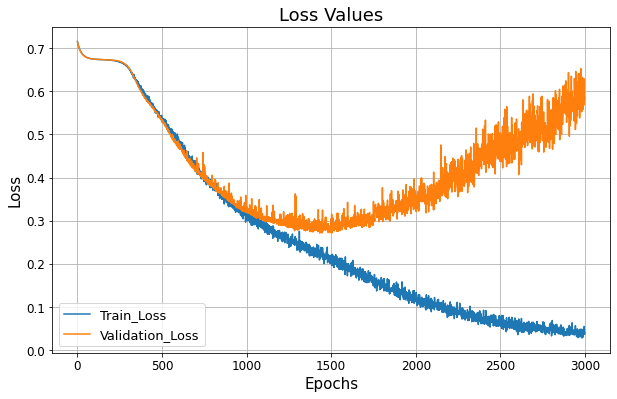

In [20]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train_Loss')
plt.plot(validation_loss, label='Validation_Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=13)
plt.tick_params(labelsize=12)
plt.grid()
plt.title('Loss Values', fontsize=18)
plt.savefig(f'graphs/{version}/loss_b{batch_size}_e{epochs}.png', dpi=300)

### Testing
#### Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: scene 	 Prediction: scene 	 Result: Right


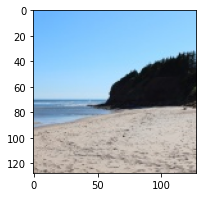

Truth: scene 	 Prediction: scene 	 Result: Right


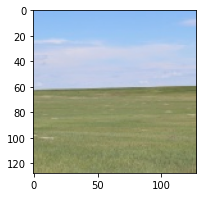

Truth: scene 	 Prediction: person 	 Result: Wrong


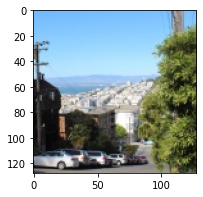

Truth: scene 	 Prediction: scene 	 Result: Right


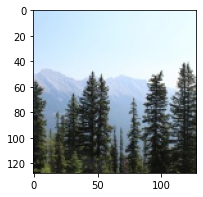

Truth: scene 	 Prediction: scene 	 Result: Right


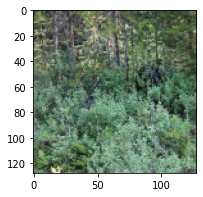

Truth: scene 	 Prediction: scene 	 Result: Right


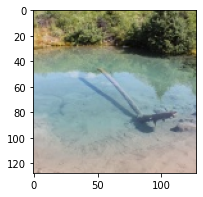

Truth: scene 	 Prediction: scene 	 Result: Right


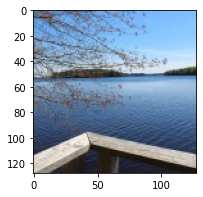

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


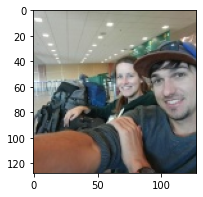

Truth: scene 	 Prediction: scene 	 Result: Right


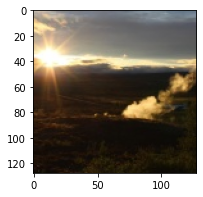

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: scene 	 Result: Wrong


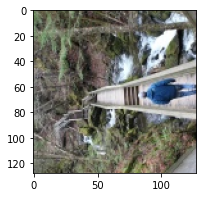

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: scene 	 Prediction: scene 	 Result: Right


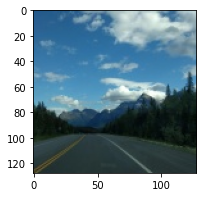

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


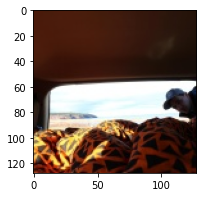

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


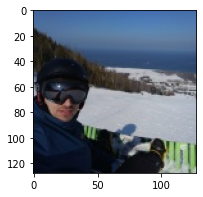

Truth: scene 	 Prediction: scene 	 Result: Right


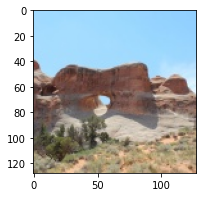

Truth: scene 	 Prediction: scene 	 Result: Right


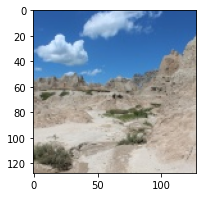

Truth: scene 	 Prediction: scene 	 Result: Right


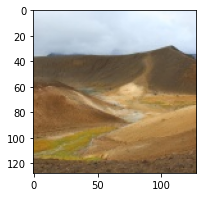

Truth: scene 	 Prediction: scene 	 Result: Right


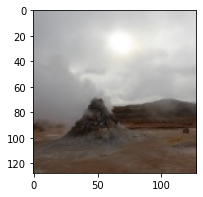

Truth: scene 	 Prediction: person 	 Result: Wrong


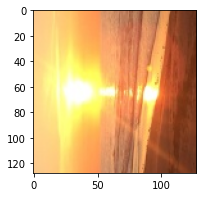

Truth: scene 	 Prediction: scene 	 Result: Right


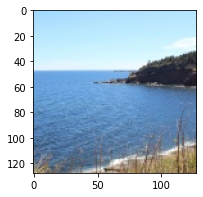

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


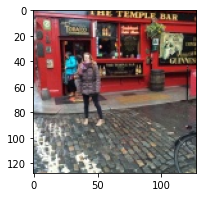

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


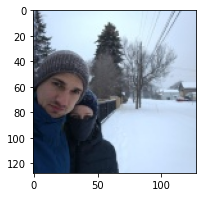

Truth: scene 	 Prediction: scene 	 Result: Right


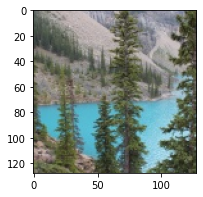

Truth: person 	 Prediction: person 	 Result: Right


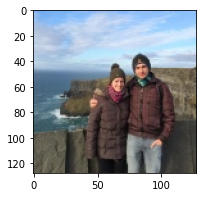

Truth: person 	 Prediction: person 	 Result: Right


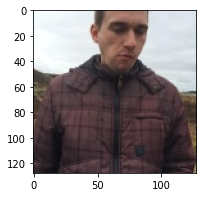

Truth: person 	 Prediction: person 	 Result: Right


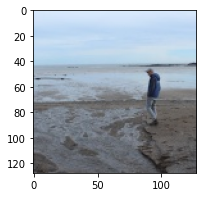

Truth: person 	 Prediction: person 	 Result: Right


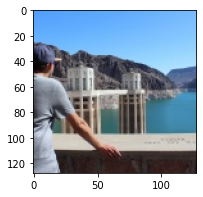

Truth: scene 	 Prediction: scene 	 Result: Right


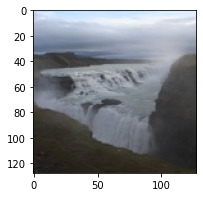

Truth: person 	 Prediction: person 	 Result: Right


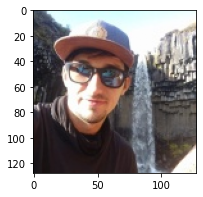

Truth: scene 	 Prediction: scene 	 Result: Right


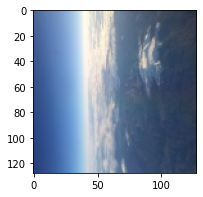

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


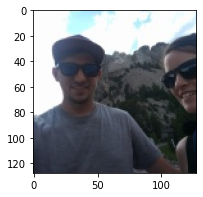

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


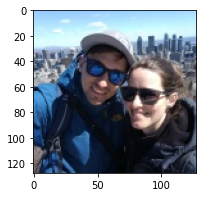

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: scene 	 Prediction: scene 	 Result: Right


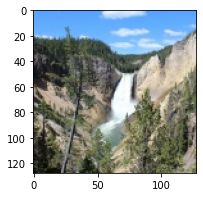

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: scene 	 Prediction: scene 	 Result: Right


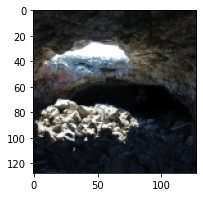

Truth: scene 	 Prediction: scene 	 Result: Right


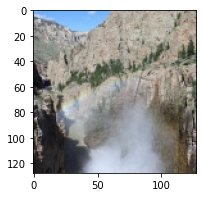

Truth: person 	 Prediction: person 	 Result: Right


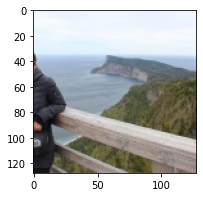

Truth: person 	 Prediction: person 	 Result: Right


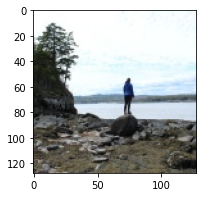

Truth: person 	 Prediction: person 	 Result: Right


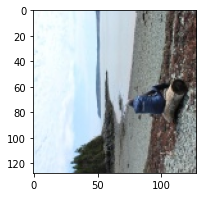

Truth: person 	 Prediction: person 	 Result: Right


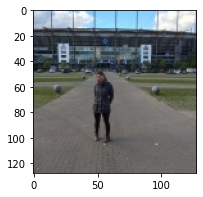

Truth: scene 	 Prediction: scene 	 Result: Right


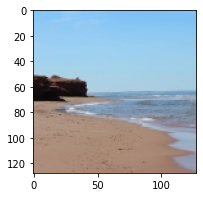

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


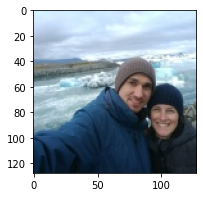

Truth: person 	 Prediction: person 	 Result: Right


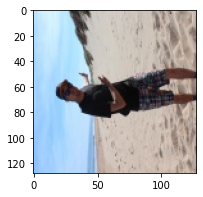

Truth: scene 	 Prediction: scene 	 Result: Right


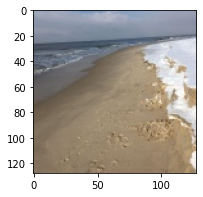

Truth: scene 	 Prediction: scene 	 Result: Right


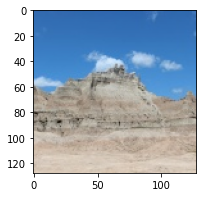

Truth: person 	 Prediction: person 	 Result: Right


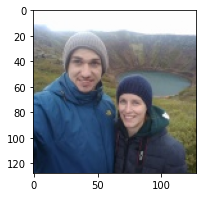

Truth: scene 	 Prediction: scene 	 Result: Right


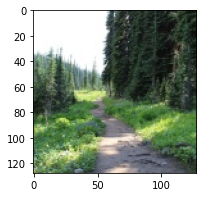

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


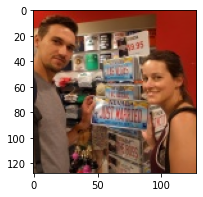

Truth: scene 	 Prediction: scene 	 Result: Right


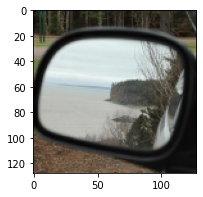

Truth: person 	 Prediction: person 	 Result: Right


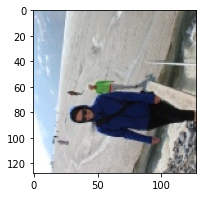

Truth: scene 	 Prediction: scene 	 Result: Right


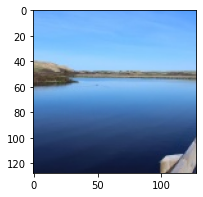

Truth: scene 	 Prediction: scene 	 Result: Right


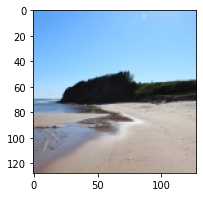

Truth: scene 	 Prediction: scene 	 Result: Right


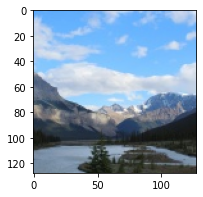

Truth: scene 	 Prediction: person 	 Result: Wrong


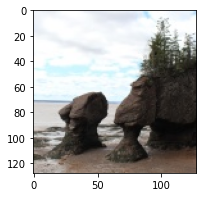

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: scene 	 Prediction: scene 	 Result: Right


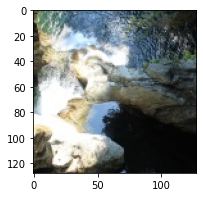

Truth: person 	 Prediction: person 	 Result: Right


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


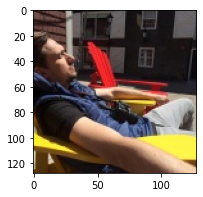

Truth: person 	 Prediction: person 	 Result: Right


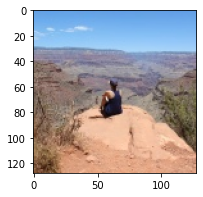

Truth: scene 	 Prediction: scene 	 Result: Right


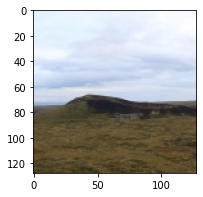

Truth: scene 	 Prediction: scene 	 Result: Right


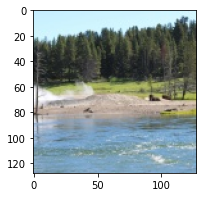

Truth: person 	 Prediction: person 	 Result: Right


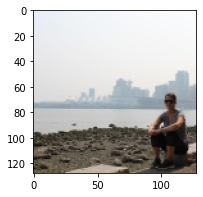

Truth: person 	 Prediction: person 	 Result: Right


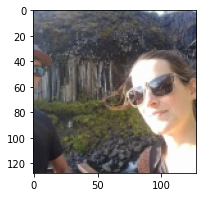

Truth: scene 	 Prediction: scene 	 Result: Right


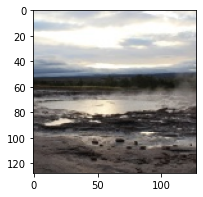

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


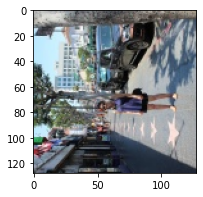

Truth: person 	 Prediction: scene 	 Result: Wrong


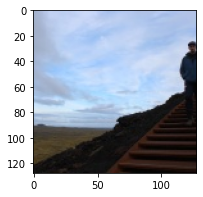

Truth: scene 	 Prediction: scene 	 Result: Right


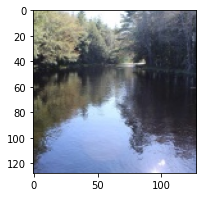

Truth: person 	 Prediction: person 	 Result: Right


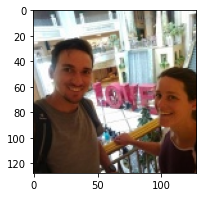

In [21]:
#load a batch from the test set
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

#generate predictions of testloader samples
#deactivate droptout layer with .eval()
cnn.eval()                 
outputs = cnn(images)

#the class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs, 1)

for i in range(batch_size):
    if classes[labels[i]] == classes[predicted[i]]:
        boolean = 'Right'
    else:
        boolean = 'Wrong'
    print(f'Truth: {classes[labels[i]]} \t Prediction: {classes[predicted[i]]} \t Result: {boolean}')
    imshow(images[i])

#### Complete testset - final epoch

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = cnn(data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 597 test images: %d %%' % (100 * correct / total),'\n', file=f)
print('Accuracy of the network on the 597 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 597 test images: 90 %


#### Complete testset - best epoch

In [23]:
#Loading the model
cnn_best = CNN(pixel).to(device)
cnn_best.load_state_dict(torch.load(f'models/{version}/cnn_net_b{batch_size}_e{epochs}.pth'))
cnn.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = cnn_best(data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = int(100 * correct / total)

print('Accuracy of the network on the 597 test images with best iteration: %d %%' % (100 * correct / total),'\n', file=f)
print('Accuracy of the network on the 597 test images with best iteration: %d %%' % (100 * correct / total))

Accuracy of the network on the 597 test images with best iteration: 87 %


### Script Runtime Result

In [24]:
#End Time of Training
script_end = end_time_()

#Time needed for script
print(f'Execution time of script is : {Execution_time(script_start, script_end)} hh:mm:ss')

Execution time of script is : 02:49:17 hh:mm:ss


### Closing output textfile

In [25]:
f.close()